In [1]:
### 1. Import modules:

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
plt.rcParams['text.latex.preamble'] = [r'\boldmath']
from matplotlib.pyplot import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

from collections import OrderedDict
from numpy.linalg import slogdet
from scipy.linalg import inv
from scipy.optimize import minimize
from scipy.special import gamma
from scipy.stats import norm, t
from joblib import Parallel, delayed

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.surrogates.tStudentProcess import logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential, matern32, matern52

import warnings
import random
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
### 2. User-defined - inputs:

### Objective Function:
obj_func = 'Hartmann3' # 6-D;

### Data inputs:
n_test = 50

### Student-t parameter input:
df1 = 5 # Degree(s)-of-freedom (DF)

### Acquisition / Utility function - MLE/Type II:
util_gp = 'RegretMinimized' # Gaussian MLE
util_stp = 'tRegretMinimized' # Student-t MLE

#util_gp = 'ExpectedImprovement' # Gaussian MLE
#util_stp = 'tExpectedImprovement' # Student-t MLE

### Probabilistic / Surrogate / Stochastic model - MLE/Type II: 
#surrogate_model_gp = 'Gaussian Process'
surrogate_model_stp = 'Student-t Process'

### Covariance Function:
cov_func = squaredExponential()
#cov_func = matern32()
#cov_func = matern52()

n_init = 5  # Number of iterations used to initialise Bayesian optimisation; minimum 2

### MLE / Type II Empirical Bayes:
optimize = False # MLE Boolean
usegrads = False # MLE Boolean (pyGPGO not programmed for Student-t MLE)


In [3]:
### 3. Objective Function - Hartmann3(x) 3-D:

if obj_func == 'Hartmann3':
            
    # True y bounds:
    y_lb = -3.86278
    operator = -1 # targets global minimum 
    y_global_orig = y_lb * operator # targets global minimum
            
# Constraints:
    lb = 0
    ub = 1
    
# Input array dimension(s):
    dim = 3

# 3-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub]),
             'x3_training': ('cont', [lb, ub])}
    
    max_iter = (10 * dim)*0 + 100  # iterations of Bayesian optimisation
    
# Test data:
    x1_test = np.linspace(lb, ub, n_test) 
    x2_test = np.linspace(lb, ub, n_test)
    x3_test = np.linspace(lb, ub, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test, x3_test))
    
    def f_syn_polarity(x1_training, x2_training, x3_training):
       
        value = np.array([x1_training, x2_training, x3_training])
      
        a = np.array([[3.0, 10, 30],
                      [0.1, 10, 35],
                      [3.0, 10, 30],
                      [0.1, 10, 35]])
        
        alpha = np.array([1.0, 1.2, 3.0, 3.2])
      
        p = np.array([[.3689, .1170, .2673],
                      [.4699, .4387, .7470],
                      [.1091, .8732, .5547],
                      [.3810, .5743, .8828]])
  
        s = 0
        for i in [0,1,2,3]:
            sm = a[i,0]*(value[0]-p[i,0])**2
            sm += a[i,1]*(value[1]-p[i,1])**2
            sm += a[i,2]*(value[2]-p[i,2])**2
            s += alpha[i]*np.exp(-sm)
        result = -s
        
        return operator * result
      
    def f_syn_transform_polarity(x1_training, x2_training, x3_training):
            return operator * (np.sqrt(2 * (y_global_orig - f_syn_polarity(x1_training, x2_training, x3_training))))
        

In [4]:
### 4a. Add new acquisition functions: add CBM & ERM (Nyugen and Osborne, 2019) method .

### Inherits from class Acquisition()

class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=1e-06, **params):
        """
        Acquisition function class.
        Parameters
        ----------
        mode: str
            Defines the behaviour of the acquisition strategy.
        eps: float
            Small floating value to avoid `np.sqrt` or zero-division warnings.
        params: float
            Extra parameters needed for certain acquisition functions, e.g. UCB needs
            to be supplied with `beta`.
        """
        self.params = params
        self.eps = eps

        mode_dict = {
            'ExpectedImprovement': self.ExpectedImprovement,
            'tExpectedImprovement': self.tExpectedImprovement,
            'RegretMinimized': self.RegretMinimized,
            'tRegretMinimized': self.tRegretMinimized
        }

        self.f = mode_dict[mode]
   
    def ExpectedImprovement(self, tau, mean, std):
        """
        Expected Improvement acquisition function.
        Parameters
        ----------
        tau: float
            Best observed function evaluation.
        mean: float
            Point mean of the posterior process.
        std: float
            Point std of the posterior process.
        Returns
        -------
        float
            Expected improvement.
        """
        z = (mean - tau - self.eps) / (std + self.eps)
        return (mean - tau) * norm.cdf(z) + std * norm.pdf(z)[0]


    def RegretMinimized(self, tau, mean, std):
        """
        Regret Minimized acquisition function.
        Parameters
        ----------
        tau: float
            Best observed function evaluation.
        mean: float
            Point mean of the posterior process.
        std: float
            Point std of the posterior process.
        Returns
        -------
        float
            Expected improvement.
        """
        
        z = (mean - y_global_orig - self.eps) / (std + self.eps)
        return z * (std + self.eps) * norm.cdf(z) + std * norm.pdf(z)[0]
    
    
    def tExpectedImprovement(self, tau, mean, std, nu=3.0):
        """
        Expected Improvement acquisition function. Only to be used with `tStudentProcess` surrogate.
        Parameters
        ----------
        tau: float
            Best observed function evaluation.
        mean: float
            Point mean of the posterior process.
        std: float
            Point std of the posterior process.
        Returns
        -------
        float
            Expected improvement.
        """
        gamma = (mean - tau - self.eps) / (std + self.eps)
        return gamma * std * t.cdf(gamma, df=nu) + std * (1 + (gamma ** 2 - 1)/(nu - 1)) * t.pdf(gamma, df=nu)
    
    
    def tRegretMinimized(self, tau, mean, std, nu=3.0):
        """
        Regret Minimized acquisition function. Only to be used with `tStudentProcess` surrogate.
        Parameters
        ----------
        tau: float
            Best observed function evaluation.
        mean: float
            Point mean of the posterior process.
        std: float
            Point std of the posterior process.
        Returns
        -------
        float
            Expected improvement.
        """
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return gamma * (std + self.eps) * t.cdf(gamma, df=nu) + std * (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma, df=nu)
    

In [5]:
### 4b. Re-define tStudentProcess class with non-zero prior mean function:

### [Nyugen and Osborne, 2019] "Knowing The What But Not The Where in Bayesian Optimization"

### Inherits from class tStudentProcess()

class tStudentProcess_prior(tStudentProcess):
    def __init__(self, covfunc, nu, optimize=False, mprior=0):
        """
        t-Student Process regressor class.
        This class DOES NOT support gradients in ML estimation yet.
        Parameters
        ----------
        covfunc: instance from a class of covfunc module
            An instance from a class from the `covfunc` module.
        nu: float
            (>2.0) Degrees of freedom
        Attributes
        ----------
        covfunc: object
            Internal covariance function.
        nu: float
            Degrees of freedom.
        optimize: bool
            Whether to optimize covariance function hyperparameters.
        """
        self.covfunc = covfunc
        self.nu = nu
        self.optimize = optimize
        self.mprior = mprior
        
    def logpdf(x, nu, Sigma):
        """
        Marginal log-likelihood of a Student-t Process
        Parameters
        ----------
        x: array-like
            Point to be evaluated
        df: float
            Degrees of freedom (>2.0)
        mu: array-like
            Mean of the process.
        Sigma: array-like
            Covariance matrix of the process.
        Returns
        -------
        logp: float
            log-likelihood 
        """
        d = len(x)
        x = np.atleast_2d(x)
        xm = x - self.mprior
        V = nu * Sigma
        V_inv = np.linalg.inv(V)
        _, logdet = slogdet(np.pi * V)

        logz = -gamma(nu / 2.0 + d / 2.0) + gamma(nu / 2.0) + 0.5 * logdet
        logp = -0.5 * (nu + d) * np.log(1 + np.sum(np.dot(xm, V_inv) * xm, axis=1))

        logp = logp - logz

        return logp[0]
    
    def fit(self, X, y):
        """
        Fits a t-Student Process regressor
        Parameters
        ----------
        X: np.ndarray, shape=(nsamples, nfeatures)
            Training instances to fit the GP.
        y: np.ndarray, shape=(nsamples,)
            Corresponding continuous target values to `X`.
        """
        self.X = X
        self.y = y
        self.n1 = X.shape[0]

        if self.optimize:
            self.optHyp(param_key=self.covfunc.parameters, param_bounds=self.covfunc.bounds)

        self.K11 = self.covfunc.K(self.X, self.X)
        self.beta1 = np.dot(np.dot(self.y.T, inv(self.K11)), self.y)
        self.logp = logpdf(self.y, self.nu, mu=self.mprior, Sigma=self.K11)
        

In [6]:
### 5a. Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [7]:
### 5b. Set-seeds:

run_num_1 = 111
run_num_2 = 222
run_num_3 = 333
run_num_4 = 444
run_num_5 = 555
run_num_6 = 666
run_num_7 = 777
run_num_8 = 888
run_num_9 = 999
run_num_10 = 1000
run_num_11 = 1111
run_num_12 = 1222
run_num_13 = 1333
run_num_14 = 1444
run_num_15 = 1555
run_num_16 = 1666
run_num_17 = 1777
run_num_18 = 1888
run_num_19 = 1999
run_num_20 = 2000


In [8]:
### 6(a). Bayesian optimization runs (x20): GP run number = 1

np.random.seed(run_num_1)
surrogate_gp_1 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_1 = GPGO(surrogate_gp_1, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_1.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.61217018 0.16906975 0.43605902]. 	  0.37345684462559386 	 2.3951473341797507
init   	 [0.76926247 0.2953253  0.14916296]. 	  0.296162062221701 	 2.3951473341797507
init   	 [0.02247832 0.42022449 0.23868214]. 	  0.2904113287153621 	 2.3951473341797507
init   	 [0.33765619 0.99071246 0.23772645]. 	  0.11013785080555143 	 2.3951473341797507
init   	 [0.08119266 0.66960024 0.62124292]. 	  2.3951473341797507 	 2.3951473341797507
1      	 [0.         0.86482727 1.        ]. 	  0.8663385652929555 	 2.3951473341797507
2      	 [0.9694624  0.81729872 0.76150236]. 	  1.3879340688336017 	 2.3951473341797507
3      	 [0.00746842 0.39300358 0.94016277]. 	  2.339565033428072 	 2.3951473341797507
4      	 [0.99271916 0.97953791 0.19194934]. 	  0.0051249034030868 	 2.3951473341797507
5      	 [0.89539121 0.31310218 0.96935805]. 	  1.3903958518762796 	 2.3951473341797507
6      	 [0.43154031 0.53910525 0.95905966]. 	  2.807998020967

88     	 [0.52645571 0.75007053 0.81331628]. 	  2.5756383452991445 	 3.0000629220142074
89     	 [0.67162765 0.16588182 0.85316793]. 	  0.9636196694046057 	 3.0000629220142074
90     	 [0.1353118  0.41816142 0.57977477]. 	  0.9330594111440559 	 3.0000629220142074
91     	 [0.84515891 0.7984235  0.27681832]. 	  0.06007456863337144 	 3.0000629220142074
92     	 [0.65259893 0.40543277 0.61169084]. 	  0.9410805313922265 	 3.0000629220142074
93     	 [0.89712384 0.86740939 0.57199769]. 	  0.5705142395729424 	 3.0000629220142074
94     	 [0.10050002 0.70316347 0.1260103 ]. 	  0.02331172194873839 	 3.0000629220142074
95     	 [0.49266886 0.21165411 0.91177336]. 	  1.110705187350084 	 3.0000629220142074
96     	 [0.02291614 0.84016591 0.0677154 ]. 	  0.0034917025704461944 	 3.0000629220142074
97     	 [0.09047156 0.52056546 0.37167556]. 	  0.43681458744751706 	 3.0000629220142074
98     	 [0.30024739 0.21118253 0.95814266]. 	  0.8514100172171297 	 3.0000629220142074
99     	 [0.05766926 0.6207

In [9]:
### 6(a). Bayesian optimization runs (x20): STP DF1 run number = 1

np.random.seed(run_num_1)
surrogate_stp_df1_1 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_1 = GPGO(surrogate_stp_df1_1, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_1.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.61217018 0.16906975 0.43605902]. 	  0.37345684462559386 	 2.3951473341797507
init   	 [0.76926247 0.2953253  0.14916296]. 	  0.296162062221701 	 2.3951473341797507
init   	 [0.02247832 0.42022449 0.23868214]. 	  0.2904113287153621 	 2.3951473341797507
init   	 [0.33765619 0.99071246 0.23772645]. 	  0.11013785080555143 	 2.3951473341797507
init   	 [0.08119266 0.66960024 0.62124292]. 	  2.3951473341797507 	 2.3951473341797507
1      	 [0. 1. 1.]. 	  0.330219860606422 	 2.3951473341797507
2      	 [1.         0.77045317 1.        ]. 	  1.3380072484105159 	 2.3951473341797507
3      	 [0.         0.12567546 1.        ]. 	  0.30752227328286746 	 2.3951473341797507
4      	 [1. 0. 1.]. 	  0.08848201872702738 	 2.3951473341797507
5      	 [1.         1.         0.29332195]. 	  0.03057630306425369 	 2.3951473341797507
6      	 [0.46078378 0.53914416 1.        ]. 	  2.0702885314883517 	 2.3951473341797507
7      	 [1. 0. 0.]

89     	 [0.13983935 0.60982176 0.8363651 ]. 	  3.7212576581323322 	 3.856996655758139
90     	 [0.18475198 0.62537676 0.85740846]. 	  3.686725681417821 	 3.856996655758139
91     	 [0.70822321 0.5796581  0.85518904]. 	  3.759830622179515 	 3.856996655758139
92     	 [0.13551095 0.6147752  0.86099234]. 	  3.7217456557246953 	 3.856996655758139
93     	 [0.39429329 0.5761656  0.87345389]. 	  3.8035064243724515 	 3.856996655758139
94     	 [0.03374698 0.59886308 0.8778744 ]. 	  3.700730318087712 	 3.856996655758139
95     	 [0.78403425 0.56597061 0.87503343]. 	  3.7226708827540422 	 3.856996655758139
96     	 [0.24940303 0.48230424 0.79459449]. 	  3.4271358926072937 	 3.856996655758139
97     	 [0.17092155 0.54018489 0.81752972]. 	  3.7374931594371636 	 3.856996655758139
98     	 [0.35321781 0.54229618 0.81064778]. 	  3.691339919948006 	 3.856996655758139
99     	 [0.05766922 0.62078601 0.81547454]. 	  3.567716407624374 	 3.856996655758139
100    	 [0.33421112 0.49737904 0.8374782 ]. 	  

In [10]:
### 6(a). Training Regret Minimisation: run number = 1

gp_output_1 = np.append(np.max(gpgo_gp_1.GP.y[0:n_init]),gpgo_gp_1.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_1 = np.append(np.max(gpgo_stp_df1_1.GP.y[0:n_init]),gpgo_stp_df1_1.GP.y[n_init:(n_init+max_iter)])

regret_gp_1 = np.log(y_global_orig - gp_output_1)
regret_stp_df1_1 = np.log(y_global_orig - stp_df1_output_1)

train_regret_gp_1 = min_max_array(regret_gp_1)
train_regret_stp_df1_1 = min_max_array(regret_stp_df1_1)

# GP, STP df1 - training regret minimization: run number = 1
min_train_regret_gp_1 = min(train_regret_gp_1)
min_train_regret_stp_df1_1 = min(train_regret_stp_df1_1)

min_train_regret_gp_1, min_train_regret_stp_df1_1


(-1.2205577764509106, -5.152773175058427)

In [11]:
### 6(b). Bayesian optimization runs (x20): GP run number = 2

np.random.seed(run_num_2)
surrogate_gp_2 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_2 = GPGO(surrogate_gp_2, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_2.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.52602843 0.68531719 0.83567419]. 	  3.224923929499112 	 3.224923929499112
init   	 [0.65376526 0.03702195 0.18015566]. 	  0.5855524570206746 	 3.224923929499112
init   	 [0.76056942 0.22430462 0.73513507]. 	  1.1851880051371382 	 3.224923929499112
init   	 [0.28749046 0.73278001 0.10764748]. 	  0.015865788013002657 	 3.224923929499112
init   	 [0.09385216 0.78318907 0.51959739]. 	  2.745038971968515 	 3.224923929499112
1      	 [0. 1. 1.]. 	  0.330219860606422 	 3.224923929499112
2      	 [0.         0.16632652 0.58367067]. 	  0.2970939654230494 	 3.224923929499112
3      	 [0.7136153  1.         0.74262439]. 	  0.6066905443016801 	 3.224923929499112
4      	 [0.35130055 0.67793646 0.64016205]. 	  2.2003797354774415 	 3.224923929499112
5      	 [0.84206795 0.66050508 1.        ]. 	  1.8762732128158859 	 3.224923929499112
6      	 [0. 1. 0.]. 	  0.0002735367680454459 	 3.224923929499112
7      	 [0.67734943 0.        

90     	 [0.76821153 0.51587517 0.81728031]. 	  3.5930061371538042 	 3.743022291423356
91     	 [0.96645967 0.1587612  0.88166805]. 	  0.8334989128506818 	 3.743022291423356
92     	 [0.15561261 0.07593028 0.96635313]. 	  0.2672322275701534 	 3.743022291423356
93     	 [0.27296138 0.89042181 0.48567342]. 	  2.411592501709204 	 3.743022291423356
94     	 [0.87345409 0.93913188 0.31161207]. 	  0.08520323240628584 	 3.743022291423356
95     	 [0.60913689 0.99516506 0.13754537]. 	  0.006826552412049399 	 3.743022291423356
96     	 [0.44252475 0.49994431 0.22823292]. 	  0.23875974433597896 	 3.743022291423356
97     	 [0.3073207  0.50090373 0.66132716]. 	  1.911208801117378 	 3.743022291423356
98     	 [0.99095956 0.1429846  0.56498283]. 	  0.18994732210356183 	 3.743022291423356
99     	 [0.55308075 0.3500606  0.01959509]. 	  0.08328961131340018 	 3.743022291423356
100    	 [0.82171241 0.23616843 0.51541852]. 	  0.21400579157084154 	 3.743022291423356


In [12]:
### 6(b). Bayesian optimization runs (x20): STP DF1 run number = 2

np.random.seed(run_num_2)
surrogate_stp_df1_2 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_2 = GPGO(surrogate_stp_df1_2, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_2.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.52602843 0.68531719 0.83567419]. 	  3.224923929499112 	 3.224923929499112
init   	 [0.65376526 0.03702195 0.18015566]. 	  0.5855524570206746 	 3.224923929499112
init   	 [0.76056942 0.22430462 0.73513507]. 	  1.1851880051371382 	 3.224923929499112
init   	 [0.28749046 0.73278001 0.10764748]. 	  0.015865788013002657 	 3.224923929499112
init   	 [0.09385216 0.78318907 0.51959739]. 	  2.745038971968515 	 3.224923929499112
1      	 [0. 1. 1.]. 	  0.330219860606422 	 3.224923929499112
2      	 [0.         0.         0.61961303]. 	  0.1226327058266145 	 3.224923929499112
3      	 [1.         1.         0.78596933]. 	  0.4570515388446086 	 3.224923929499112
4      	 [ 0.00000000e+00  0.00000000e+00 -1.38777878e-17]. 	  0.06797411659013229 	 3.224923929499112
5      	 [0.40977364 1.         0.65608584]. 	  1.5557436000353566 	 3.224923929499112
6      	 [1.         0.49458523 0.        ]. 	  0.008537503547999802 	 3.22492392

90     	 [0.76821153 0.51587517 0.81728031]. 	  3.5930061371538042 	 3.819588273867835
91     	 [0.50432738 0.45208135 0.8569793 ]. 	  3.493225429813474 	 3.819588273867835
92     	 [0.42088313 0.59786771 0.85320797]. 	  3.785688934480701 	 3.819588273867835
93     	 [0.32578215 0.64731621 0.86735065]. 	  3.557808661859921 	 3.819588273867835
94     	 [0.50581327 0.52864558 0.81672848]. 	  3.691973153921402 	 3.819588273867835
95     	 [0.42830048 0.60252064 0.85506938]. 	  3.7701095813706837 	 3.819588273867835
96     	 [0.56855353 0.52546251 0.87860766]. 	  3.738552839958162 	 3.819588273867835
97     	 [0.70751439 0.50370855 0.80882065]. 	  3.525439570632387 	 3.819588273867835
98     	 [0.64921217 0.53397061 0.90853479]. 	  3.5016991279832657 	 3.819588273867835
99     	 [0.55306673 0.65391424 0.78160353]. 	  3.0353314821060335 	 3.819588273867835
100    	 [0.38197263 0.47317488 0.8798675 ]. 	  3.547136917783297 	 3.819588273867835


In [13]:
### 6(b). Training Regret Minimisation: run number = 2

gp_output_2 = np.append(np.max(gpgo_gp_2.GP.y[0:n_init]),gpgo_gp_2.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_2 = np.append(np.max(gpgo_stp_df1_2.GP.y[0:n_init]),gpgo_stp_df1_2.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_2 = np.log(y_global_orig - gp_output_2)
regret_stp_df1_2 = np.log(y_global_orig - stp_df1_output_2)

train_regret_gp_2 = min_max_array(regret_gp_2)
train_regret_stp_df1_2 = min_max_array(regret_stp_df1_2)

# GP, STP df1 - training regret minimization: run number = 2
min_train_regret_gp_2 = min(train_regret_gp_2)
min_train_regret_stp_df1_2 = min(train_regret_stp_df1_2)

min_train_regret_gp_2, min_train_regret_stp_df1_2


(-2.1222846725153683, -3.14210632679368)

In [14]:
### 6(c). Bayesian optimization runs (x20): GP run number = 3

np.random.seed(run_num_3)
surrogate_gp_3 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_3 = GPGO(surrogate_gp_3, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_3.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.54329109 0.72895073 0.01688145]. 	  0.003524201143729458 	 0.7966854416715844
init   	 [0.3303388  0.36872182 0.04830367]. 	  0.1254131411976814 	 0.7966854416715844
init   	 [0.10453019 0.09743752 0.24540331]. 	  0.7966854416715844 	 0.7966854416715844
init   	 [0.87348935 0.05161164 0.06048134]. 	  0.12371149908893726 	 0.7966854416715844
init   	 [0.23874011 0.20369919 0.17453362]. 	  0.6814516737210936 	 0.7966854416715844
1      	 [0.58131256 0.44428472 1.        ]. 	  1.7923481631128224 	 1.7923481631128224
2      	 [0.00168031 0.98640159 0.93345165]. 	  0.5794398689332044 	 1.7923481631128224
3      	 [0.91276762 0.99413854 0.79042039]. 	  0.5168155300754682 	 1.7923481631128224
4      	 [0.87462587 0.07463384 0.89216661]. 	  0.4064577125806287 	 1.7923481631128224
5      	 [0.25457824 0.1010065  0.77250547]. 	  0.5976449039333983 	 1.7923481631128224
6      	 [0.09233414 0.94854072 0.38769464]. 	  1.228262220

89     	 [0.07555548 0.26880522 0.6257711 ]. 	  0.7323313253399928 	 3.608301835883924
90     	 [0.27757916 0.48844877 0.35718201]. 	  0.393014260215152 	 3.608301835883924
91     	 [0.24779771 0.7020849  0.37180803]. 	  0.8017188234427736 	 3.608301835883924
92     	 [0.41147044 0.50186371 0.24538265]. 	  0.25562364040711605 	 3.608301835883924
93     	 [0.12363747 0.00604395 0.00947706]. 	  0.10048454145419308 	 3.608301835883924
94     	 [0.34233053 0.8561281  0.23545011]. 	  0.123547524559342 	 3.608301835883924
95     	 [0.66708453 0.12567109 0.05050743]. 	  0.18684930581019238 	 3.608301835883924
96     	 [0.27196874 0.4249447  0.04052478]. 	  0.08064974590850453 	 3.608301835883924
97     	 [0.66269814 0.80828927 0.4153153 ]. 	  0.6510516078803028 	 3.608301835883924
98     	 [0.80789932 0.70389513 0.99592796]. 	  1.7659592129198352 	 3.608301835883924
99     	 [0.40503689 0.40878657 0.23853599]. 	  0.42817250057984524 	 3.608301835883924
100    	 [0.61940483 0.67694345 0.617118

In [15]:
### 6(c). Bayesian optimization runs (x20): STP DF1 run number = 3

np.random.seed(run_num_3)
surrogate_stp_df1_3 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_3 = GPGO(surrogate_stp_df1_3, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_3.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.54329109 0.72895073 0.01688145]. 	  0.003524201143729458 	 0.7966854416715844
init   	 [0.3303388  0.36872182 0.04830367]. 	  0.1254131411976814 	 0.7966854416715844
init   	 [0.10453019 0.09743752 0.24540331]. 	  0.7966854416715844 	 0.7966854416715844
init   	 [0.87348935 0.05161164 0.06048134]. 	  0.12371149908893726 	 0.7966854416715844
init   	 [0.23874011 0.20369919 0.17453362]. 	  0.6814516737210936 	 0.7966854416715844
1      	 [0.64681054 0.53437973 1.        ]. 	  2.05083814853583 	 2.05083814853583
2      	 [0. 1. 1.]. 	  0.330219860606422 	 2.05083814853583
3      	 [0.42228444 0.         1.        ]. 	  0.09173257964910508 	 2.05083814853583
4      	 [1.         1.         0.94266076]. 	  0.45928899433621223 	 2.05083814853583
5      	 [1.         0.         0.93456932]. 	  0.15330770268481658 	 2.05083814853583
6      	 [0.         1.         0.14131942]. 	  0.014804220187581086 	 2.05083814853583
7    

90     	 [0.43033865 0.5518736  0.88061621]. 	  3.7801078539392434 	 3.8503389102407817
91     	 [0.38686352 0.53047762 0.85186514]. 	  3.8378710804080014 	 3.8503389102407817
92     	 [0.41975174 0.49529405 0.83843001]. 	  3.7210508831162974 	 3.8503389102407817
93     	 [0.4751081  0.61043225 0.8461292 ]. 	  3.7228279318616817 	 3.8503389102407817
94     	 [0.10633441 0.54413372 0.89028113]. 	  3.692209427681085 	 3.8503389102407817
95     	 [0.42194945 0.53946853 0.82585848]. 	  3.7745730726343822 	 3.8503389102407817
96     	 [0.43781657 0.64469106 0.86353993]. 	  3.5666416785060386 	 3.8503389102407817
97     	 [0.50773052 0.54429454 0.85285952]. 	  3.837321293881975 	 3.8503389102407817
98     	 [0.48703905 0.5791936  0.84441782]. 	  3.808053205201958 	 3.8503389102407817
99     	 [0.71557179 0.52586525 0.86079281]. 	  3.7596229904726886 	 3.8503389102407817
100    	 [0.53008422 0.50545953 0.83314986]. 	  3.7227668727381595 	 3.8503389102407817


In [16]:
### 6(c). Training Regret Minimisation: run number = 3

gp_output_3 = np.append(np.max(gpgo_gp_3.GP.y[0:n_init]),gpgo_gp_3.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_3 = np.append(np.max(gpgo_stp_df1_3.GP.y[0:n_init]),gpgo_stp_df1_3.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_3 = np.log(y_global_orig - gp_output_3)
regret_stp_df1_3 = np.log(y_global_orig - stp_df1_output_3)

train_regret_gp_3 = min_max_array(regret_gp_3)
train_regret_stp_df1_3 = min_max_array(regret_stp_df1_3)

# GP, STP df1 - training regret minimization: run number = 3
min_train_regret_gp_3 = min(train_regret_gp_3)
min_train_regret_stp_df1_3 = min(train_regret_stp_df1_3)

min_train_regret_gp_3, min_train_regret_stp_df1_3


(-1.3685402458234954, -4.386750594284538)

In [17]:
### 6(d). Bayesian optimization runs (x20): GP run number = 4

np.random.seed(run_num_4)
surrogate_gp_4 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_4 = GPGO(surrogate_gp_4, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_4.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.83936105 0.82129497 0.64220716]. 	  0.8796727111154451 	 1.9592421489197056
init   	 [0.66722262 0.03913991 0.06567239]. 	  0.21283931850025994 	 1.9592421489197056
init   	 [0.27650064 0.3163605  0.19359241]. 	  0.5590312289203825 	 1.9592421489197056
init   	 [0.19709288 0.84920429 0.84235809]. 	  1.818649590001362 	 1.9592421489197056
init   	 [0.34736473 0.7397423  0.49340914]. 	  1.9592421489197056 	 1.9592421489197056
1      	 [0.47647277 0.92393606 0.15672912]. 	  0.017844770068977132 	 1.9592421489197056
2      	 [0.72176507 0.         0.9642597 ]. 	  0.12600563325695788 	 1.9592421489197056
3      	 [0.12891537 0.10450196 0.76439878]. 	  0.6009821728805325 	 1.9592421489197056
4      	 [0.07213246 0.95861543 0.39059898]. 	  1.2397133678239307 	 1.9592421489197056
5      	 [0.98597041 0.2856864  0.41065736]. 	  0.15284929019920618 	 1.9592421489197056
6      	 [0.35984016 0.39345196 0.95312626]. 	  2.20804057

88     	 [0.42658279 0.36008033 0.44964381]. 	  0.37058270938451565 	 3.8151893325258737
89     	 [0.07821525 0.28395456 0.59400979]. 	  0.5962106261528902 	 3.8151893325258737
90     	 [0.35700609 0.85474401 0.67761676]. 	  2.0935319664822267 	 3.8151893325258737
91     	 [0.95577186 0.2331745  0.18906347]. 	  0.25888078497782724 	 3.8151893325258737
92     	 [0.89335318 0.48621021 0.25719843]. 	  0.11947728525669717 	 3.8151893325258737
93     	 [0.25767767 0.32707301 0.11423834]. 	  0.30731655934584096 	 3.8151893325258737
94     	 [0.08343446 0.38720798 0.21858599]. 	  0.3610006026372162 	 3.8151893325258737
95     	 [0.74268025 0.72842831 0.68601941]. 	  1.5289709164819008 	 3.8151893325258737
96     	 [0.02572599 0.03736815 0.77135148]. 	  0.34568347538666316 	 3.8151893325258737
97     	 [0.69612463 0.41825352 0.06053865]. 	  0.08125363518274566 	 3.8151893325258737
98     	 [0.17078721 0.27754479 0.64585559]. 	  0.9021637496207571 	 3.8151893325258737
99     	 [0.67232233 0.971

In [18]:
### 6(d). Bayesian optimization runs (x20): STP DF1 run number = 4

np.random.seed(run_num_4)
surrogate_stp_df1_4 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_4 = GPGO(surrogate_stp_df1_4, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_4.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.83936105 0.82129497 0.64220716]. 	  0.8796727111154451 	 1.9592421489197056
init   	 [0.66722262 0.03913991 0.06567239]. 	  0.21283931850025994 	 1.9592421489197056
init   	 [0.27650064 0.3163605  0.19359241]. 	  0.5590312289203825 	 1.9592421489197056
init   	 [0.19709288 0.84920429 0.84235809]. 	  1.818649590001362 	 1.9592421489197056
init   	 [0.34736473 0.7397423  0.49340914]. 	  1.9592421489197056 	 1.9592421489197056
1      	 [-2.77555756e-17  1.00000000e+00  0.00000000e+00]. 	  0.0002735367680454459 	 1.9592421489197056
2      	 [0.61652879 0.         1.        ]. 	  0.09130370140134696 	 1.9592421489197056
3      	 [1. 1. 0.]. 	  3.7727185179443916e-05 	 1.9592421489197056
4      	 [-5.55111512e-17  0.00000000e+00  1.00000000e+00]. 	  0.0902894676548261 	 1.9592421489197056
5      	 [1.         0.         0.51422235]. 	  0.06905451217074736 	 1.9592421489197056
6      	 [1.         0.41630429 0.        ]. 	 

89     	 [0.33554947 0.58795392 0.7916314 ]. 	  3.493034350901529 	 3.851987105943082
90     	 [0.07221487 0.56387826 0.80832072]. 	  3.6594412184362977 	 3.851987105943082
91     	 [0.49112966 0.52910212 0.78376584]. 	  3.399139966543606 	 3.851987105943082
92     	 [0.62228298 0.56596858 0.84842287]. 	  3.8005613905024203 	 3.851987105943082
93     	 [0.57528114 0.59620818 0.79440127]. 	  3.407557838729203 	 3.851987105943082
94     	 [0.35697267 0.49298132 0.81787027]. 	  3.6338928690176866 	 3.851987105943082
95     	 [0.36221238 0.52669314 0.8282026 ]. 	  3.7779617693726424 	 3.851987105943082
96     	 [0.31736953 0.61633474 0.74698496]. 	  2.970275328203936 	 3.851987105943082
97     	 [0.7031446  0.47190759 0.88263208]. 	  3.480019288040118 	 3.851987105943082
98     	 [0.94883499 0.47504659 0.86131674]. 	  3.499762991873669 	 3.851987105943082
99     	 [0.05970461 0.53394763 0.87106289]. 	  3.7765887954417665 	 3.851987105943082
100    	 [0.40073814 0.47767456 0.81693613]. 	  3

In [19]:
### 6(d). Training Regret Minimisation: run number = 4

gp_output_4 = np.append(np.max(gpgo_gp_4.GP.y[0:n_init]),gpgo_gp_4.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_4 = np.append(np.max(gpgo_stp_df1_4.GP.y[0:n_init]),gpgo_stp_df1_4.GP.y[n_init:(n_init+max_iter)])

regret_gp_4 = np.log(y_global_orig - gp_output_4)
regret_stp_df1_4 = np.log(y_global_orig - stp_df1_output_4)

train_regret_gp_4 = min_max_array(regret_gp_4)
train_regret_stp_df1_4 = min_max_array(regret_stp_df1_4)

# GP, STP df1- training regret minimization: run number = 4
min_train_regret_gp_4 = min(train_regret_gp_4)
min_train_regret_stp_df1_4 = min(train_regret_stp_df1_4)

min_train_regret_gp_4, min_train_regret_stp_df1_4


(-3.045118598435262, -4.528867319093919)

In [20]:
### 6(e). Bayesian optimization runs (x20): GP run number = 5

np.random.seed(run_num_5)
surrogate_gp_5 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_5 = GPGO(surrogate_gp_5, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_5.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.71783409 0.04785513 0.94447198]. 	  0.23942957472217685 	 2.653445131690671
init   	 [0.68638004 0.58120733 0.14267862]. 	  0.05665494655696168 	 2.653445131690671
init   	 [0.94591918 0.33999059 0.62043546]. 	  0.7924779233128625 	 2.653445131690671
init   	 [0.45295964 0.23976742 0.03450459]. 	  0.16568631294324107 	 2.653445131690671
init   	 [0.14859311 0.81086617 0.65310538]. 	  2.653445131690671 	 2.653445131690671
1      	 [0. 1. 1.]. 	  0.330219860606422 	 2.653445131690671
2      	 [0.         0.75325522 0.27055349]. 	  0.23418929122511511 	 2.653445131690671
3      	 [0.53946488 0.78293522 0.80108436]. 	  2.222787207159752 	 2.653445131690671
4      	 [0.10511628 0.29880407 0.69910642]. 	  1.416313449816539 	 2.653445131690671
5      	 [0.47450161 0.98807145 0.56284889]. 	  1.7918639174776751 	 2.653445131690671
6      	 [0.9750877  0.07772881 0.04431082]. 	  0.0735687544157988 	 2.653445131690671
7      	 

89     	 [0.49207924 0.18659491 0.54731336]. 	  0.2751628713079586 	 3.7169884282337264
90     	 [0.73660985 0.19164309 0.98078296]. 	  0.6177517269426429 	 3.7169884282337264
91     	 [0.27854818 0.01255401 0.77187486]. 	  0.27971096302364934 	 3.7169884282337264
92     	 [0.23299495 0.51536524 0.86203195]. 	  3.792695710694982 	 3.792695710694982
93     	 [0.87823746 0.39927767 0.2915064 ]. 	  0.21094708658993638 	 3.792695710694982
94     	 [0.7816664  0.46364056 0.87010867]. 	  3.4725796280725243 	 3.792695710694982
95     	 [0.89014707 0.33122848 0.38813943]. 	  0.20349648159430925 	 3.792695710694982
96     	 [0.13001166 0.66817201 0.22925082]. 	  0.12077318465871603 	 3.792695710694982
97     	 [0.03382991 0.85942112 0.50037557]. 	  2.7272350214576333 	 3.792695710694982
98     	 [0.20597371 0.04876477 0.00068067]. 	  0.10447910129532237 	 3.792695710694982
99     	 [0.65688467 0.18672101 0.74281171]. 	  0.9940940882459904 	 3.792695710694982
100    	 [0.1621024  0.04890557 0.62

In [21]:
### 6(e). Bayesian optimization runs (x20): STP DF1 run number = 5

np.random.seed(run_num_5)
surrogate_stp_df1_5 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_5 = GPGO(surrogate_stp_df1_3, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_5.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.71783409 0.04785513 0.94447198]. 	  0.23942957472217685 	 2.653445131690671
init   	 [0.68638004 0.58120733 0.14267862]. 	  0.05665494655696168 	 2.653445131690671
init   	 [0.94591918 0.33999059 0.62043546]. 	  0.7924779233128625 	 2.653445131690671
init   	 [0.45295964 0.23976742 0.03450459]. 	  0.16568631294324107 	 2.653445131690671
init   	 [0.14859311 0.81086617 0.65310538]. 	  2.653445131690671 	 2.653445131690671
1      	 [0. 1. 1.]. 	  0.330219860606422 	 2.653445131690671
2      	 [0. 1. 0.]. 	  0.0002735367680454459 	 2.653445131690671
3      	 [0.         0.14421256 0.605396  ]. 	  0.3125715870387812 	 2.653445131690671
4      	 [1. 1. 1.]. 	  0.3168836207041561 	 2.653445131690671
5      	 [1. 0. 0.]. 	  0.03095471703300515 	 2.653445131690671
6      	 [0.44652648 1.         0.58132645]. 	  1.8184978148995572 	 2.653445131690671
7      	 [0.45140706 0.60773778 1.        ]. 	  2.0543322271641875 	 2.65344

90     	 [0.43229765 0.63475502 0.85278179]. 	  3.627183459424452 	 3.843478576732947
91     	 [0.95503929 0.58730325 0.79437499]. 	  3.247482904619692 	 3.843478576732947
92     	 [0.77167449 0.56127307 0.87083914]. 	  3.743847965642183 	 3.843478576732947
93     	 [0.38879838 0.51397212 0.83971091]. 	  3.7873165136814286 	 3.843478576732947
94     	 [0.59944541 0.57451079 0.85999768]. 	  3.8009955735329406 	 3.843478576732947
95     	 [0.38008394 0.48464751 0.86417086]. 	  3.673345076610463 	 3.843478576732947
96     	 [0.30636817 0.54176907 0.8578429 ]. 	  3.852870163398532 	 3.852870163398532
97     	 [0.71345481 0.52699276 0.84586713]. 	  3.7580267540320804 	 3.852870163398532
98     	 [0.79685936 0.51588349 0.85318018]. 	  3.715554425180999 	 3.852870163398532
99     	 [0.82080062 0.5420274  0.83111804]. 	  3.6827048681412515 	 3.852870163398532
100    	 [0.4220209  0.58512838 0.85147439]. 	  3.818040012683383 	 3.852870163398532


In [22]:
### 6(e). Training Regret Minimisation: run number = 5

gp_output_5 = np.append(np.max(gpgo_gp_5.GP.y[0:n_init]),gpgo_gp_5.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_5 = np.append(np.max(gpgo_stp_df1_5.GP.y[0:n_init]),gpgo_stp_df1_5.GP.y[n_init:(n_init+max_iter)])

regret_gp_5 = np.log(y_global_orig - gp_output_5)
regret_stp_df1_5 = np.log(y_global_orig - stp_df1_output_5)

train_regret_gp_5 = min_max_array(regret_gp_5)
train_regret_stp_df1_5 = min_max_array(regret_stp_df1_5)

# GP, STP df1 - training regret minimization: run number = 5
min_train_regret_gp_5 = min(train_regret_gp_5)
min_train_regret_stp_df1_5 = min(train_regret_stp_df1_5)

min_train_regret_gp_5, min_train_regret_stp_df1_5


(-2.658056628390561, -4.614227419023595)

In [23]:
### 6(f). Bayesian optimization runs (x20): GP run number = 6

np.random.seed(run_num_6)
surrogate_gp_6 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_6 = GPGO(surrogate_gp_6, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_6.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.70043712 0.84418664 0.67651434]. 	  1.2062241992418108 	 1.2062241992418108
init   	 [0.72785806 0.95145796 0.0127032 ]. 	  0.00022509413622777657 	 1.2062241992418108
init   	 [0.4135877  0.04881279 0.09992856]. 	  0.40947924176415684 	 1.2062241992418108
init   	 [0.50806631 0.20024754 0.74415417]. 	  1.089455749271998 	 1.2062241992418108
init   	 [0.192892   0.70084475 0.29322811]. 	  0.3106827413404766 	 1.2062241992418108
1      	 [0.99199232 0.2122575  0.94737066]. 	  0.8898926780623154 	 1.2062241992418108
2      	 [0.18831673 0.95207131 0.97450331]. 	  0.5979987320647504 	 1.2062241992418108
3      	 [0.92419115 0.09815225 0.03236548]. 	  0.07543980589730874 	 1.2062241992418108
4      	 [0.1353476  0.02231523 0.72994998]. 	  0.2762845548602274 	 1.2062241992418108
5      	 [0.5320398  0.71357229 0.99914264]. 	  1.7019893771753856 	 1.7019893771753856
6      	 [0.96967939 0.91981133 0.88837821]. 	  1.0045027

89     	 [0.96693731 0.04089108 0.2218996 ]. 	  0.3034259080999027 	 3.631395910951411
90     	 [0.63194619 0.85029628 0.99538087]. 	  0.9819249388532151 	 3.631395910951411
91     	 [0.16676123 0.73189205 0.82632016]. 	  2.8921679168004295 	 3.631395910951411
92     	 [0.3483706  0.19890713 0.59694574]. 	  0.41261201587627494 	 3.631395910951411
93     	 [0.65499867 0.07044948 0.14209422]. 	  0.4783105637389237 	 3.631395910951411
94     	 [0.53240164 0.55647344 0.52951779]. 	  0.8873554071189568 	 3.631395910951411
95     	 [0.30651514 0.99513644 0.86322508]. 	  0.7029896029366762 	 3.631395910951411
96     	 [0.78305025 0.29481564 0.58385283]. 	  0.491672717461569 	 3.631395910951411
97     	 [0.01972056 0.20133133 0.70928067]. 	  0.9283438729774103 	 3.631395910951411
98     	 [0.79695044 0.81877152 0.01329687]. 	  0.00071201189510698 	 3.631395910951411
99     	 [0.52215673 0.86370663 0.74815905]. 	  1.5143871972076686 	 3.631395910951411
100    	 [0.30436324 0.66676446 0.15994862

In [24]:
### 6(f). Bayesian optimization runs (x20): STP DF1 run number = 6

np.random.seed(run_num_6)
surrogate_stp_df1_6 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_6 = GPGO(surrogate_stp_df1_6, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_6.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.70043712 0.84418664 0.67651434]. 	  1.2062241992418108 	 1.2062241992418108
init   	 [0.72785806 0.95145796 0.0127032 ]. 	  0.00022509413622777657 	 1.2062241992418108
init   	 [0.4135877  0.04881279 0.09992856]. 	  0.40947924176415684 	 1.2062241992418108
init   	 [0.50806631 0.20024754 0.74415417]. 	  1.089455749271998 	 1.2062241992418108
init   	 [0.192892   0.70084475 0.29322811]. 	  0.3106827413404766 	 1.2062241992418108
1      	 [0. 1. 1.]. 	  0.330219860606422 	 1.2062241992418108
2      	 [1. 0. 1.]. 	  0.08848201872702738 	 1.2062241992418108
3      	 [0. 0. 1.]. 	  0.0902894676548261 	 1.2062241992418108
4      	 [ 1.00000000e+00  0.00000000e+00 -1.11022302e-16]. 	  0.030954717033005095 	 1.2062241992418108
5      	 [1. 1. 1.]. 	  0.31688362070415665 	 1.2062241992418108
6      	 [1.        0.5428576 0.4121276]. 	  0.09890311393321821 	 1.2062241992418108
7      	 [0. 1. 0.]. 	  0.0002735367680454459 	 1.

90     	 [0.36108393 0.59421724 0.87186159]. 	  3.7748978146620287 	 3.8521177652615153
91     	 [0.69504787 0.63143765 0.80353415]. 	  3.2908978426176168 	 3.8521177652615153
92     	 [0.42033045 0.55475307 0.8108826 ]. 	  3.6821407260021415 	 3.8521177652615153
93     	 [0.55685487 0.62004649 0.8040618 ]. 	  3.4188640656351557 	 3.8521177652615153
94     	 [0.63820147 0.53412636 0.86959706]. 	  3.775499845514615 	 3.8521177652615153
95     	 [0.72643942 0.53050076 0.81046559]. 	  3.576111828623586 	 3.8521177652615153
96     	 [0.25738024 0.58024808 0.91419564]. 	  3.4778586846257467 	 3.8521177652615153
97     	 [0.22318434 0.4951447  0.82997435]. 	  3.6982870979713045 	 3.8521177652615153
98     	 [0.28225384 0.51882015 0.87024726]. 	  3.781318191194296 	 3.8521177652615153
99     	 [0.22248359 0.5533743  0.9079783 ]. 	  3.5550294918183623 	 3.8521177652615153
100    	 [0.19634479 0.4866219  0.84371076]. 	  3.692108997861765 	 3.8521177652615153


In [25]:
### 6(f). Training Regret Minimisation: run number = 6

gp_output_6 = np.append(np.max(gpgo_gp_6.GP.y[0:n_init]),gpgo_gp_6.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_6 = np.append(np.max(gpgo_stp_df1_6.GP.y[0:n_init]),gpgo_stp_df1_6.GP.y[n_init:(n_init+max_iter)])

regret_gp_6 = np.log(y_global_orig - gp_output_6)
regret_stp_df1_6 = np.log(y_global_orig - stp_df1_output_6)

train_regret_gp_6 = min_max_array(regret_gp_6)
train_regret_stp_df1_6 = min_max_array(regret_stp_df1_6)

# GP, STP df1 - training regret minimization: run number = 6
min_train_regret_gp_6 = min(train_regret_gp_6)
min_train_regret_stp_df1_6 = min(train_regret_stp_df1_6)

min_train_regret_gp_6, min_train_regret_stp_df1_6


(-1.4636762261000498, -4.5410472444588335)

In [26]:
### 6(g). Bayesian optimization runs (x20): GP run number = 7

np.random.seed(run_num_7)
surrogate_gp_7 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_7 = GPGO(surrogate_gp_7, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_7.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.15266373 0.30235661 0.06203641]. 	  0.1742288077468587 	 1.6237282255098657
init   	 [0.45986034 0.83525338 0.92699705]. 	  1.6237282255098657 	 1.6237282255098657
init   	 [0.72698898 0.76849622 0.26920507]. 	  0.08405715787489784 	 1.6237282255098657
init   	 [0.64402929 0.09337326 0.07968589]. 	  0.2756481743251193 	 1.6237282255098657
init   	 [0.58961375 0.34334054 0.98887615]. 	  1.4020548914621052 	 1.6237282255098657
1      	 [0.0095305  0.06847696 0.97789675]. 	  0.22422993094430546 	 1.6237282255098657
2      	 [0.00962764 0.96956788 0.65396657]. 	  2.132425580713128 	 2.132425580713128
3      	 [0.97409469 0.03143273 0.64953327]. 	  0.1879512798009964 	 2.132425580713128
4      	 [0.22595933 0.95348785 0.12294433]. 	  0.010520248665944764 	 2.132425580713128
5      	 [0.97122775 0.93199907 0.87171651]. 	  0.9308657054768225 	 2.132425580713128
6      	 [0.3714494  0.05992124 0.47930973]. 	  0.2780879042129

89     	 [0.12129095 0.65963091 0.57861225]. 	  2.2560765840740222 	 3.83722875791526
90     	 [0.61533137 0.16596426 0.11691732]. 	  0.41290596966549614 	 3.83722875791526
91     	 [0.1908268  0.52539051 0.95233098]. 	  2.8886375190571583 	 3.83722875791526
92     	 [0.71387159 0.68811182 0.42912745]. 	  0.4759020563078621 	 3.83722875791526
93     	 [0.25601229 0.57490552 0.53964237]. 	  1.4320519550088604 	 3.83722875791526
94     	 [0.66192095 0.37186563 0.85521659]. 	  2.8173963307276444 	 3.83722875791526
95     	 [0.3834012  0.00784596 0.41197929]. 	  0.47790389594330634 	 3.83722875791526
96     	 [0.28167736 0.09390389 0.82019296]. 	  0.5800442303293563 	 3.83722875791526
97     	 [0.53381469 0.51381329 0.15333844]. 	  0.1331021987449858 	 3.83722875791526
98     	 [0.43305606 0.25897579 0.04973795]. 	  0.19518771727017228 	 3.83722875791526
99     	 [0.06620756 0.07810312 0.39393038]. 	  0.4691539503144004 	 3.83722875791526
100    	 [0.51140729 0.95279908 0.47172793]. 	  1.4

In [27]:
### 6(g). Bayesian optimization runs (x20): STP DF1 run number = 7

np.random.seed(run_num_7)
surrogate_stp_df1_7 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_7 = GPGO(surrogate_stp_df1_7, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_7.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.15266373 0.30235661 0.06203641]. 	  0.1742288077468587 	 1.6237282255098657
init   	 [0.45986034 0.83525338 0.92699705]. 	  1.6237282255098657 	 1.6237282255098657
init   	 [0.72698898 0.76849622 0.26920507]. 	  0.08405715787489784 	 1.6237282255098657
init   	 [0.64402929 0.09337326 0.07968589]. 	  0.2756481743251193 	 1.6237282255098657
init   	 [0.58961375 0.34334054 0.98887615]. 	  1.4020548914621052 	 1.6237282255098657
1      	 [0. 0. 1.]. 	  0.0902894676548261 	 1.6237282255098657
2      	 [1. 1. 1.]. 	  0.31688362070415665 	 1.6237282255098657
3      	 [0. 1. 0.]. 	  0.00027353676804544577 	 1.6237282255098657
4      	 [-5.55111512e-17  1.00000000e+00  1.00000000e+00]. 	  0.330219860606422 	 1.6237282255098657
5      	 [1.         0.         0.72249673]. 	  0.2136096993375281 	 1.6237282255098657
6      	 [1. 1. 0.]. 	  3.7727185179443916e-05 	 1.6237282255098657
7      	 [1.         0.27250893 0.        ]. 	

90     	 [0.1416465  0.64555345 0.80692456]. 	  3.4189312410176798 	 3.789204011969339
91     	 [0.31999922 0.64126387 0.84543485]. 	  3.599966954282416 	 3.789204011969339
92     	 [0.444207   0.54416123 0.91724388]. 	  3.4442517199842815 	 3.789204011969339
93     	 [0.24190681 0.47435571 0.94809099]. 	  2.781438865751517 	 3.789204011969339
94     	 [0.0902049  0.52531857 0.85632568]. 	  3.803281368175924 	 3.803281368175924
95     	 [0.15981585 0.55222198 0.86913541]. 	  3.8228420623232893 	 3.8228420623232893
96     	 [0.38164947 0.6227622  0.88162782]. 	  3.630615361188895 	 3.8228420623232893
97     	 [0.29531631 0.59319113 0.81554321]. 	  3.679480612979479 	 3.8228420623232893
98     	 [0.04744738 0.73049493 0.78792958]. 	  2.7571008894478 	 3.8228420623232893
99     	 [0.37279213 0.56240402 0.82791702]. 	  3.7925300356224994 	 3.8228420623232893
100    	 [0.30798824 0.50163185 0.88752958]. 	  3.631864959904331 	 3.8228420623232893


In [28]:
### 6(g). Training Regret Minimisation: run number = 7

gp_output_7 = np.append(np.max(gpgo_gp_7.GP.y[0:n_init]),gpgo_gp_7.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_7 = np.append(np.max(gpgo_stp_df1_7.GP.y[0:n_init]),gpgo_stp_df1_7.GP.y[n_init:(n_init+max_iter)])

regret_gp_7 = np.log(y_global_orig - gp_output_7)
regret_stp_df1_7 = np.log(y_global_orig - stp_df1_output_7)

train_regret_gp_7 = min_max_array(regret_gp_7)
train_regret_stp_df1_7 = min_max_array(regret_stp_df1_7)

# GP, STP df1 - training regret minimization: run number = 7
min_train_regret_gp_7 = min(train_regret_gp_7)
min_train_regret_stp_df1_7 = min(train_regret_stp_df1_7)

min_train_regret_gp_7, min_train_regret_stp_df1_7

(-3.667069349629895, -3.220428587863166)

In [29]:
### 6(h). Bayesian optimization runs (x20): GP run number = 8

np.random.seed(run_num_8)
surrogate_gp_8 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_8 = GPGO(surrogate_gp_8, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_8.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.85956061 0.1645695  0.48347596]. 	  0.17123941582426935 	 0.42900944485173353
init   	 [0.92102727 0.42855644 0.05746009]. 	  0.04054521544875858 	 0.42900944485173353
init   	 [0.92500743 0.65760154 0.13295284]. 	  0.013612101711497782 	 0.42900944485173353
init   	 [0.53344893 0.8994776  0.24836496]. 	  0.10598509010979217 	 0.42900944485173353
init   	 [0.03017182 0.07244715 0.87416449]. 	  0.42900944485173353 	 0.42900944485173353
1      	 [0.16461217 0.8901079  0.9866158 ]. 	  0.8374245166267126 	 0.8374245166267126
2      	 [0.13138131 0.16657944 0.03118204]. 	  0.15468848856055692 	 0.8374245166267126
3      	 [0.92428274 0.85996239 0.96078895]. 	  1.1535531467869156 	 1.1535531467869156
4      	 [0.04705027 0.99617972 0.34236676]. 	  0.6596544344375036 	 1.1535531467869156
5      	 [0.73718979 0.03046075 0.89331261]. 	  0.2699038783099723 	 1.1535531467869156
6      	 [0.04217843 0.70536077 0.01097488]. 	  0.

89     	 [0.50791034 0.60891927 0.28761631]. 	  0.19239940567509028 	 3.823019745236506
90     	 [0.16144009 0.17118487 0.35247701]. 	  0.69536288809979 	 3.823019745236506
91     	 [0.9058277  0.18713444 0.79745337]. 	  1.111625436069498 	 3.823019745236506
92     	 [0.92567543 0.98495109 0.02881038]. 	  0.0001276193599449713 	 3.823019745236506
93     	 [0.5825282  0.7708061  0.44244127]. 	  0.9676382349402387 	 3.823019745236506
94     	 [0.24180664 0.77918959 0.20204415]. 	  0.07289937495987775 	 3.823019745236506
95     	 [0.65977955 0.82987214 0.85098239]. 	  1.857294933830517 	 3.823019745236506
96     	 [0.27119447 0.102766   0.17791954]. 	  0.7632349650684725 	 3.823019745236506
97     	 [0.60768369 0.55129249 0.29980179]. 	  0.19670702362012804 	 3.823019745236506
98     	 [0.8524689  0.29413459 0.45924925]. 	  0.1907484684402625 	 3.823019745236506
99     	 [0.07907532 0.24638832 0.51360488]. 	  0.2929369610095534 	 3.823019745236506
100    	 [0.20984065 0.72705831 0.1572341

In [30]:
### 6(h). Bayesian optimization runs (x20): STP DF1 run number = 8

np.random.seed(run_num_8)
surrogate_stp_df1_8 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_8 = GPGO(surrogate_stp_df1_8, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_8.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.85956061 0.1645695  0.48347596]. 	  0.17123941582426935 	 0.42900944485173353
init   	 [0.92102727 0.42855644 0.05746009]. 	  0.04054521544875858 	 0.42900944485173353
init   	 [0.92500743 0.65760154 0.13295284]. 	  0.013612101711497782 	 0.42900944485173353
init   	 [0.53344893 0.8994776  0.24836496]. 	  0.10598509010979217 	 0.42900944485173353
init   	 [0.03017182 0.07244715 0.87416449]. 	  0.42900944485173353 	 0.42900944485173353
1      	 [0. 1. 1.]. 	  0.330219860606422 	 0.42900944485173353
2      	 [0. 0. 0.]. 	  0.06797411659013229 	 0.42900944485173353
3      	 [1. 1. 1.]. 	  0.31688362070415665 	 0.42900944485173353
4      	 [0. 1. 0.]. 	  0.0002735367680454459 	 0.42900944485173353
5      	 [1. 0. 1.]. 	  0.08848201872702738 	 0.42900944485173353
6      	 [0.51902831 0.50343343 1.        ]. 	  2.001762678272167 	 2.001762678272167
7      	 [0.         0.54098981 0.45735671]. 	  0.8214223483044264 	 2.0017

90     	 [0.54320664 0.57948173 0.81942506]. 	  3.678921034033856 	 3.8297609028012825
91     	 [0.10273305 0.56164409 0.83993727]. 	  3.8240692117144075 	 3.8297609028012825
92     	 [0.17642915 0.52666054 0.88434105]. 	  3.7180772182473563 	 3.8297609028012825
93     	 [0.70356162 0.55031103 0.93005956]. 	  3.243378953996766 	 3.8297609028012825
94     	 [0.60557016 0.46527021 0.87223848]. 	  3.516122028879703 	 3.8297609028012825
95     	 [0.60818402 0.6057925  0.87763032]. 	  3.6781518994431632 	 3.8297609028012825
96     	 [0.33350555 0.60101872 0.8482901 ]. 	  3.7821542849597805 	 3.8297609028012825
97     	 [0.06323869 0.46502391 0.8828575 ]. 	  3.4479331186078572 	 3.8297609028012825
98     	 [0.10333111 0.57573331 0.77094186]. 	  3.315599698552601 	 3.8297609028012825
99     	 [0.59240398 0.61087306 0.7819172 ]. 	  3.214000278028756 	 3.8297609028012825
100    	 [0.31452875 0.5962184  0.80877325]. 	  3.621960306848141 	 3.8297609028012825


In [31]:
### 6(h). Training Regret Minimisation: run number = 8

gp_output_8 = np.append(np.max(gpgo_gp_8.GP.y[0:n_init]),gpgo_gp_8.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_8 = np.append(np.max(gpgo_stp_df1_8.GP.y[0:n_init]),gpgo_stp_df1_8.GP.y[n_init:(n_init+max_iter)])

regret_gp_8 = np.log(y_global_orig - gp_output_8)
regret_stp_df1_8 = np.log(y_global_orig - stp_df1_output_8)

train_regret_gp_8 = min_max_array(regret_gp_8)
train_regret_stp_df1_8 = min_max_array(regret_stp_df1_8)

# GP, STP df1 - training regret minimization: run number = 8
min_train_regret_gp_8 = min(train_regret_gp_8)
min_train_regret_stp_df1_8 = min(train_regret_stp_df1_8)

min_train_regret_gp_8, min_train_regret_stp_df1_8

(-3.2248874896817443, -3.4106691819082218)

In [32]:
### 6(i). Bayesian optimization runs (x20): GP run number = 9

np.random.seed(run_num_9)
surrogate_gp_9 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_9 = GPGO(surrogate_gp_9, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_9.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.80342804 0.5275223  0.11911147]. 	  0.05516938924925502 	 1.6536488994056173
init   	 [0.63968144 0.09092526 0.33222568]. 	  0.7039339223433662 	 1.6536488994056173
init   	 [0.42738095 0.55438581 0.62812652]. 	  1.6536488994056173 	 1.6536488994056173
init   	 [0.69739294 0.78994969 0.13189035]. 	  0.009151170523361311 	 1.6536488994056173
init   	 [0.34277045 0.20155961 0.70732423]. 	  0.9342632521680911 	 1.6536488994056173
1      	 [0.96095706 1.         1.        ]. 	  0.318503383804133 	 1.6536488994056173
2      	 [0. 1. 1.]. 	  0.330219860606422 	 1.6536488994056173
3      	 [0.09877624 0.37453955 0.03083124]. 	  0.07739494328334615 	 1.6536488994056173
4      	 [0.7655898  0.09954979 0.95324089]. 	  0.3632581794305381 	 1.6536488994056173
5      	 [0.07685589 0.9986512  0.2070639 ]. 	  0.06835104660957286 	 1.6536488994056173
6      	 [0.99295938 0.58260624 0.68139351]. 	  1.6378476185605113 	 1.653648899405

90     	 [0.78575744 0.42016254 0.21131259]. 	  0.2184692038879679 	 3.818189709401497
91     	 [0.02936286 0.50790832 0.37360011]. 	  0.40799229236381035 	 3.818189709401497
92     	 [0.22109237 0.04755993 0.20649857]. 	  0.7988764965553357 	 3.818189709401497
93     	 [0.86752059 0.35948895 0.18470936]. 	  0.2153457044236414 	 3.818189709401497
94     	 [0.86645362 0.73534995 0.44053744]. 	  0.32533968898162047 	 3.818189709401497
95     	 [0.18181159 0.57905266 0.39107203]. 	  0.6362255092541039 	 3.818189709401497
96     	 [0.34508795 0.46351135 0.42728305]. 	  0.4658177758162148 	 3.818189709401497
97     	 [0.31903146 0.71537505 0.32247926]. 	  0.4326724181997435 	 3.818189709401497
98     	 [0.34449026 0.69289775 0.33003677]. 	  0.43744149448894865 	 3.818189709401497
99     	 [0.32246996 0.71313853 0.51126178]. 	  2.020487917978038 	 3.818189709401497
100    	 [0.92031871 0.92553402 0.12703466]. 	  0.0020009372160628078 	 3.818189709401497


In [33]:
### 6(i). Bayesian optimization runs (x20): STP DF1 run number = 9

np.random.seed(run_num_9)
surrogate_stp_df1_9 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_9 = GPGO(surrogate_stp_df1_9, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_9.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.80342804 0.5275223  0.11911147]. 	  0.05516938924925502 	 1.6536488994056173
init   	 [0.63968144 0.09092526 0.33222568]. 	  0.7039339223433662 	 1.6536488994056173
init   	 [0.42738095 0.55438581 0.62812652]. 	  1.6536488994056173 	 1.6536488994056173
init   	 [0.69739294 0.78994969 0.13189035]. 	  0.009151170523361311 	 1.6536488994056173
init   	 [0.34277045 0.20155961 0.70732423]. 	  0.9342632521680911 	 1.6536488994056173
1      	 [1. 1. 1.]. 	  0.31688362070415665 	 1.6536488994056173
2      	 [0. 1. 1.]. 	  0.330219860606422 	 1.6536488994056173
3      	 [0.         0.28855326 0.        ]. 	  0.058082815240340945 	 1.6536488994056173
4      	 [1. 0. 1.]. 	  0.08848201872702738 	 1.6536488994056173
5      	 [0. 1. 0.]. 	  0.0002735367680454459 	 1.6536488994056173
6      	 [1. 0. 0.]. 	  0.03095471703300515 	 1.6536488994056173
7      	 [0.55104764 0.5861684  1.        ]. 	  2.0747164618610654 	 2.0747164618610

90     	 [0.28184056 0.60835883 0.77613145]. 	  3.3048785437781314 	 3.8302189077598787
91     	 [0.86012448 0.58569984 0.91084545]. 	  3.4159895484461686 	 3.8302189077598787
92     	 [0.72632427 0.58316944 0.88920008]. 	  3.6462119675347906 	 3.8302189077598787
93     	 [0.72704217 0.56899231 0.8220823 ]. 	  3.648491082670728 	 3.8302189077598787
94     	 [0.04014729 0.54907774 0.8385101 ]. 	  3.80471362737942 	 3.8302189077598787
95     	 [0.50021313 0.54381991 0.88378563]. 	  3.748816061530942 	 3.8302189077598787
96     	 [0.38948828 0.58565125 0.8588018 ]. 	  3.820661690560071 	 3.8302189077598787
97     	 [0.09388166 0.61798116 0.82207012]. 	  3.6240691530269906 	 3.8302189077598787
98     	 [0.67164637 0.59232027 0.90549882]. 	  3.5112175888040444 	 3.8302189077598787
99     	 [0.85151759 0.52920255 0.86240174]. 	  3.7165331522468565 	 3.8302189077598787
100    	 [0.2873237  0.5756247  0.86647111]. 	  3.830020296478435 	 3.8302189077598787


In [34]:
### 6(i). Training Regret Minimisation: run number = 9

gp_output_9 = np.append(np.max(gpgo_gp_9.GP.y[0:n_init]),gpgo_gp_9.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_9 = np.append(np.max(gpgo_stp_df1_9.GP.y[0:n_init]),gpgo_stp_df1_9.GP.y[n_init:(n_init+max_iter)])

regret_gp_9 = np.log(y_global_orig - gp_output_9)
regret_stp_df1_9 = np.log(y_global_orig - stp_df1_output_9)

train_regret_gp_9 = min_max_array(regret_gp_9)
train_regret_stp_df1_9 = min_max_array(regret_stp_df1_9)

# GP, STP df1 - training regret minimization: run number = 9
min_train_regret_gp_9 = min(train_regret_gp_9)
min_train_regret_stp_df1_9 = min(train_regret_stp_df1_9)

min_train_regret_gp_9, min_train_regret_stp_df1_9

(-3.1102391432412486, -3.4246371929521673)

In [35]:
### 6(j). Bayesian optimization runs (x20): GP run number = 10

np.random.seed(run_num_10)
surrogate_gp_10 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_10 = GPGO(surrogate_gp_10, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_10.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.65358959 0.11500694 0.95028286]. 	  0.42730315147591735 	 1.1029187088185965
init   	 [0.4821914  0.87247454 0.21233268]. 	  0.06161964400032635 	 1.1029187088185965
init   	 [0.04070962 0.39719446 0.2331322 ]. 	  0.33269334660262956 	 1.1029187088185965
init   	 [0.84174072 0.20708234 0.74246953]. 	  1.1029187088185965 	 1.1029187088185965
init   	 [0.39215413 0.18225652 0.74353941]. 	  0.9779763535009853 	 1.1029187088185965
1      	 [0.65784615 0.04582828 0.06191159]. 	  0.20874301192282538 	 1.1029187088185965
2      	 [0.13064464 0.91108377 0.95539833]. 	  0.902351403909183 	 1.1029187088185965
3      	 [0.96893897 0.97974629 0.99865138]. 	  0.381043852508212 	 1.1029187088185965
4      	 [0.98139485 0.81725946 0.12404836]. 	  0.0024384188819132563 	 1.1029187088185965
5      	 [0.10355689 0.02892137 0.41095543]. 	  0.4089719355888731 	 1.1029187088185965
6      	 [0.02218954 0.56584252 0.99967923]. 	  2.0671413

89     	 [0.62693302 0.84101297 0.42004557]. 	  0.7795783747167534 	 3.5909750349985345
90     	 [0.71755206 0.26757393 0.39225026]. 	  0.3691089467773529 	 3.5909750349985345
91     	 [0.91502671 0.69756974 0.91725515]. 	  2.787194121186799 	 3.5909750349985345
92     	 [0.9270585  0.78468855 0.49436225]. 	  0.3833080971914929 	 3.5909750349985345
93     	 [0.06804019 0.76189743 0.21971389]. 	  0.10216064197127789 	 3.5909750349985345
94     	 [0.0962197  0.81525186 0.35072737]. 	  0.838479048398054 	 3.5909750349985345
95     	 [0.49508671 0.39037781 0.57475127]. 	  0.7079714096790843 	 3.5909750349985345
96     	 [0.84554329 0.19749171 0.53590731]. 	  0.21072762937007228 	 3.5909750349985345
97     	 [0.71358188 0.73749073 0.55743709]. 	  1.0333471264077945 	 3.5909750349985345
98     	 [0.42325437 0.52968222 0.00214746]. 	  0.021975714792266725 	 3.5909750349985345
99     	 [0.55324297 0.28908356 0.80797698]. 	  2.0124792267115676 	 3.5909750349985345
100    	 [0.54656951 0.6565209

In [36]:
### 6(j). Bayesian optimization runs (x20): STP DF1 run number = 10

np.random.seed(run_num_10)
surrogate_stp_df1_10 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_10 = GPGO(surrogate_stp_df1_10, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_10.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.65358959 0.11500694 0.95028286]. 	  0.42730315147591735 	 1.1029187088185965
init   	 [0.4821914  0.87247454 0.21233268]. 	  0.06161964400032635 	 1.1029187088185965
init   	 [0.04070962 0.39719446 0.2331322 ]. 	  0.33269334660262956 	 1.1029187088185965
init   	 [0.84174072 0.20708234 0.74246953]. 	  1.1029187088185965 	 1.1029187088185965
init   	 [0.39215413 0.18225652 0.74353941]. 	  0.9779763535009853 	 1.1029187088185965
1      	 [1. 0. 0.]. 	  0.03095471703300515 	 1.1029187088185965
2      	 [1. 1. 1.]. 	  0.31688362070415665 	 1.1029187088185965
3      	 [0. 1. 1.]. 	  0.330219860606422 	 1.1029187088185965
4      	 [1. 1. 0.]. 	  3.7727185179443916e-05 	 1.1029187088185965
5      	 [0. 0. 1.]. 	  0.0902894676548261 	 1.1029187088185965
6      	 [ 0.00000000e+00  0.00000000e+00 -1.11022302e-16]. 	  0.06797411659013218 	 1.1029187088185965
7      	 [0. 1. 0.]. 	  0.0002735367680454459 	 1.1029187088185965
8  

89     	 [0.52443718 0.54372326 0.79887095]. 	  3.5512242427520704 	 3.8460883962190495
90     	 [0.73039578 0.53077162 0.83070635]. 	  3.707336894373626 	 3.8460883962190495
91     	 [0.43274298 0.57436689 0.86959859]. 	  3.815312315540385 	 3.8460883962190495
92     	 [0.24782861 0.472361   0.83995492]. 	  3.6218761795245475 	 3.8460883962190495
93     	 [0.52212218 0.55121483 0.84680292]. 	  3.8310199425327123 	 3.8460883962190495
94     	 [0.09016755 0.56322698 0.8978165 ]. 	  3.6346934552031027 	 3.8460883962190495
95     	 [0.2326055  0.52617439 0.8524771 ]. 	  3.8300230674427915 	 3.8460883962190495
96     	 [0.51255852 0.53731988 0.8583987 ]. 	  3.8286105240815282 	 3.8460883962190495
97     	 [0.91728237 0.54051819 0.84522063]. 	  3.693393339505853 	 3.8460883962190495
98     	 [0.11961095 0.6077818  0.86856485]. 	  3.728720244616088 	 3.8460883962190495
99     	 [0.19321478 0.63427392 0.85924375]. 	  3.6423060541937153 	 3.8460883962190495
100    	 [0.38319117 0.55355744 0.85

In [38]:
### 6(j). Training Regret Minimisation: run number = 10

gp_output_10 = np.append(np.max(gpgo_gp_10.GP.y[0:n_init]),gpgo_gp_10.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_10 = np.append(np.max(gpgo_stp_df1_10.GP.y[0:n_init]),gpgo_stp_df1_10.GP.y[n_init:(n_init+max_iter)])

regret_gp_10 = np.log(y_global_orig - gp_output_10)
regret_stp_df1_10 = np.log(y_global_orig - stp_df1_output_10)

train_regret_gp_10 = min_max_array(regret_gp_10)
train_regret_stp_df1_10 = min_max_array(regret_stp_df1_10)

# GP, STP df1 - training regret minimization: run number = 10
min_train_regret_gp_10 = min(train_regret_gp_10)
min_train_regret_stp_df1_10 = min(train_regret_stp_df1_10)


min_train_regret_gp_10, min_train_regret_stp_df1_10

(-1.3026705103183764, -5.234433552478444)

In [39]:
### 6(k). Bayesian optimization runs (x20): GP run number = 11

np.random.seed(run_num_11)
surrogate_gp_11 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_11 = GPGO(surrogate_gp_11, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_11.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.0955492  0.9250037  0.34357342]. 	  0.76782239395869 	 2.199154292092583
init   	 [0.31047694 0.00200984 0.23559472]. 	  0.8415362214733108 	 2.199154292092583
init   	 [0.23779172 0.73591587 0.49546808]. 	  2.199154292092583 	 2.199154292092583
init   	 [0.78442535 0.12650631 0.60664932]. 	  0.2758542674567045 	 2.199154292092583
init   	 [0.46612097 0.23713212 0.43515918]. 	  0.4121540443353543 	 2.199154292092583
1      	 [0.21420956 1.         1.        ]. 	  0.3340788109338956 	 2.199154292092583
2      	 [1.         0.95116041 0.83717089]. 	  0.7792669561606543 	 2.199154292092583
3      	 [0.         0.36432513 0.65931758]. 	  1.361991949226927 	 2.199154292092583
4      	 [0.02038466 0.33137075 0.04921354]. 	  0.10538913544412966 	 2.199154292092583
5      	 [0.78063522 0.963854   0.32927015]. 	  0.15611068808752132 	 2.199154292092583
6      	 [0.71355202 0.43199463 0.9872934 ]. 	  1.92226390904416 	 2.19915

89     	 [0.68882206 0.7702599  0.88581002]. 	  2.3977579828951385 	 3.756880043170505
90     	 [0.5025118  0.22533682 0.79547646]. 	  1.4301561573808206 	 3.756880043170505
91     	 [0.37001215 0.65552141 0.19579096]. 	  0.07915255467123715 	 3.756880043170505
92     	 [0.34388649 0.92701192 0.80627747]. 	  1.21880651619953 	 3.756880043170505
93     	 [0.23355765 0.89789345 0.35876512]. 	  0.9021939531684978 	 3.756880043170505
94     	 [0.17449452 0.76681008 0.32977766]. 	  0.5923884725126657 	 3.756880043170505
95     	 [0.81584925 0.01172397 0.22746258]. 	  0.46875962026201284 	 3.756880043170505
96     	 [0.45860867 0.15171297 0.06692854]. 	  0.28920399724733603 	 3.756880043170505
97     	 [0.56942518 0.2593739  0.04837765]. 	  0.17186494007087336 	 3.756880043170505
98     	 [0.52316639 0.32052755 0.51823481]. 	  0.3573929363369281 	 3.756880043170505
99     	 [0.04340463 0.37481091 0.27242064]. 	  0.3971334511895749 	 3.756880043170505
100    	 [0.82693031 0.75261549 0.1279821

In [40]:
### 6(k). Bayesian optimization runs (x20): STP DF1 run number = 11

np.random.seed(run_num_11)
surrogate_stp_df1_11 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_11 = GPGO(surrogate_stp_df1_11, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_11.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.0955492  0.9250037  0.34357342]. 	  0.76782239395869 	 2.199154292092583
init   	 [0.31047694 0.00200984 0.23559472]. 	  0.8415362214733108 	 2.199154292092583
init   	 [0.23779172 0.73591587 0.49546808]. 	  2.199154292092583 	 2.199154292092583
init   	 [0.78442535 0.12650631 0.60664932]. 	  0.2758542674567045 	 2.199154292092583
init   	 [0.46612097 0.23713212 0.43515918]. 	  0.4121540443353543 	 2.199154292092583
1      	 [0.14110846 1.         1.        ]. 	  0.3332960290258554 	 2.199154292092583
2      	 [1.         1.         0.90863947]. 	  0.5168137192696699 	 2.199154292092583
3      	 [0. 0. 1.]. 	  0.0902894676548261 	 2.199154292092583
4      	 [1. 1. 0.]. 	  3.7727185179443916e-05 	 2.199154292092583
5      	 [ 0.00000000e+00  0.00000000e+00 -5.55111512e-17]. 	  0.06797411659013224 	 2.199154292092583
6      	 [1. 0. 0.]. 	  0.03095471703300515 	 2.199154292092583
7      	 [0.57519145 1.         0.55217

89     	 [0.86056941 0.53142679 0.87296757]. 	  3.6904490449650265 	 3.830457109248349
90     	 [0.87709089 0.52085851 0.81018458]. 	  3.5031629603177743 	 3.830457109248349
91     	 [0.50309266 0.53833176 0.82631712]. 	  3.7597763692066692 	 3.830457109248349
92     	 [0.52649859 0.47910045 0.89434011]. 	  3.4668561486985436 	 3.830457109248349
93     	 [0.684574   0.56143016 0.84688806]. 	  3.782749465277065 	 3.830457109248349
94     	 [0.30707249 0.51252029 0.81493735]. 	  3.6797309677221977 	 3.830457109248349
95     	 [0.90993363 0.53151436 0.86272037]. 	  3.6961581735657436 	 3.830457109248349
96     	 [0.23049018 0.5038741  0.91528457]. 	  3.367344531028351 	 3.830457109248349
97     	 [0.57501594 0.52563151 0.81265522]. 	  3.6401209224438107 	 3.830457109248349
98     	 [0.74802762 0.53751489 0.80694556]. 	  3.541320455171342 	 3.830457109248349
99     	 [0.42757901 0.55610716 0.85050888]. 	  3.8515344015470903 	 3.8515344015470903
100    	 [0.54488469 0.59673092 0.83326294]. 

In [41]:
### 6(k). Training Regret Minimisation: run number = 11

gp_output_11 = np.append(np.max(gpgo_gp_11.GP.y[0:n_init]),gpgo_gp_11.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_11 = np.append(np.max(gpgo_stp_df1_11.GP.y[0:n_init]),gpgo_stp_df1_11.GP.y[n_init:(n_init+max_iter)])

regret_gp_11 = np.log(y_global_orig - gp_output_11)
regret_stp_df1_11 = np.log(y_global_orig - stp_df1_output_11)

train_regret_gp_11 = min_max_array(regret_gp_11)
train_regret_stp_df1_11 = min_max_array(regret_stp_df1_11)

# GP, STP df1 - training regret minimization: run number = 11
min_train_regret_gp_11 = min(train_regret_gp_11)
min_train_regret_stp_df1_11 = min(train_regret_stp_df1_11)

min_train_regret_gp_11, min_train_regret_stp_df1_11

(-2.245260434028356, -4.487778475519678)

In [42]:
### 6(l). Bayesian optimization runs (x20): GP run number = 12

np.random.seed(run_num_12)
surrogate_gp_12 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_12 = GPGO(surrogate_gp_12, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_12.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.06748528 0.33494299 0.36839425]. 	  0.41381266679589174 	 0.41381266679589174
init   	 [0.48359485 0.46381274 0.03788014]. 	  0.05965297274446339 	 0.41381266679589174
init   	 [0.06564924 0.0867977  0.95570991]. 	  0.318830723512337 	 0.41381266679589174
init   	 [0.17577016 0.12860266 0.5671431 ]. 	  0.23165598509668625 	 0.41381266679589174
init   	 [0.97377021 0.9670107  0.4822915 ]. 	  0.25781214991700163 	 0.41381266679589174
1      	 [0.02500309 0.87094552 0.88519674]. 	  1.5142860113963001 	 1.5142860113963001
2      	 [0.96131921 0.43196609 0.96419772]. 	  2.228610740669773 	 2.228610740669773
3      	 [0.79468845 0.78619135 0.97780345]. 	  1.5221526339967906 	 2.228610740669773
4      	 [0.78144079 0.03461647 0.96349373]. 	  0.18126023546033282 	 2.228610740669773
5      	 [0.88116543 0.02876599 0.28196664]. 	  0.4184583770374955 	 2.228610740669773
6      	 [0.05155272 0.90590276 0.12995584]. 	  0.01394395

89     	 [0.22747823 0.65823173 0.64344295]. 	  2.3382352405547295 	 3.522614495335012
90     	 [0.28384702 0.30207948 0.2187787 ]. 	  0.6509549868159237 	 3.522614495335012
91     	 [0.55517769 0.89233173 0.11239132]. 	  0.005724117547359386 	 3.522614495335012
92     	 [0.84525445 0.93732113 0.67816325]. 	  0.6356276322129517 	 3.522614495335012
93     	 [0.23971537 0.16323464 0.62903904]. 	  0.4393019412255073 	 3.522614495335012
94     	 [0.64984303 0.25298094 0.09082673]. 	  0.2577368691051716 	 3.522614495335012
95     	 [0.10475629 0.65902428 0.65561448]. 	  2.42693762353661 	 3.522614495335012
96     	 [0.11819213 0.54477089 0.0954383 ]. 	  0.056596369763538185 	 3.522614495335012
97     	 [0.95739774 0.75075339 0.7651484 ]. 	  1.9131225859994838 	 3.522614495335012
98     	 [0.5234829  0.42514574 0.12745903]. 	  0.20131917504453287 	 3.522614495335012
99     	 [0.25442394 0.56131737 0.06955229]. 	  0.04222469560979187 	 3.522614495335012
100    	 [0.66094917 0.60605491 0.70309

In [43]:
### 6(l). Bayesian optimization runs (x20): STP DF1 run number = 12

np.random.seed(run_num_12)
surrogate_stp_df1_12 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_12 = GPGO(surrogate_stp_df1_12, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_12.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.06748528 0.33494299 0.36839425]. 	  0.41381266679589174 	 0.41381266679589174
init   	 [0.48359485 0.46381274 0.03788014]. 	  0.05965297274446339 	 0.41381266679589174
init   	 [0.06564924 0.0867977  0.95570991]. 	  0.318830723512337 	 0.41381266679589174
init   	 [0.17577016 0.12860266 0.5671431 ]. 	  0.23165598509668625 	 0.41381266679589174
init   	 [0.97377021 0.9670107  0.4822915 ]. 	  0.25781214991700163 	 0.41381266679589174
1      	 [0. 1. 1.]. 	  0.330219860606422 	 0.41381266679589174
2      	 [ 1.00000000e+00 -1.11022302e-16  1.00000000e+00]. 	  0.08848201872702724 	 0.41381266679589174
3      	 [-1.38777878e-17  1.00000000e+00 -5.55111512e-17]. 	  0.0002735367680454458 	 0.41381266679589174
4      	 [ 1.00000000e+00 -5.55111512e-17  0.00000000e+00]. 	  0.030954717033005136 	 0.41381266679589174
5      	 [1. 1. 1.]. 	  0.31688362070415665 	 0.41381266679589174
6      	 [0. 0. 0.]. 	  0.06797411659013229 	 

88     	 [0.99380277 0.54864457 0.83495698]. 	  3.624757193381667 	 3.8584029934569237
89     	 [0.39531197 0.57960699 0.84869688]. 	  3.8302577111417673 	 3.8584029934569237
90     	 [0.85254317 0.47955627 0.86862398]. 	  3.54019110453531 	 3.8584029934569237
91     	 [0.20863368 0.5683652  0.93356592]. 	  3.227732953717781 	 3.8584029934569237
92     	 [0.32392402 0.58006914 0.84690144]. 	  3.833695821016961 	 3.8584029934569237
93     	 [0.51513467 0.51855535 0.82040137]. 	  3.6967896137582112 	 3.8584029934569237
94     	 [0.82080592 0.54435401 0.85956797]. 	  3.7465302069608057 	 3.8584029934569237
95     	 [0.4461135  0.60031357 0.85017319]. 	  3.77139620175972 	 3.8584029934569237
96     	 [0.66429893 0.52581646 0.80790886]. 	  3.573217322133325 	 3.8584029934569237
97     	 [0.99101739 0.56019251 0.86666982]. 	  3.6653617789259263 	 3.8584029934569237
98     	 [0.6302019  0.53212134 0.82047155]. 	  3.684873561168798 	 3.8584029934569237
99     	 [0.42582647 0.62006471 0.8486303

In [44]:
### 6(l). Training Regret Minimisation: run number = 12

gp_output_12 = np.append(np.max(gpgo_gp_12.GP.y[0:n_init]),gpgo_gp_12.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_12 = np.append(np.max(gpgo_stp_df1_12.GP.y[0:n_init]),gpgo_stp_df1_12.GP.y[n_init:(n_init+max_iter)])

regret_gp_12 = np.log(y_global_orig - gp_output_12)
regret_stp_df1_12 = np.log(y_global_orig - stp_df1_output_12)

train_regret_gp_12 = min_max_array(regret_gp_12)
train_regret_stp_df1_12 = min_max_array(regret_stp_df1_12)

# GP, STP df1 - training regret minimization: run number = 12
min_train_regret_gp_12 = min(train_regret_gp_12)
min_train_regret_stp_df1_12 = min(train_regret_stp_df1_12)

min_train_regret_gp_12, min_train_regret_stp_df1_12

(-1.0783230013836795, -5.431390225897604)

In [45]:
### 6(m). Bayesian optimization runs (x20): GP run number = 13

np.random.seed(run_num_13)
surrogate_gp_13 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_13 = GPGO(surrogate_gp_13, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_13.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.29958543 0.01256984 0.38676125]. 	  0.5788268166842954 	 3.5405564208524494
init   	 [0.8033012  0.5797875  0.81484367]. 	  3.5405564208524494 	 3.5405564208524494
init   	 [0.935837   0.589375   0.92609909]. 	  3.2065662389551366 	 3.5405564208524494
init   	 [0.64399817 0.38313651 0.48317905]. 	  0.3054939862962379 	 3.5405564208524494
init   	 [0.92205252 0.87147882 0.32466543]. 	  0.08604693942678583 	 3.5405564208524494
1      	 [0.15425318 1.         1.        ]. 	  0.3334775322166951 	 3.5405564208524494
2      	 [0.16722258 0.         1.        ]. 	  0.09124687381488106 	 3.5405564208524494
3      	 [0.80211508 1.         0.94662522]. 	  0.4637695186804275 	 3.5405564208524494
4      	 [0.60843341 0.55341255 0.9067799 ]. 	  3.5485434419917237 	 3.5485434419917237
5      	 [0.0097863  0.01491847 0.42719019]. 	  0.29087450431370876 	 3.5485434419917237
6      	 [0.76195589 0.36134889 0.93457715]. 	  2.152427476

89     	 [0.40413383 0.28389434 0.2024118 ]. 	  0.6663573856823652 	 3.76413641790864
90     	 [0.87941754 0.59998395 0.49546625]. 	  0.3407556195266339 	 3.76413641790864
91     	 [0.37760511 0.13104474 0.06496837]. 	  0.2921998700153626 	 3.76413641790864
92     	 [0.77020157 0.64076329 0.94526267]. 	  2.835344456689959 	 3.76413641790864
93     	 [0.05444924 0.97200523 0.56542255]. 	  2.7282534393980105 	 3.76413641790864
94     	 [0.63332527 0.07764083 0.7975454 ]. 	  0.5069887766065075 	 3.76413641790864
95     	 [0.94133602 0.68155749 0.75223515]. 	  2.252838512055025 	 3.76413641790864
96     	 [0.978496   0.51938974 0.95544017]. 	  2.731028952770469 	 3.76413641790864
97     	 [0.87201551 0.35992302 0.33053647]. 	  0.24097594006330864 	 3.76413641790864
98     	 [0.57139237 0.20101837 0.77144908]. 	  1.1847050515004685 	 3.76413641790864
99     	 [0.23297882 0.83919046 0.01986968]. 	  0.0013500453187682373 	 3.76413641790864
100    	 [0.39803368 0.07890229 0.35984521]. 	  0.763

In [46]:
### 6(m). Bayesian optimization runs (x20): STP DF1 run number = 13

np.random.seed(run_num_13)
surrogate_stp_df1_13 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_13 = GPGO(surrogate_stp_df1_13, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_13.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.29958543 0.01256984 0.38676125]. 	  0.5788268166842954 	 3.5405564208524494
init   	 [0.8033012  0.5797875  0.81484367]. 	  3.5405564208524494 	 3.5405564208524494
init   	 [0.935837   0.589375   0.92609909]. 	  3.2065662389551366 	 3.5405564208524494
init   	 [0.64399817 0.38313651 0.48317905]. 	  0.3054939862962379 	 3.5405564208524494
init   	 [0.92205252 0.87147882 0.32466543]. 	  0.08604693942678583 	 3.5405564208524494
1      	 [0.09970048 1.         1.        ]. 	  0.33260654011442053 	 3.5405564208524494
2      	 [0.0730576 0.        1.       ]. 	  0.09076898794602953 	 3.5405564208524494
3      	 [0.77902623 1.         1.        ]. 	  0.32516827838107426 	 3.5405564208524494
4      	 [0. 1. 0.]. 	  0.0002735367680454459 	 3.5405564208524494
5      	 [0.90882898 0.         1.        ]. 	  0.08938257281298698 	 3.5405564208524494
6      	 [ 0.00000000e+00 -1.11022302e-16  0.00000000e+00]. 	  0.0679741165901322

89     	 [0.22644028 0.52384959 0.84004382]. 	  3.8125628648995464 	 3.858251707862604
90     	 [0.89180865 0.62409234 0.86280227]. 	  3.536661020345214 	 3.858251707862604
91     	 [0.5727378  0.55619466 0.85343262]. 	  3.825349131316015 	 3.858251707862604
92     	 [0.22065195 0.60006893 0.83077467]. 	  3.7423497854364984 	 3.858251707862604
93     	 [0.5472703  0.61701169 0.8414422 ]. 	  3.6642919113744825 	 3.858251707862604
94     	 [0.10847708 0.52531675 0.87147522]. 	  3.7700675294316044 	 3.858251707862604
95     	 [0.44714604 0.4147138  0.8330596 ]. 	  3.2198838272772656 	 3.858251707862604
96     	 [0.95680069 0.63106002 0.90283832]. 	  3.3067348455141223 	 3.858251707862604
97     	 [0.23591741 0.53063598 0.88784248]. 	  3.7095820028790114 	 3.858251707862604
98     	 [0.23237797 0.56876599 0.86791673]. 	  3.8310780629900645 	 3.858251707862604
99     	 [0.87693437 0.57093914 0.93449   ]. 	  3.135444762950025 	 3.858251707862604
100    	 [0.30169521 0.58251672 0.85364505]. 	

In [47]:
### 6(m). Training Regret Minimisation: run number = 13

gp_output_13 = np.append(np.max(gpgo_gp_13.GP.y[0:n_init]),gpgo_gp_13.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_13 = np.append(np.max(gpgo_stp_df1_13.GP.y[0:n_init]),gpgo_stp_df1_13.GP.y[n_init:(n_init+max_iter)])

regret_gp_13 = np.log(y_global_orig - gp_output_13)
regret_stp_df1_13 = np.log(y_global_orig - stp_df1_output_13)

train_regret_gp_13 = min_max_array(regret_gp_13)
train_regret_stp_df1_13 = min_max_array(regret_stp_df1_13)

# GP, STP df1 - training regret minimization: run number = 13
min_train_regret_gp_13 = min(train_regret_gp_13)
min_train_regret_stp_df1_13 = min(train_regret_stp_df1_13)

min_train_regret_gp_13, min_train_regret_stp_df1_13

(-2.3162421059906046, -5.397410422186369)

In [48]:
### 6(n). Bayesian optimization runs (x20): GP run number = 14

np.random.seed(run_num_14)
surrogate_gp_14 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_14 = GPGO(surrogate_gp_14, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_14.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.2675596  0.81347184 0.49218523]. 	  2.428328343373925 	 2.428328343373925
init   	 [0.56304629 0.02422557 0.21370975]. 	  0.7518304825980339 	 2.428328343373925
init   	 [0.19880715 0.05679138 0.9538148 ]. 	  0.24566381538681226 	 2.428328343373925
init   	 [0.44009759 0.56618711 0.0651964 ]. 	  0.039090337622666706 	 2.428328343373925
init   	 [0.04583571 0.63038572 0.52252221]. 	  1.7734998804260111 	 2.428328343373925
1      	 [0.39701695 1.         1.        ]. 	  0.33375069320882167 	 2.428328343373925
2      	 [0.93790866 0.08987892 0.67929751]. 	  0.3686845900760184 	 2.428328343373925
3      	 [0.08397767 0.94219938 0.02264552]. 	  0.0007288825702514919 	 2.428328343373925
4      	 [0.9843473  0.96002108 0.28753399]. 	  0.03314505746640488 	 2.428328343373925
5      	 [0.00141916 0.08927156 0.43827593]. 	  0.29207940676613753 	 2.428328343373925
6      	 [0.05249235 0.90039608 0.86178945]. 	  1.33871908875021

88     	 [0.9829968  0.40932226 0.31918833]. 	  0.13524209048613012 	 3.251086026222847
89     	 [0.37442103 0.14720456 0.47257362]. 	  0.3282547562424142 	 3.251086026222847
90     	 [0.26555416 0.90367243 0.20509091]. 	  0.07236249546661194 	 3.251086026222847
91     	 [0.98474665 0.26011823 0.27835028]. 	  0.2613051291398584 	 3.251086026222847
92     	 [0.18076704 0.39008464 0.72453103]. 	  2.2078290196667414 	 3.251086026222847
93     	 [0.80312929 0.83662864 0.03393309]. 	  0.0008291148136824575 	 3.251086026222847
94     	 [0.09302491 0.79875913 0.5630793 ]. 	  2.9832761741344616 	 3.251086026222847
95     	 [0.17686814 0.49253737 0.3987434 ]. 	  0.48243138060499385 	 3.251086026222847
96     	 [0.9275797  0.07469242 0.68413499]. 	  0.3388110912471061 	 3.251086026222847
97     	 [0.44349814 0.58277788 0.84609866]. 	  3.812892773492558 	 3.812892773492558
98     	 [0.30155503 0.20821853 0.35423729]. 	  0.7364550500034381 	 3.812892773492558
99     	 [0.16661083 0.071875   0.5431

In [49]:
### 6(n). Bayesian optimization runs (x20): STP DF1 run number = 14

np.random.seed(run_num_14)
surrogate_stp_df1_14 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_14 = GPGO(surrogate_stp_df1_14, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_14.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.2675596  0.81347184 0.49218523]. 	  2.428328343373925 	 2.428328343373925
init   	 [0.56304629 0.02422557 0.21370975]. 	  0.7518304825980339 	 2.428328343373925
init   	 [0.19880715 0.05679138 0.9538148 ]. 	  0.24566381538681226 	 2.428328343373925
init   	 [0.44009759 0.56618711 0.0651964 ]. 	  0.039090337622666706 	 2.428328343373925
init   	 [0.04583571 0.63038572 0.52252221]. 	  1.7734998804260111 	 2.428328343373925
1      	 [1. 1. 1.]. 	  0.31688362070415665 	 2.428328343373925
2      	 [0. 1. 1.]. 	  0.330219860606422 	 2.428328343373925
3      	 [1.         0.         0.96232079]. 	  0.12480718829816771 	 2.428328343373925
4      	 [0.         1.         0.06417483]. 	  0.0018858181137534889 	 2.428328343373925
5      	 [1.         1.         0.25428756]. 	  0.015887764445075205 	 2.428328343373925
6      	 [0. 0. 0.]. 	  0.06797411659013229 	 2.428328343373925
7      	 [1. 0. 0.]. 	  0.03095471703300515 	 2.

89     	 [0.60760785 0.4654605  0.88208088]. 	  3.4666473381068696 	 3.860389750337692
90     	 [0.58011256 0.54431529 0.87390556]. 	  3.7847800893764356 	 3.860389750337692
91     	 [0.39722201 0.38839939 0.89057885]. 	  2.8360217552444116 	 3.860389750337692
92     	 [0.25169817 0.51473109 0.88414634]. 	  3.6967660609933874 	 3.860389750337692
93     	 [0.70846056 0.56409575 0.85367969]. 	  3.781570842206442 	 3.860389750337692
94     	 [0.75049077 0.59909164 0.86914242]. 	  3.684161854756759 	 3.860389750337692
95     	 [0.17610202 0.61119845 0.78232732]. 	  3.368444879224569 	 3.860389750337692
96     	 [0.79118395 0.55266546 0.88412569]. 	  3.682077170632363 	 3.860389750337692
97     	 [0.44349812 0.58277786 0.84609863]. 	  3.8128927669305543 	 3.860389750337692
98     	 [0.98453707 0.59520663 0.88698695]. 	  3.5359705415627696 	 3.860389750337692
99     	 [0.27403501 0.50165326 0.77545875]. 	  3.303860227199906 	 3.860389750337692
100    	 [0.3466964  0.49275043 0.81526213]. 	  

In [50]:
### 6(n). Training Regret Minimisation: run number = 14

gp_output_14 = np.append(np.max(gpgo_gp_14.GP.y[0:n_init]),gpgo_gp_14.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_14 = np.append(np.max(gpgo_stp_df1_14.GP.y[0:n_init]),gpgo_stp_df1_14.GP.y[n_init:(n_init+max_iter)])

regret_gp_14 = np.log(y_global_orig - gp_output_14)
regret_stp_df1_14 = np.log(y_global_orig - stp_df1_output_14)

train_regret_gp_14 = min_max_array(regret_gp_14)
train_regret_stp_df1_14 = min_max_array(regret_stp_df1_14)

# GP, STP df1 - training regret minimization: run number = 14
min_train_regret_gp_14 = min(train_regret_gp_14)
min_train_regret_stp_df1_14 = min(train_regret_stp_df1_14)

min_train_regret_gp_14, min_train_regret_stp_df1_14

(-2.9979902908083966, -6.036357457277745)

In [51]:
### 6(o). Bayesian optimization runs (x20): GP run number = 15

np.random.seed(run_num_15)
surrogate_gp_15 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_15 = GPGO(surrogate_gp_15, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_15.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.06316912 0.76071872 0.59230514]. 	  2.815992429281572 	 2.815992429281572
init   	 [0.8572013  0.99712197 0.76862666]. 	  0.5047463350328246 	 2.815992429281572
init   	 [0.22375561 0.05793206 0.93742381]. 	  0.27856475705289063 	 2.815992429281572
init   	 [0.95453652 0.99278142 0.76539157]. 	  0.46591181545515986 	 2.815992429281572
init   	 [0.30237363 0.42979586 0.31179806]. 	  0.41512025652926615 	 2.815992429281572
1      	 [0. 1. 1.]. 	  0.330219860606422 	 2.815992429281572
2      	 [0.         1.         0.17421032]. 	  0.03224223892902828 	 2.815992429281572
3      	 [0.02669843 0.47112713 0.48823069]. 	  0.6816380024830667 	 2.815992429281572
4      	 [1.         0.41025789 0.60632505]. 	  0.7751657466388402 	 2.815992429281572
5      	 [0.90339828 0.97077761 0.10542623]. 	  0.0010957559899661433 	 2.815992429281572
6      	 [0.29526442 0.61780464 0.76910819]. 	  3.2038470358622266 	 3.2038470358622266
7  

90     	 [0.38647637 0.95486288 0.18641965]. 	  0.038825273594486495 	 3.73350966988941
91     	 [0.03287067 0.48218412 0.05462369]. 	  0.04870324137371465 	 3.73350966988941
92     	 [0.29363417 0.09708416 0.79674127]. 	  0.5959012412009217 	 3.73350966988941
93     	 [0.94179129 0.50184413 0.34676439]. 	  0.10035288614329778 	 3.73350966988941
94     	 [0.80217129 0.08328516 0.5263348 ]. 	  0.14090515988897215 	 3.73350966988941
95     	 [0.32713242 0.98126207 0.7780154 ]. 	  0.9952313472044709 	 3.73350966988941
96     	 [0.92947639 0.69850932 0.36485003]. 	  0.11335234788684327 	 3.73350966988941
97     	 [0.42212143 0.11326198 0.90871572]. 	  0.5397724115912389 	 3.73350966988941
98     	 [0.57706903 0.27418219 0.81165212]. 	  1.8808138027415966 	 3.73350966988941
99     	 [0.50632792 0.69084152 0.88904218]. 	  3.145836729670486 	 3.73350966988941
100    	 [0.85272869 0.62203701 0.11639545]. 	  0.02048009780823121 	 3.73350966988941


In [52]:
### 6(o). Bayesian optimization runs (x20): STP DF1 run number = 15

np.random.seed(run_num_15)
surrogate_stp_df1_15 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_15 = GPGO(surrogate_stp_df1_15, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_15.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.06316912 0.76071872 0.59230514]. 	  2.815992429281572 	 2.815992429281572
init   	 [0.8572013  0.99712197 0.76862666]. 	  0.5047463350328246 	 2.815992429281572
init   	 [0.22375561 0.05793206 0.93742381]. 	  0.27856475705289063 	 2.815992429281572
init   	 [0.95453652 0.99278142 0.76539157]. 	  0.46591181545515986 	 2.815992429281572
init   	 [0.30237363 0.42979586 0.31179806]. 	  0.41512025652926615 	 2.815992429281572
1      	 [0. 1. 0.]. 	  0.0002735367680454459 	 2.815992429281572
2      	 [0. 1. 1.]. 	  0.330219860606422 	 2.815992429281572
3      	 [1. 0. 1.]. 	  0.08848201872702738 	 2.815992429281572
4      	 [1. 1. 0.]. 	  3.772718517944387e-05 	 2.815992429281572
5      	 [1. 0. 0.]. 	  0.03095471703300515 	 2.815992429281572
6      	 [0.         0.         0.31868162]. 	  0.5361535890336683 	 2.815992429281572
7      	 [0.         1.         0.50814235]. 	  2.3203018435864897 	 2.815992429281572
8      	 

91     	 [0.60229199 0.52018284 0.85684017]. 	  3.7821129930631385 	 3.8347921626218113
92     	 [0.24951463 0.58223351 0.84326031]. 	  3.8248882089886997 	 3.8347921626218113
93     	 [0.18828832 0.49052835 0.82742073]. 	  3.666893149720266 	 3.8347921626218113
94     	 [0.44983003 0.49831575 0.88202988]. 	  3.6516163660896535 	 3.8347921626218113
95     	 [0.86363676 0.50736784 0.84873837]. 	  3.665639706641312 	 3.8347921626218113
96     	 [0.7542967  0.55346234 0.85539877]. 	  3.772709795722934 	 3.8347921626218113
97     	 [0.20481654 0.60033631 0.86247222]. 	  3.7793107204056793 	 3.8347921626218113
98     	 [0.08661468 0.62386668 0.83974456]. 	  3.6625885258202495 	 3.8347921626218113
99     	 [0.15048833 0.58883546 0.87183725]. 	  3.77755694245171 	 3.8347921626218113
100    	 [0.82464313 0.59009936 0.84611265]. 	  3.676580428189725 	 3.8347921626218113


In [53]:
### 6(o). Training Regret Minimisation: run number = 15

gp_output_15 = np.append(np.max(gpgo_gp_15.GP.y[0:n_init]),gpgo_gp_15.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_15 = np.append(np.max(gpgo_stp_df1_15.GP.y[0:n_init]),gpgo_stp_df1_15.GP.y[n_init:(n_init+max_iter)])

regret_gp_15 = np.log(y_global_orig - gp_output_15)
regret_stp_df1_15 = np.log(y_global_orig - stp_df1_output_15)

train_regret_gp_15 = min_max_array(regret_gp_15)
train_regret_stp_df1_15 = min_max_array(regret_stp_df1_15)

# GP, STP df1 - training regret minimization: run number = 15
min_train_regret_gp_15 = min(train_regret_gp_15)
min_train_regret_stp_df1_15 = min(train_regret_stp_df1_15)

min_train_regret_gp_15, min_train_regret_stp_df1_15

(-2.045849485037573, -3.5759852425273815)

In [54]:
### 6(p). Bayesian optimization runs (x20): GP run number = 16

np.random.seed(run_num_16)
surrogate_gp_16 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_16 = GPGO(surrogate_gp_16, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_16.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.86394833 0.316366   0.67215078]. 	  1.1947633822631252 	 3.8084053754826726
init   	 [0.50791167 0.78166043 0.28368168]. 	  0.20052765717741963 	 3.8084053754826726
init   	 [0.23370878 0.56379969 0.87502436]. 	  3.8084053754826726 	 3.8084053754826726
init   	 [0.71894292 0.18213174 0.24380041]. 	  0.6532826728302027 	 3.8084053754826726
init   	 [0.08605673 0.53424539 0.83969965]. 	  3.8072565344663847 	 3.8084053754826726
1      	 [0.08056174 0.45877104 1.        ]. 	  1.8425210844311528 	 3.8084053754826726
2      	 [0.         1.         0.75308228]. 	  1.0928786208317511 	 3.8084053754826726
3      	 [0.         0.22301287 0.34500762]. 	  0.5095972263905909 	 3.8084053754826726
4      	 [0.24662824 0.55095709 0.66400737]. 	  2.124429493753792 	 3.8084053754826726
5      	 [1. 1. 1.]. 	  0.31688362070415665 	 3.8084053754826726
6      	 [1.         0.61092587 0.        ]. 	  0.0031086595293128806 	 3.80840537548

89     	 [0.72451742 0.87865968 0.01700706]. 	  0.00048062661902852907 	 3.8564430066401205
90     	 [0.06980833 0.06735126 0.19189161]. 	  0.6291019355032829 	 3.8564430066401205
91     	 [0.02629512 0.25758702 0.77117475]. 	  1.5962871548899078 	 3.8564430066401205
92     	 [0.057924   0.12644384 0.43121119]. 	  0.35490505058061267 	 3.8564430066401205
93     	 [0.23209014 0.82288377 0.68282029]. 	  2.3689475747338604 	 3.8564430066401205
94     	 [0.35882936 0.0239903  0.06063885]. 	  0.25459726411542455 	 3.8564430066401205
95     	 [0.73959719 0.3018457  0.40047305]. 	  0.3086314264790407 	 3.8564430066401205
96     	 [0.60526256 0.23723161 0.17647999]. 	  0.5717865799947605 	 3.8564430066401205
97     	 [0.58961367 0.45489445 0.43543263]. 	  0.33085397053812077 	 3.8564430066401205
98     	 [0.51236923 0.53830879 0.23496533]. 	  0.18246633710710705 	 3.8564430066401205
99     	 [0.97546352 0.36504299 0.38991969]. 	  0.13791651637606442 	 3.8564430066401205
100    	 [0.73376058 0.

In [55]:
### 6(p). Bayesian optimization runs (x20): STP DF1 run number = 16

np.random.seed(run_num_16)
surrogate_stp_df1_16 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_16 = GPGO(surrogate_stp_df1_16, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_16.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.86394833 0.316366   0.67215078]. 	  1.1947633822631252 	 3.8084053754826726
init   	 [0.50791167 0.78166043 0.28368168]. 	  0.20052765717741963 	 3.8084053754826726
init   	 [0.23370878 0.56379969 0.87502436]. 	  3.8084053754826726 	 3.8084053754826726
init   	 [0.71894292 0.18213174 0.24380041]. 	  0.6532826728302027 	 3.8084053754826726
init   	 [0.08605673 0.53424539 0.83969965]. 	  3.8072565344663847 	 3.8084053754826726
1      	 [0.07508666 0.11940135 1.        ]. 	  0.2929014910412538 	 3.8084053754826726
2      	 [-1.11022302e-16  1.00000000e+00  1.00000000e+00]. 	  0.330219860606422 	 3.8084053754826726
3      	 [0.         0.17281808 0.        ]. 	  0.07555691411200055 	 3.8084053754826726
4      	 [1. 1. 1.]. 	  0.31688362070415665 	 3.8084053754826726
5      	 [0.17207966 0.49088424 0.64144899]. 	  1.7223498165822642 	 3.8084053754826726
6      	 [1.         0.52505056 0.        ]. 	  0.006723214508968703 

88     	 [0.13044132 0.58809795 0.87017856]. 	  3.781360571917484 	 3.8542205556490714
89     	 [0.07412994 0.60184889 0.84501703]. 	  3.7536695536451683 	 3.8542205556490714
90     	 [0.59647757 0.46444458 0.85153307]. 	  3.5597149620177264 	 3.8542205556490714
91     	 [0.70931546 0.4987543  0.90007687]. 	  3.47281160939713 	 3.8542205556490714
92     	 [0.40161686 0.51766142 0.84997913]. 	  3.8096405055789813 	 3.8542205556490714
93     	 [0.21066949 0.56809281 0.79998352]. 	  3.611303020689033 	 3.8542205556490714
94     	 [0.35389819 0.53837774 0.87350453]. 	  3.807640544808489 	 3.8542205556490714
95     	 [0.28068289 0.58823486 0.79639663]. 	  3.54614744695706 	 3.8542205556490714
96     	 [0.24743467 0.51561651 0.85220015]. 	  3.8061390372578923 	 3.8542205556490714
97     	 [0.25198225 0.5943798  0.79597747]. 	  3.53193393321682 	 3.8542205556490714
98     	 [0.60075337 0.60321411 0.81045252]. 	  3.521705392593244 	 3.8542205556490714
99     	 [0.01656921 0.65373082 0.83730304

In [56]:
### 6(p). Training Regret Minimisation: run number = 16

gp_output_16 = np.append(np.max(gpgo_gp_16.GP.y[0:n_init]),gpgo_gp_16.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_16 = np.append(np.max(gpgo_stp_df1_16.GP.y[0:n_init]),gpgo_stp_df1_16.GP.y[n_init:(n_init+max_iter)])

regret_gp_16 = np.log(y_global_orig - gp_output_16)
regret_stp_df1_16 = np.log(y_global_orig - stp_df1_output_16)

train_regret_gp_16 = min_max_array(regret_gp_16)
train_regret_stp_df1_16 = min_max_array(regret_stp_df1_16)

# GP, STP df1 - training regret minimization: run number = 16
min_train_regret_gp_16 = min(train_regret_gp_16)
min_train_regret_stp_df1_16 = min(train_regret_stp_df1_16)

min_train_regret_gp_16, min_train_regret_stp_df1_16

(-5.061350856474767, -4.760720003210089)

In [57]:
### 6(q). Bayesian optimization runs (x20): GP run number = 17

np.random.seed(run_num_17)
surrogate_gp_17 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_17 = GPGO(surrogate_gp_17, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_17.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.03062042 0.07928781 0.63744103]. 	  0.26151180763801685 	 1.1847048361623822
init   	 [0.55183161 0.74085359 0.47194689]. 	  1.1847048361623822 	 1.1847048361623822
init   	 [0.72321875 0.51048559 0.15857243]. 	  0.10467677070366013 	 1.1847048361623822
init   	 [0.30441635 0.28779361 0.52050509]. 	  0.36417978775253973 	 1.1847048361623822
init   	 [0.44168686 0.01576299 0.59173219]. 	  0.13265326732084362 	 1.1847048361623822
1      	 [0.97037533 0.84307362 0.8941645 ]. 	  1.6110838908523433 	 1.6110838908523433
2      	 [0.06173379 0.8865066  0.95985062]. 	  1.0250276171872894 	 1.6110838908523433
3      	 [0.89879181 0.11408242 0.92331109]. 	  0.49216626215170195 	 1.6110838908523433
4      	 [0.02384013 0.95293591 0.18250482]. 	  0.04368989027491074 	 1.6110838908523433
5      	 [0.98997131 0.93792327 0.43331401]. 	  0.18424918202942797 	 1.6110838908523433
6      	 [0.62087692 0.51728777 0.98544061]. 	  2.28544

88     	 [0.51731162 0.65292531 0.58681119]. 	  1.5372716596077303 	 3.5794879340456283
89     	 [0.8370855  0.70703931 0.2907795 ]. 	  0.07352539596712124 	 3.5794879340456283
90     	 [0.80261449 0.35540949 0.2334295 ]. 	  0.31356208025933857 	 3.5794879340456283
91     	 [0.41371495 0.8200785  0.49158303]. 	  1.9975220018422604 	 3.5794879340456283
92     	 [0.3960182 0.1793876 0.2520346]. 	  0.9543546064178693 	 3.5794879340456283
93     	 [0.30030434 0.08357935 0.95179458]. 	  0.32177333267685415 	 3.5794879340456283
94     	 [0.86935936 0.81714613 0.51583662]. 	  0.5501633715712599 	 3.5794879340456283
95     	 [0.52321311 0.02434716 0.24445062]. 	  0.8412886044301574 	 3.5794879340456283
96     	 [0.07312282 0.36328509 0.21402098]. 	  0.3920078257588973 	 3.5794879340456283
97     	 [0.55161496 0.36924677 0.93847069]. 	  2.1983621831804747 	 3.5794879340456283
98     	 [0.14233894 0.1800143  0.7140764 ]. 	  0.8470511622859529 	 3.5794879340456283
99     	 [0.62240037 0.15377671 

In [58]:
### 6(q). Bayesian optimization runs (x20): STP DF1 run number = 17

np.random.seed(run_num_17)
surrogate_stp_df1_17 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_17 = GPGO(surrogate_stp_df1_17, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_17.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.03062042 0.07928781 0.63744103]. 	  0.26151180763801685 	 1.1847048361623822
init   	 [0.55183161 0.74085359 0.47194689]. 	  1.1847048361623822 	 1.1847048361623822
init   	 [0.72321875 0.51048559 0.15857243]. 	  0.10467677070366013 	 1.1847048361623822
init   	 [0.30441635 0.28779361 0.52050509]. 	  0.36417978775253973 	 1.1847048361623822
init   	 [0.44168686 0.01576299 0.59173219]. 	  0.13265326732084362 	 1.1847048361623822
1      	 [1. 1. 1.]. 	  0.31688362070415665 	 1.1847048361623822
2      	 [0. 1. 1.]. 	  0.330219860606422 	 1.1847048361623822
3      	 [-2.77555756e-17  1.00000000e+00  0.00000000e+00]. 	  0.0002735367680454459 	 1.1847048361623822
4      	 [1. 0. 1.]. 	  0.0884820187270272 	 1.1847048361623822
5      	 [1. 1. 0.]. 	  3.7727185179443916e-05 	 1.1847048361623822
6      	 [0. 0. 0.]. 	  0.06797411659013229 	 1.1847048361623822
7      	 [1. 0. 0.]. 	  0.03095471703300515 	 1.1847048361623822
8 

90     	 [0.82299745 0.59586421 0.83557426]. 	  3.620713098074565 	 3.857020729969175
91     	 [0.36324764 0.58854342 0.88497851]. 	  3.7263568879812476 	 3.857020729969175
92     	 [0.21639331 0.63072894 0.86549085]. 	  3.6523227658908377 	 3.857020729969175
93     	 [0.6527905  0.54931601 0.79228307]. 	  3.4342895364589587 	 3.857020729969175
94     	 [0.61708215 0.50320504 0.89741626]. 	  3.5335186666472373 	 3.857020729969175
95     	 [0.52368506 0.50988633 0.85509094]. 	  3.772031349632633 	 3.857020729969175
96     	 [0.29990595 0.59975688 0.90436139]. 	  3.546507907978062 	 3.857020729969175
97     	 [0.38014222 0.54920237 0.89590161]. 	  3.674897938816254 	 3.857020729969175
98     	 [0.32765339 0.51354126 0.83936791]. 	  3.7889009526790947 	 3.857020729969175
99     	 [0.66185242 0.55095181 0.84959036]. 	  3.7985572152190583 	 3.857020729969175
100    	 [0.27165906 0.56077295 0.89527503]. 	  3.682238418941688 	 3.857020729969175


In [59]:
### 6(q). Training Regret Minimisation: run number = 17

gp_output_17 = np.append(np.max(gpgo_gp_17.GP.y[0:n_init]),gpgo_gp_17.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_17 = np.append(np.max(gpgo_stp_df1_17.GP.y[0:n_init]),gpgo_stp_df1_17.GP.y[n_init:(n_init+max_iter)])

regret_gp_17 = np.log(y_global_orig - gp_output_17)
regret_stp_df1_17 = np.log(y_global_orig - stp_df1_output_17)

train_regret_gp_17 = min_max_array(regret_gp_17)
train_regret_stp_df1_17 = min_max_array(regret_stp_df1_17)

# GP, STP df1 - training regret minimization: run number = 17
min_train_regret_gp_17 = min(train_regret_gp_17)
min_train_regret_stp_df1_17 = min(train_regret_stp_df1_17)

min_train_regret_gp_17, min_train_regret_stp_df1_17

(-1.2612768783466197, -5.1569445430649665)

In [60]:
### 6(r). Bayesian optimization runs (x20): GP run number = 18

np.random.seed(run_num_18)
surrogate_gp_18 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_18 = GPGO(surrogate_gp_18, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_18.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.56958114 0.99790771 0.07743185]. 	  0.0015921590337453246 	 3.0090565698308533
init   	 [0.66628867 0.59562743 0.76468568]. 	  3.0090565698308533 	 3.0090565698308533
init   	 [0.05445767 0.68881313 0.38234976]. 	  0.8935231400826513 	 3.0090565698308533
init   	 [0.23364499 0.56422664 0.35897164]. 	  0.4542971398621133 	 3.0090565698308533
init   	 [0.89024441 0.76283226 0.72430813]. 	  1.4917908393689505 	 3.0090565698308533
1      	 [0.28008634 0.55367325 1.        ]. 	  2.082284785549663 	 3.0090565698308533
2      	 [1. 0. 1.]. 	  0.08848201872702738 	 3.0090565698308533
3      	 [0.30980449 1.         0.75554544]. 	  1.0223478483667936 	 3.0090565698308533
4      	 [0.74165427 0.61781439 0.96397875]. 	  2.6304171265839646 	 3.0090565698308533
5      	 [0.44974298 0.24642178 0.90868148]. 	  1.3993585419844592 	 3.0090565698308533
6      	 [0.94736043 0.37082045 0.39651852]. 	  0.1461171552715657 	 3.009056569830

89     	 [0.84753875 0.21511821 0.05568592]. 	  0.11920202371107667 	 3.4132676557436534
90     	 [0.01605769 0.64969334 0.8253368 ]. 	  3.462255486199559 	 3.462255486199559
91     	 [0.80018132 0.4295689  0.05506522]. 	  0.055837558689102215 	 3.462255486199559
92     	 [0.28093383 0.88638802 0.38761102]. 	  1.189851121012053 	 3.462255486199559
93     	 [0.4075054  0.02884244 0.95680571]. 	  0.18273496141611212 	 3.462255486199559
94     	 [0.55211689 0.92376801 0.02249878]. 	  0.0005544019318724364 	 3.462255486199559
95     	 [0.50762658 0.70612604 0.79209695]. 	  2.8197596990607865 	 3.462255486199559
96     	 [0.90088452 0.12914778 0.74568912]. 	  0.6751978006645867 	 3.462255486199559
97     	 [0.87613968 0.42051026 0.73011154]. 	  2.2813146524668344 	 3.462255486199559
98     	 [0.23154994 0.35176825 0.09568859]. 	  0.22542703533870015 	 3.462255486199559
99     	 [0.96421056 0.36795867 0.76779511]. 	  2.3757415312134995 	 3.462255486199559
100    	 [0.69264797 0.17959618 0.63

In [61]:
### 6(r). Bayesian optimization runs (x20): STP DF1 run number = 18

np.random.seed(run_num_18)
surrogate_stp_df1_18 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_18 = GPGO(surrogate_stp_df1_18, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_18.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.56958114 0.99790771 0.07743185]. 	  0.0015921590337453246 	 3.0090565698308533
init   	 [0.66628867 0.59562743 0.76468568]. 	  3.0090565698308533 	 3.0090565698308533
init   	 [0.05445767 0.68881313 0.38234976]. 	  0.8935231400826513 	 3.0090565698308533
init   	 [0.23364499 0.56422664 0.35897164]. 	  0.4542971398621133 	 3.0090565698308533
init   	 [0.89024441 0.76283226 0.72430813]. 	  1.4917908393689505 	 3.0090565698308533
1      	 [0.16798422 0.70067839 1.        ]. 	  1.7483691705776572 	 3.0090565698308533
2      	 [1. 0. 1.]. 	  0.08848201872702748 	 3.0090565698308533
3      	 [0.53743629 1.         1.        ]. 	  0.33161598702916395 	 3.0090565698308533
4      	 [0. 0. 1.]. 	  0.0902894676548261 	 3.0090565698308533
5      	 [1. 0. 0.]. 	  0.03095471703300515 	 3.0090565698308533
6      	 [-5.55111512e-17  1.00000000e+00  0.00000000e+00]. 	  0.0002735367680454459 	 3.0090565698308533
7      	 [0.         1

89     	 [0.22274771 0.65794478 0.83675705]. 	  3.486698789879804 	 3.847055154300714
90     	 [0.13423248 0.56648336 0.89329413]. 	  3.680396759906685 	 3.847055154300714
91     	 [0.22224575 0.55453629 0.82684578]. 	  3.797202974766475 	 3.847055154300714
92     	 [0.53556374 0.517486   0.88284009]. 	  3.70131713189076 	 3.847055154300714
93     	 [0.51316279 0.47097054 0.85518717]. 	  3.6078717008063865 	 3.847055154300714
94     	 [0.50898147 0.57828169 0.87924587]. 	  3.761243286534048 	 3.847055154300714
95     	 [0.40842788 0.51532026 0.83141014]. 	  3.763081368520184 	 3.847055154300714
96     	 [0.58695986 0.51698665 0.9298754 ]. 	  3.2092312687994067 	 3.847055154300714
97     	 [0.66561311 0.55116936 0.85342002]. 	  3.8008287929843227 	 3.847055154300714
98     	 [0.21522556 0.5376407  0.78675443]. 	  3.489755547409568 	 3.847055154300714
99     	 [0.17833895 0.59861214 0.8062845 ]. 	  3.6041854615029925 	 3.847055154300714
100    	 [0.48221564 0.61545514 0.86607905]. 	  3.7

In [62]:
### 6(r). Training Regret Minimisation: run number = 18

gp_output_18 = np.append(np.max(gpgo_gp_18.GP.y[0:n_init]),gpgo_gp_18.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_18 = np.append(np.max(gpgo_stp_df1_18.GP.y[0:n_init]),gpgo_stp_df1_18.GP.y[n_init:(n_init+max_iter)])

regret_gp_18 = np.log(y_global_orig - gp_output_18)
regret_stp_df1_18 = np.log(y_global_orig - stp_df1_output_18)

train_regret_gp_18 = min_max_array(regret_gp_18)
train_regret_stp_df1_18 = min_max_array(regret_stp_df1_18)

# GP, STP df1 - training regret minimization: run number = 18
min_train_regret_gp_18 = min(train_regret_gp_18)
min_train_regret_stp_df1_18 = min(train_regret_stp_df1_18)

min_train_regret_gp_18, min_train_regret_stp_df1_18

(-0.9149803063557428, -4.15251328888983)

In [63]:
### 6(s). Bayesian optimization runs (x20): GP run number = 19

np.random.seed(run_num_19)
surrogate_gp_19 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_19 = GPGO(surrogate_gp_19, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_19.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.82452017 0.98462676 0.89314452]. 	  0.6273086368875856 	 2.1561178330322286
init   	 [0.31964691 0.5932567  0.19549232]. 	  0.11304217526683821 	 2.1561178330322286
init   	 [0.86021676 0.86430051 0.07861785]. 	  0.001240365156738587 	 2.1561178330322286
init   	 [0.71691207 0.72534231 0.73504778]. 	  1.9949269324745122 	 2.1561178330322286
init   	 [0.794917   0.3675148  0.93827185]. 	  2.1561178330322286 	 2.1561178330322286
1      	 [0.         0.44063991 1.        ]. 	  1.757139059410569 	 2.1561178330322286
2      	 [0.92466766 0.10949252 0.06066069]. 	  0.10990011162240057 	 2.1561178330322286
3      	 [0.04170108 0.98219237 0.7896226 ]. 	  1.0016884335569913 	 2.1561178330322286
4      	 [0.15932069 0.03349437 0.73144715]. 	  0.30711678059770103 	 2.1561178330322286
5      	 [0.97981285 0.4358843  0.60538292]. 	  0.7978712781394838 	 2.1561178330322286
6      	 [0.30011299 0.80431552 0.9746108 ]. 	  1.46691229

89     	 [0.32044745 0.76418132 0.57247953]. 	  2.528291762410248 	 3.8269738542235388
90     	 [0.06628757 0.21024405 0.3092532 ]. 	  0.667595785873568 	 3.8269738542235388
91     	 [0.24382643 0.93754587 0.4879825 ]. 	  2.398427017330587 	 3.8269738542235388
92     	 [0.99779742 0.93589694 0.20575286]. 	  0.007329119966931042 	 3.8269738542235388
93     	 [0.04652214 0.23639322 0.79984488]. 	  1.5124798634155665 	 3.8269738542235388
94     	 [0.31163102 0.39319888 0.19588464]. 	  0.4018485724090269 	 3.8269738542235388
95     	 [0.96544108 0.75417828 0.52708221]. 	  0.38910572698274426 	 3.8269738542235388
96     	 [0.75142448 0.17975981 0.19436217]. 	  0.5285271376523967 	 3.8269738542235388
97     	 [0.68550126 0.14975151 0.16901277]. 	  0.5482000897490337 	 3.8269738542235388
98     	 [0.58950138 0.6510817  0.77948185]. 	  3.0041939341055026 	 3.8269738542235388
99     	 [0.62665518 0.15434923 0.16051903]. 	  0.5739594449251738 	 3.8269738542235388
100    	 [0.48570979 0.45060687 

In [64]:
### 6(s). Bayesian optimization runs (x20): STP DF1 run number = 19

np.random.seed(run_num_19)
surrogate_stp_df1_19 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_19 = GPGO(surrogate_stp_df1_19, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_19.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.82452017 0.98462676 0.89314452]. 	  0.6273086368875856 	 2.1561178330322286
init   	 [0.31964691 0.5932567  0.19549232]. 	  0.11304217526683821 	 2.1561178330322286
init   	 [0.86021676 0.86430051 0.07861785]. 	  0.001240365156738587 	 2.1561178330322286
init   	 [0.71691207 0.72534231 0.73504778]. 	  1.9949269324745122 	 2.1561178330322286
init   	 [0.794917   0.3675148  0.93827185]. 	  2.1561178330322286 	 2.1561178330322286
1      	 [0.         0.30614302 1.        ]. 	  1.0551814996882805 	 2.1561178330322286
2      	 [1.         0.         0.19167382]. 	  0.2223942074314731 	 2.1561178330322286
3      	 [-5.55111512e-17  1.00000000e+00  1.00000000e+00]. 	  0.330219860606422 	 2.1561178330322286
4      	 [0.48718196 0.         0.77285126]. 	  0.24905108564148723 	 2.1561178330322286
5      	 [-1.11022302e-16  0.00000000e+00  0.00000000e+00]. 	  0.06797411659013226 	 2.1561178330322286
6      	 [1.         0.50170

89     	 [0.20741385 0.61121061 0.86974692]. 	  3.7254849963604784 	 3.803847775857309
90     	 [0.4492513  0.49852951 0.85718293]. 	  3.741924185473982 	 3.803847775857309
91     	 [0.34247413 0.59654604 0.90316681]. 	  3.5665729840377125 	 3.803847775857309
92     	 [0.36052097 0.63845228 0.80832007]. 	  3.441670500300252 	 3.803847775857309
93     	 [0.28967277 0.62812906 0.82478814]. 	  3.604162926054547 	 3.803847775857309
94     	 [0.30357447 0.41573148 0.87475693]. 	  3.1690990298831907 	 3.803847775857309
95     	 [0.43541353 0.5507373  0.90582716]. 	  3.579614451846245 	 3.803847775857309
96     	 [0.29866055 0.55008445 0.88808113]. 	  3.7364276621466868 	 3.803847775857309
97     	 [0.48164399 0.48150128 0.85199514]. 	  3.6683089648164184 	 3.803847775857309
98     	 [0.31110636 0.58265537 0.8596373 ]. 	  3.830945013513494 	 3.830945013513494
99     	 [0.50660721 0.59188868 0.84887542]. 	  3.7823044157689236 	 3.830945013513494
100    	 [0.39401855 0.43888218 0.85831825]. 	  

In [65]:
### 6(s). Training Regret Minimisation: run number = 19

gp_output_19 = np.append(np.max(gpgo_gp_19.GP.y[0:n_init]),gpgo_gp_19.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_19 = np.append(np.max(gpgo_stp_df1_19.GP.y[0:n_init]),gpgo_stp_df1_19.GP.y[n_init:(n_init+max_iter)])

regret_gp_19 = np.log(y_global_orig - gp_output_19)
regret_stp_df1_19 = np.log(y_global_orig - stp_df1_output_19)

train_regret_gp_19 = min_max_array(regret_gp_19)
train_regret_stp_df1_19 = min_max_array(regret_stp_df1_19)

# GP, STP df1 - training regret minimization: run number = 19
min_train_regret_gp_19 = min(train_regret_gp_19)
min_train_regret_stp_df1_19 = min(train_regret_stp_df1_19)

min_train_regret_gp_19, min_train_regret_stp_df1_19

(-3.329635730575494, -3.4471893899986874)

In [66]:
### 6(t). Bayesian optimization runs (x20): GP run number = 20

np.random.seed(run_num_20)
surrogate_gp_20 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_20 = GPGO(surrogate_gp_20, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_20.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.57051729 0.56452876 0.48844183]. 	  0.675391399411646 	 0.675391399411646
init   	 [0.33647775 0.37586818 0.53203587]. 	  0.5331349538596052 	 0.675391399411646
init   	 [0.06810629 0.58452906 0.23789776]. 	  0.14747335095307315 	 0.675391399411646
init   	 [0.16075658 0.15211915 0.12706922]. 	  0.48089725804912437 	 0.675391399411646
init   	 [0.32744117 0.69415387 0.35896647]. 	  0.6289408047543804 	 0.675391399411646
1      	 [0.54663172 0.95772822 0.99370791]. 	  0.4914614738653129 	 0.675391399411646
2      	 [0.91932094 0.0125958  0.17618825]. 	  0.2816999755052942 	 0.675391399411646
3      	 [0.837611   0.97862966 0.10314233]. 	  0.0013418779384681767 	 0.675391399411646
4      	 [0.83546183 0.15352723 0.88175242]. 	  0.8118727969835325 	 0.8118727969835325
5      	 [0.04282238 0.98714938 0.99662789]. 	  0.3795921540393995 	 0.8118727969835325
6      	 [0.00657248 0.04994934 0.95603609]. 	  0.2234636511666976

88     	 [0.87891146 0.43847854 0.82573944]. 	  3.2745639011521805 	 3.8182835594078135
89     	 [0.07926141 0.02468115 0.92539295]. 	  0.21503412497346253 	 3.8182835594078135
90     	 [0.34679652 0.50690133 0.93526117]. 	  3.116157716524637 	 3.8182835594078135
91     	 [0.16067943 0.02817582 0.75723975]. 	  0.3137567177172803 	 3.8182835594078135
92     	 [0.26933286 0.18897611 0.34563904]. 	  0.7759469617211912 	 3.8182835594078135
93     	 [0.99474059 0.75673791 0.07898431]. 	  0.002059736298411999 	 3.8182835594078135
94     	 [0.05616427 0.79463796 0.3497037 ]. 	  0.8003549758232651 	 3.8182835594078135
95     	 [0.69138323 0.75223357 0.59086131]. 	  1.2089808454992501 	 3.8182835594078135
96     	 [0.47827067 0.1364753  0.25670492]. 	  0.9585843576107357 	 3.8182835594078135
97     	 [0.64636594 0.08580935 0.32084508]. 	  0.7223969230433356 	 3.8182835594078135
98     	 [0.21669174 0.21331674 0.18901403]. 	  0.708106387725855 	 3.8182835594078135
99     	 [0.73369361 0.68157457

In [67]:
### 6(t). Bayesian optimization runs (x20): STP DF1 run number = 20

np.random.seed(run_num_20)
surrogate_stp_df1_20 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_20 = GPGO(surrogate_stp_df1_20, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_20.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.57051729 0.56452876 0.48844183]. 	  0.675391399411646 	 0.675391399411646
init   	 [0.33647775 0.37586818 0.53203587]. 	  0.5331349538596052 	 0.675391399411646
init   	 [0.06810629 0.58452906 0.23789776]. 	  0.14747335095307315 	 0.675391399411646
init   	 [0.16075658 0.15211915 0.12706922]. 	  0.48089725804912437 	 0.675391399411646
init   	 [0.32744117 0.69415387 0.35896647]. 	  0.6289408047543804 	 0.675391399411646
1      	 [1. 1. 1.]. 	  0.31688362070415665 	 0.675391399411646
2      	 [1. 1. 0.]. 	  3.7727185179443916e-05 	 0.675391399411646
3      	 [ 1.00000000e+00 -5.55111512e-17  0.00000000e+00]. 	  0.030954717033005136 	 0.675391399411646
4      	 [1. 0. 1.]. 	  0.08848201872702738 	 0.675391399411646
5      	 [0. 1. 1.]. 	  0.330219860606422 	 0.675391399411646
6      	 [0. 0. 1.]. 	  0.0902894676548262 	 0.675391399411646
7      	 [0. 1. 0.]. 	  0.0002735367680454459 	 0.675391399411646
8      	 [0.4785

90     	 [0.23058446 0.60650141 0.85150228]. 	  3.767970656591369 	 3.8589053663952364
91     	 [0.45196872 0.52547583 0.85433512]. 	  3.821909675459616 	 3.8589053663952364
92     	 [0.9966977  0.11281528 0.1773188 ]. 	  0.24041387552247068 	 3.8589053663952364
93     	 [0.88018412 0.51826977 0.79802255]. 	  3.3873958799103514 	 3.8589053663952364
94     	 [0.47503959 0.5211625  0.83581041]. 	  3.781987598226865 	 3.8589053663952364
95     	 [0.33365546 0.59553661 0.85193632]. 	  3.8017371361753254 	 3.8589053663952364
96     	 [0.88114279 0.01148466 0.05196021]. 	  0.1013021039918654 	 3.8589053663952364
97     	 [0.24996006 0.55364059 0.89693862]. 	  3.6654548512891054 	 3.8589053663952364
98     	 [0.28094583 0.56704615 0.85348783]. 	  3.8562383580084028 	 3.8589053663952364
99     	 [0.35187913 0.54509214 0.90165918]. 	  3.6197106142506605 	 3.8589053663952364
100    	 [0.37655235 0.5788305  0.80215123]. 	  3.5958026793380116 	 3.8589053663952364


In [68]:
### 6(t). Training Regret Minimisation: run number = 20

gp_output_20 = np.append(np.max(gpgo_gp_20.GP.y[0:n_init]),gpgo_gp_20.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_20 = np.append(np.max(gpgo_stp_df1_20.GP.y[0:n_init]),gpgo_stp_df1_20.GP.y[n_init:(n_init+max_iter)])

regret_gp_20 = np.log(y_global_orig - gp_output_20)
regret_stp_df1_20 = np.log(y_global_orig - stp_df1_output_20)

train_regret_gp_20 = min_max_array(regret_gp_20)
train_regret_stp_df1_20 = min_max_array(regret_stp_df1_20)

# GP, STP df1 - training regret minimization: run number = 20
min_train_regret_gp_20 = min(train_regret_gp_20)
min_train_regret_stp_df1_20 = min(train_regret_stp_df1_20)

min_train_regret_gp_20, min_train_regret_stp_df1_20

(-3.1123460797014895, -5.553304174256726)

In [69]:
### 7(a). Sort GP results:

gp_regret = [min_train_regret_gp_1,
                 min_train_regret_gp_2,
                 min_train_regret_gp_3,
                 min_train_regret_gp_4,
                 min_train_regret_gp_5,
                 min_train_regret_gp_6,
                 min_train_regret_gp_7,
                 min_train_regret_gp_8,
                 min_train_regret_gp_9,
                 min_train_regret_gp_10,
                 min_train_regret_gp_11,
                 min_train_regret_gp_12,
                 min_train_regret_gp_13,
                 min_train_regret_gp_14,
                 min_train_regret_gp_15,
                 min_train_regret_gp_16,
                 min_train_regret_gp_17,
                 min_train_regret_gp_18,
                 min_train_regret_gp_19,
                 min_train_regret_gp_20]

fields = ["Run 1","Run 2","Run 3","Run 4","Run 5","Run 6","Run 7","Run 8","Run 9","Run 10",
          "Run 11","Run 12","Run 13","Run 14","Run 15","Run 16","Run 17","Run 18","Run 19","Run 20"]

IndexTitle = ["GP"]

gp_results = pd.DataFrame(gp_regret, fields, IndexTitle).sort_values(by=["GP"], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp = gp_results[4:5]
median_gp = gp_results[9:10]
upper_gp = gp_results[14:15]
best_gp = gp_results[19:20]

#gp_results


In [70]:
### 7(b). Training regret minimization - GP:
lower_gp, median_gp, upper_gp, best_gp


(              GP
 Run 10 -1.302671,              GP
 Run 11 -2.24526,              GP
 Run 9 -3.110239,               GP
 Run 16 -5.061351)

In [71]:
### 7(c). Sort STP DF1 results:

stp_df1_regret = [min_train_regret_stp_df1_1,
                  min_train_regret_stp_df1_2,
                  min_train_regret_stp_df1_3,
                  min_train_regret_stp_df1_4,
                  min_train_regret_stp_df1_5,
                  min_train_regret_stp_df1_6,
                  min_train_regret_stp_df1_7,
                  min_train_regret_stp_df1_8,
                  min_train_regret_stp_df1_9,
                  min_train_regret_stp_df1_10,
                  min_train_regret_stp_df1_11,
                  min_train_regret_stp_df1_12,
                  min_train_regret_stp_df1_13,
                  min_train_regret_stp_df1_14,
                  min_train_regret_stp_df1_15,
                  min_train_regret_stp_df1_16,
                  min_train_regret_stp_df1_17,
                  min_train_regret_stp_df1_18,
                  min_train_regret_stp_df1_19,
                  min_train_regret_stp_df1_20]

fields = ["Run 1","Run 2","Run 3","Run 4","Run 5","Run 6","Run 7","Run 8","Run 9","Run 10",
          "Run 11","Run 12","Run 13","Run 14","Run 15","Run 16","Run 17","Run 18","Run 19","Run 20"]

IndexTitle = ["STP DF 1"]

stp_df1_results = pd.DataFrame(stp_df1_regret, fields, IndexTitle).sort_values(by=["STP DF 1"], ascending=False)

### training regret minimization IQR - STP DF1:
lower_stp_df1 = stp_df1_results[4:5]
median_stp_df1 = stp_df1_results[9:10]
upper_stp_df1 = stp_df1_results[14:15]
best_stp_df1 = stp_df1_results[19:20]

stp_df1_results


,STP DF 1
Run 2,-3.142106
Run 7,-3.220429
Run 8,-3.410669
Run 9,-3.424637
Run 19,-3.447189
Run 15,-3.575985
Run 18,-4.152513
Run 3,-4.386751
Run 11,-4.487778
Run 4,-4.528867


In [72]:
### 7(d). Sort STP DF 1 results:

### Training regret minimization - STP DF1:
lower_stp_df1, median_stp_df1, upper_stp_df1, best_stp_df1


(        STP DF 1
 Run 19 -3.447189,        STP DF 1
 Run 4 -4.528867,         STP DF 1
 Run 17 -5.156945,         STP DF 1
 Run 14 -6.036357)

In [73]:
### 8(a). IQR inputs:

lower_gp, upper_gp, lower_stp_df1, upper_stp_df1


(              GP
 Run 10 -1.302671,              GP
 Run 9 -3.110239,         STP DF 1
 Run 19 -3.447189,         STP DF 1
 Run 17 -5.156945)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


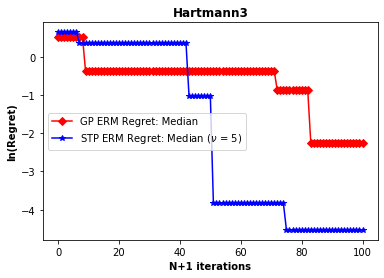

In [74]:
### 8(b). Regret minimisation plot: GP v STP DF 1

title = obj_func

plt.figure()

plt.plot(train_regret_gp_11, label = 'GP ERM Regret: Median', marker = 'D', color = 'Red')
plt.plot(train_regret_stp_df1_4, label = 'STP ERM Regret: Median ' r'($\nu$' ' = {})'.format(df1), marker = '*', color = 'Blue')

plt.title(title, weight = 'bold')
plt.xlabel('N+1 iterations', weight = 'bold') # x-axis label
plt.ylabel('ln(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

plt.show() #visualise


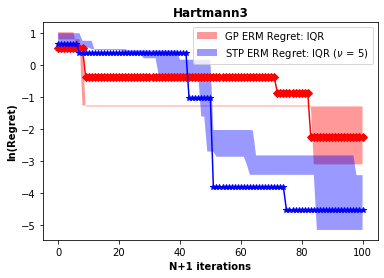

In [75]:
### 8(c). Regret minimisation plot: IQR GP v STP DF 1

title = obj_func

plt.figure()

plt.plot(train_regret_gp_11, marker = 'D', color = 'Red')
plt.plot(train_regret_stp_df1_4, marker = '*', color = 'Blue')

xstar = np.arange(0, 101, step=1)
plt.fill_between(xstar, train_regret_gp_10, train_regret_gp_9, facecolor = 'Red', alpha=0.4, label='GP ERM Regret: IQR')
plt.fill_between(xstar, train_regret_stp_df1_19, train_regret_stp_df1_17, facecolor = 'Blue', alpha=0.4, label='STP ERM Regret: IQR ' r'($\nu$' ' = {})'.format(df1))

plt.title(title, weight = 'bold')
plt.xlabel('N+1 iterations', weight = 'bold') # x-axis label
plt.ylabel('ln(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

plt.show() #visualise


In [76]:
# Iteration1 :

slice1 = 0

gp1 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp1 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp1_results = pd.DataFrame(gp1).sort_values(by=[0], ascending=False)
stp1_results = pd.DataFrame(stp1).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp1 = np.asarray(gp1_results[4:5][0])[0]
median_gp1 = np.asarray(gp1_results[9:10][0])[0]
upper_gp1 = np.asarray(gp1_results[14:15][0])[0]

lower_stp1 = np.asarray(stp1_results[4:5][0])[0]
median_stp1 = np.asarray(stp1_results[9:10][0])[0]
upper_stp1 = np.asarray(stp1_results[14:15][0])[0]

lower_gp1, median_gp1, upper_gp1, lower_stp1, median_stp1, upper_stp1


(1.0151804216478102,
 0.6437141816336722,
 0.1900705128585028,
 1.0151804216478102,
 0.6437141816336722,
 0.1900705128585028)

In [77]:
# Iteration11 :

slice11 = 10

gp11 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp11 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp11_results = pd.DataFrame(gp11).sort_values(by=[0], ascending=False)
stp11_results = pd.DataFrame(stp11).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp11 = np.asarray(gp11_results[4:5][0])[0]
median_gp11 = np.asarray(gp11_results[9:10][0])[0]
upper_gp11 = np.asarray(gp11_results[14:15][0])[0]

lower_stp11 = np.asarray(stp11_results[4:5][0])[0]
median_stp11 = np.asarray(stp11_results[9:10][0])[0]
upper_stp11 = np.asarray(stp11_results[14:15][0])[0]

lower_gp11, median_gp11, upper_gp11, lower_stp11, median_stp11, upper_stp11


(0.3196962203024675,
 -0.15814798990598783,
 -0.7915786790199397,
 0.5770669509474404,
 0.41057361244770374,
 0.12205201674786556)

In [78]:
# Iteration21 :

slice21 = 20

gp21 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp21 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp21_results = pd.DataFrame(gp21).sort_values(by=[0], ascending=False)
stp21_results = pd.DataFrame(stp21).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp21 = np.asarray(gp21_results[4:5][0])[0]
median_gp21 = np.asarray(gp21_results[9:10][0])[0]
upper_gp21 = np.asarray(gp21_results[14:15][0])[0]

lower_stp21 = np.asarray(stp21_results[4:5][0])[0]
median_stp21 = np.asarray(stp21_results[9:10][0])[0]
upper_stp21 = np.asarray(stp21_results[14:15][0])[0]

lower_gp21, median_gp21, upper_gp21, lower_stp21, median_stp21, upper_stp21


(0.04179147794950536,
 -0.44964261591388205,
 -0.9608978268107812,
 0.4579864824999007,
 0.3011905015281919,
 -0.30186284635778476)

In [79]:
# Iteration31 :

slice31 = 30

gp31 = [train_regret_gp_1[slice31],
       train_regret_gp_2[slice31],
       train_regret_gp_3[slice31],
       train_regret_gp_4[slice31],
       train_regret_gp_5[slice31],
       train_regret_gp_6[slice31],
       train_regret_gp_7[slice31],
       train_regret_gp_8[slice31],
       train_regret_gp_9[slice31],
       train_regret_gp_10[slice31],
       train_regret_gp_11[slice31],
       train_regret_gp_12[slice31],
       train_regret_gp_13[slice31],
       train_regret_gp_14[slice31],
       train_regret_gp_15[slice31],
       train_regret_gp_16[slice31],
       train_regret_gp_17[slice31],
       train_regret_gp_18[slice31],
       train_regret_gp_19[slice31],
       train_regret_gp_20[slice31]]

stp31 = [train_regret_stp_df1_1[slice31],
       train_regret_stp_df1_2[slice31],
       train_regret_stp_df1_3[slice31],
       train_regret_stp_df1_4[slice31],
       train_regret_stp_df1_5[slice31],
       train_regret_stp_df1_6[slice31],
       train_regret_stp_df1_7[slice31],
       train_regret_stp_df1_8[slice31],
       train_regret_stp_df1_9[slice31],
       train_regret_stp_df1_10[slice31],
       train_regret_stp_df1_11[slice31],
       train_regret_stp_df1_12[slice31],
       train_regret_stp_df1_13[slice31],
       train_regret_stp_df1_14[slice31],
       train_regret_stp_df1_15[slice31],
       train_regret_stp_df1_16[slice31],
       train_regret_stp_df1_17[slice31],
       train_regret_stp_df1_18[slice31],
       train_regret_stp_df1_19[slice31],
       train_regret_stp_df1_20[slice31]]

gp31_results = pd.DataFrame(gp31).sort_values(by=[0], ascending=False)
stp31_results = pd.DataFrame(stp31).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp31 = np.asarray(gp31_results[4:5][0])[0]
median_gp31 = np.asarray(gp31_results[9:10][0])[0]
upper_gp31 = np.asarray(gp31_results[14:15][0])[0]

lower_stp31 = np.asarray(stp31_results[4:5][0])[0]
median_stp31 = np.asarray(stp31_results[9:10][0])[0]
upper_stp31 = np.asarray(stp31_results[14:15][0])[0]

lower_gp31, median_gp31, upper_gp31, lower_stp31, median_stp31, upper_stp31


(-0.27939392843174166,
 -0.8610365891731478,
 -1.3026705103183764,
 0.32264686419759037,
 0.07693158808641175,
 -0.36528771842242713)

In [80]:
# Iteration41 :

slice41 = 40

gp41 = [train_regret_gp_1[slice41],
       train_regret_gp_2[slice41],
       train_regret_gp_3[slice41],
       train_regret_gp_4[slice41],
       train_regret_gp_5[slice41],
       train_regret_gp_6[slice41],
       train_regret_gp_7[slice41],
       train_regret_gp_8[slice41],
       train_regret_gp_9[slice41],
       train_regret_gp_10[slice41],
       train_regret_gp_11[slice41],
       train_regret_gp_12[slice41],
       train_regret_gp_13[slice41],
       train_regret_gp_14[slice41],
       train_regret_gp_15[slice41],
       train_regret_gp_16[slice41],
       train_regret_gp_17[slice41],
       train_regret_gp_18[slice41],
       train_regret_gp_19[slice41],
       train_regret_gp_20[slice41]]

stp41 = [train_regret_stp_df1_1[slice41],
       train_regret_stp_df1_2[slice41],
       train_regret_stp_df1_3[slice41],
       train_regret_stp_df1_4[slice41],
       train_regret_stp_df1_5[slice41],
       train_regret_stp_df1_6[slice41],
       train_regret_stp_df1_7[slice41],
       train_regret_stp_df1_8[slice41],
       train_regret_stp_df1_9[slice41],
       train_regret_stp_df1_10[slice41],
       train_regret_stp_df1_11[slice41],
       train_regret_stp_df1_12[slice41],
       train_regret_stp_df1_13[slice41],
       train_regret_stp_df1_14[slice41],
       train_regret_stp_df1_15[slice41],
       train_regret_stp_df1_16[slice41],
       train_regret_stp_df1_17[slice41],
       train_regret_stp_df1_18[slice41],
       train_regret_stp_df1_19[slice41],
       train_regret_stp_df1_20[slice41]]

gp41_results = pd.DataFrame(gp41).sort_values(by=[0], ascending=False)
stp41_results = pd.DataFrame(stp41).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp41 = np.asarray(gp41_results[4:5][0])[0]
median_gp41 = np.asarray(gp41_results[9:10][0])[0]
upper_gp41 = np.asarray(gp41_results[14:15][0])[0]

lower_stp41 = np.asarray(stp41_results[4:5][0])[0]
median_stp41 = np.asarray(stp41_results[9:10][0])[0]
upper_stp41 = np.asarray(stp41_results[14:15][0])[0]

lower_gp41, median_gp41, upper_gp41, lower_stp41, median_stp41, upper_stp41


(-0.5689096977358219,
 -0.8610365891731478,
 -1.3685402458234954,
 0.3011905015281919,
 -0.1426231786285531,
 -0.6754040993861657)

In [81]:
# Iteration51 :

slice51 = 50

gp51 = [train_regret_gp_1[slice51],
       train_regret_gp_2[slice51],
       train_regret_gp_3[slice51],
       train_regret_gp_4[slice51],
       train_regret_gp_5[slice51],
       train_regret_gp_6[slice51],
       train_regret_gp_7[slice51],
       train_regret_gp_8[slice51],
       train_regret_gp_9[slice51],
       train_regret_gp_10[slice51],
       train_regret_gp_11[slice51],
       train_regret_gp_12[slice51],
       train_regret_gp_13[slice51],
       train_regret_gp_14[slice51],
       train_regret_gp_15[slice51],
       train_regret_gp_16[slice51],
       train_regret_gp_17[slice51],
       train_regret_gp_18[slice51],
       train_regret_gp_19[slice51],
       train_regret_gp_20[slice51]]

stp51 = [train_regret_stp_df1_1[slice51],
       train_regret_stp_df1_2[slice51],
       train_regret_stp_df1_3[slice51],
       train_regret_stp_df1_4[slice51],
       train_regret_stp_df1_5[slice51],
       train_regret_stp_df1_6[slice51],
       train_regret_stp_df1_7[slice51],
       train_regret_stp_df1_8[slice51],
       train_regret_stp_df1_9[slice51],
       train_regret_stp_df1_10[slice51],
       train_regret_stp_df1_11[slice51],
       train_regret_stp_df1_12[slice51],
       train_regret_stp_df1_13[slice51],
       train_regret_stp_df1_14[slice51],
       train_regret_stp_df1_15[slice51],
       train_regret_stp_df1_16[slice51],
       train_regret_stp_df1_17[slice51],
       train_regret_stp_df1_18[slice51],
       train_regret_stp_df1_19[slice51],
       train_regret_stp_df1_20[slice51]]

gp51_results = pd.DataFrame(gp51).sort_values(by=[0], ascending=False)
stp51_results = pd.DataFrame(stp51).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp51 = np.asarray(gp51_results[4:5][0])[0]
median_gp51 = np.asarray(gp51_results[9:10][0])[0]
upper_gp51 = np.asarray(gp51_results[14:15][0])[0]

lower_stp51 = np.asarray(stp51_results[4:5][0])[0]
median_stp51 = np.asarray(stp51_results[9:10][0])[0]
upper_stp51 = np.asarray(stp51_results[14:15][0])[0]

lower_gp51, median_gp51, upper_gp51, lower_stp51, median_stp51, upper_stp51


(-0.5689096977358219,
 -1.229927882130823,
 -1.4636762261000498,
 -0.8883062751467867,
 -2.4646613494202945,
 -3.362936333242479)

In [82]:
# Iteration61 :

slice61 = 60

gp61 = [train_regret_gp_1[slice61],
       train_regret_gp_2[slice61],
       train_regret_gp_3[slice61],
       train_regret_gp_4[slice61],
       train_regret_gp_5[slice61],
       train_regret_gp_6[slice61],
       train_regret_gp_7[slice61],
       train_regret_gp_8[slice61],
       train_regret_gp_9[slice61],
       train_regret_gp_10[slice61],
       train_regret_gp_11[slice61],
       train_regret_gp_12[slice61],
       train_regret_gp_13[slice61],
       train_regret_gp_14[slice61],
       train_regret_gp_15[slice61],
       train_regret_gp_16[slice61],
       train_regret_gp_17[slice61],
       train_regret_gp_18[slice61],
       train_regret_gp_19[slice61],
       train_regret_gp_20[slice61]]

stp61 = [train_regret_stp_df1_1[slice61],
       train_regret_stp_df1_2[slice61],
       train_regret_stp_df1_3[slice61],
       train_regret_stp_df1_4[slice61],
       train_regret_stp_df1_5[slice61],
       train_regret_stp_df1_6[slice61],
       train_regret_stp_df1_7[slice61],
       train_regret_stp_df1_8[slice61],
       train_regret_stp_df1_9[slice61],
       train_regret_stp_df1_10[slice61],
       train_regret_stp_df1_11[slice61],
       train_regret_stp_df1_12[slice61],
       train_regret_stp_df1_13[slice61],
       train_regret_stp_df1_14[slice61],
       train_regret_stp_df1_15[slice61],
       train_regret_stp_df1_16[slice61],
       train_regret_stp_df1_17[slice61],
       train_regret_stp_df1_18[slice61],
       train_regret_stp_df1_19[slice61],
       train_regret_stp_df1_20[slice61]]

gp61_results = pd.DataFrame(gp61).sort_values(by=[0], ascending=False)
stp61_results = pd.DataFrame(stp61).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp61 = np.asarray(gp61_results[4:5][0])[0]
median_gp61 = np.asarray(gp61_results[9:10][0])[0]
upper_gp61 = np.asarray(gp61_results[14:15][0])[0]

lower_stp61 = np.asarray(stp61_results[4:5][0])[0]
median_stp61 = np.asarray(stp61_results[9:10][0])[0]
upper_stp61 = np.asarray(stp61_results[14:15][0])[0]

lower_gp61, median_gp61, upper_gp61, lower_stp61, median_stp61, upper_stp61


(-0.5689096977358219,
 -1.272451658020414,
 -1.7930777665900184,
 -2.4569254614048788,
 -3.3520105093281267,
 -3.8283661538674836)

In [83]:
# Iteration71 :

slice71 = 70

gp71 = [train_regret_gp_1[slice71],
       train_regret_gp_2[slice71],
       train_regret_gp_3[slice71],
       train_regret_gp_4[slice71],
       train_regret_gp_5[slice71],
       train_regret_gp_6[slice71],
       train_regret_gp_7[slice71],
       train_regret_gp_8[slice71],
       train_regret_gp_9[slice71],
       train_regret_gp_10[slice71],
       train_regret_gp_11[slice71],
       train_regret_gp_12[slice71],
       train_regret_gp_13[slice71],
       train_regret_gp_14[slice71],
       train_regret_gp_15[slice71],
       train_regret_gp_16[slice71],
       train_regret_gp_17[slice71],
       train_regret_gp_18[slice71],
       train_regret_gp_19[slice71],
       train_regret_gp_20[slice71]]

stp71 = [train_regret_stp_df1_1[slice71],
       train_regret_stp_df1_2[slice71],
       train_regret_stp_df1_3[slice71],
       train_regret_stp_df1_4[slice71],
       train_regret_stp_df1_5[slice71],
       train_regret_stp_df1_6[slice71],
       train_regret_stp_df1_7[slice71],
       train_regret_stp_df1_8[slice71],
       train_regret_stp_df1_9[slice71],
       train_regret_stp_df1_10[slice71],
       train_regret_stp_df1_11[slice71],
       train_regret_stp_df1_12[slice71],
       train_regret_stp_df1_13[slice71],
       train_regret_stp_df1_14[slice71],
       train_regret_stp_df1_15[slice71],
       train_regret_stp_df1_16[slice71],
       train_regret_stp_df1_17[slice71],
       train_regret_stp_df1_18[slice71],
       train_regret_stp_df1_19[slice71],
       train_regret_stp_df1_20[slice71]]

gp71_results = pd.DataFrame(gp71).sort_values(by=[0], ascending=False)
stp71_results = pd.DataFrame(stp71).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp71 = np.asarray(gp71_results[4:5][0])[0]
median_gp71 = np.asarray(gp71_results[9:10][0])[0]
upper_gp71 = np.asarray(gp71_results[14:15][0])[0]

lower_stp71 = np.asarray(stp71_results[4:5][0])[0]
median_stp71 = np.asarray(stp71_results[9:10][0])[0]
upper_stp71 = np.asarray(stp71_results[14:15][0])[0]

lower_gp71, median_gp71, upper_gp71, lower_stp71, median_stp71, upper_stp71


(-0.7995919632532221,
 -1.4636762261000498,
 -3.045118598435262,
 -3.1476953032824833,
 -3.431979607755546,
 -4.2553890088954525)

In [84]:
# Iteration81 :

slice81 = 80

gp81 = [train_regret_gp_1[slice81],
       train_regret_gp_2[slice81],
       train_regret_gp_3[slice81],
       train_regret_gp_4[slice81],
       train_regret_gp_5[slice81],
       train_regret_gp_6[slice81],
       train_regret_gp_7[slice81],
       train_regret_gp_8[slice81],
       train_regret_gp_9[slice81],
       train_regret_gp_10[slice81],
       train_regret_gp_11[slice81],
       train_regret_gp_12[slice81],
       train_regret_gp_13[slice81],
       train_regret_gp_14[slice81],
       train_regret_gp_15[slice81],
       train_regret_gp_16[slice81],
       train_regret_gp_17[slice81],
       train_regret_gp_18[slice81],
       train_regret_gp_19[slice81],
       train_regret_gp_20[slice81]]

stp81 = [train_regret_stp_df1_1[slice81],
       train_regret_stp_df1_2[slice81],
       train_regret_stp_df1_3[slice81],
       train_regret_stp_df1_4[slice81],
       train_regret_stp_df1_5[slice81],
       train_regret_stp_df1_6[slice81],
       train_regret_stp_df1_7[slice81],
       train_regret_stp_df1_8[slice81],
       train_regret_stp_df1_9[slice81],
       train_regret_stp_df1_10[slice81],
       train_regret_stp_df1_11[slice81],
       train_regret_stp_df1_12[slice81],
       train_regret_stp_df1_13[slice81],
       train_regret_stp_df1_14[slice81],
       train_regret_stp_df1_15[slice81],
       train_regret_stp_df1_16[slice81],
       train_regret_stp_df1_17[slice81],
       train_regret_stp_df1_18[slice81],
       train_regret_stp_df1_19[slice81],
       train_regret_stp_df1_20[slice81]]

gp81_results = pd.DataFrame(gp81).sort_values(by=[0], ascending=False)
stp81_results = pd.DataFrame(stp81).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp81 = np.asarray(gp81_results[4:5][0])[0]
median_gp81 = np.asarray(gp81_results[9:10][0])[0]
upper_gp81 = np.asarray(gp81_results[14:15][0])[0]

lower_stp81 = np.asarray(stp81_results[4:5][0])[0]
median_stp81 = np.asarray(stp81_results[9:10][0])[0]
upper_stp81 = np.asarray(stp81_results[14:15][0])[0]

lower_gp81, median_gp81, upper_gp81, lower_stp81, median_stp81, upper_stp81

(-1.0114680702273304,
 -1.4636762261000498,
 -3.045118598435262,
 -3.1476953032824833,
 -3.4368960088117655,
 -4.5410472444588335)

In [85]:
# Iteration91 :

slice1 = 90

gp91 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp91 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp91_results = pd.DataFrame(gp91).sort_values(by=[0], ascending=False)
stp91_results = pd.DataFrame(stp91).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp91 = np.asarray(gp91_results[4:5][0])[0]
median_gp91 = np.asarray(gp91_results[9:10][0])[0]
upper_gp91 = np.asarray(gp91_results[14:15][0])[0]

lower_stp91 = np.asarray(stp91_results[4:5][0])[0]
median_stp91 = np.asarray(stp91_results[9:10][0])[0]
upper_stp91 = np.asarray(stp91_results[14:15][0])[0]

lower_gp91, median_gp91, upper_gp91, lower_stp91, median_stp91, upper_stp91


(-1.2612768783466197,
 -2.045849485037573,
 -3.1102391432412486,
 -3.4246371929521673,
 -4.15251328888983,
 -5.152773175058427)

In [86]:
# Iteration101 :

slice1 = 100

gp101 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp101 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp101_results = pd.DataFrame(gp101).sort_values(by=[0], ascending=False)
stp101_results = pd.DataFrame(stp101).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp101 = np.asarray(gp101_results[4:5][0])[0]
median_gp101 = np.asarray(gp101_results[9:10][0])[0]
upper_gp101 = np.asarray(gp101_results[14:15][0])[0]

lower_stp101 = np.asarray(stp101_results[4:5][0])[0]
median_stp101 = np.asarray(stp101_results[9:10][0])[0]
upper_stp101 = np.asarray(stp101_results[14:15][0])[0]

lower_gp101, median_gp101, upper_gp101, lower_stp101, median_stp101, upper_stp101


(-1.3026705103183764,
 -2.245260434028356,
 -3.1102391432412486,
 -3.4471893899986874,
 -4.528867319093919,
 -5.1569445430649665)

In [87]:
# Iteration2 :

slice1 = 1

gp2 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp2 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp2_results = pd.DataFrame(gp2).sort_values(by=[0], ascending=False)
stp2_results = pd.DataFrame(stp2).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp2 = np.asarray(gp2_results[4:5][0])[0]
median_gp2 = np.asarray(gp2_results[9:10][0])[0]
upper_gp2 = np.asarray(gp2_results[14:15][0])[0]

lower_stp2 = np.asarray(stp2_results[4:5][0])[0]
median_stp2 = np.asarray(stp2_results[9:10][0])[0]
upper_stp2 = np.asarray(stp2_results[14:15][0])[0]


In [88]:
# Iteration12 :

slice11 = 11

gp12 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp12 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp12_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp12_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp12 = np.asarray(gp12_results[4:5][0])[0]
median_gp12 = np.asarray(gp12_results[9:10][0])[0]
upper_gp12 = np.asarray(gp12_results[14:15][0])[0]

lower_stp12 = np.asarray(stp12_results[4:5][0])[0]
median_stp12 = np.asarray(stp12_results[9:10][0])[0]
upper_stp12 = np.asarray(stp12_results[14:15][0])[0]


In [89]:
# Iteration22 :

slice21 = 21

gp22 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp22 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp22_results = pd.DataFrame(gp22).sort_values(by=[0], ascending=False)
stp22_results = pd.DataFrame(stp22).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp22 = np.asarray(gp22_results[4:5][0])[0]
median_gp22 = np.asarray(gp22_results[9:10][0])[0]
upper_gp22 = np.asarray(gp22_results[14:15][0])[0]

lower_stp22 = np.asarray(stp22_results[4:5][0])[0]
median_stp22 = np.asarray(stp22_results[9:10][0])[0]
upper_stp22 = np.asarray(stp22_results[14:15][0])[0]


In [90]:
# Iteration32 :

slice31 = 31

gp32 = [train_regret_gp_1[slice31],
       train_regret_gp_2[slice31],
       train_regret_gp_3[slice31],
       train_regret_gp_4[slice31],
       train_regret_gp_5[slice31],
       train_regret_gp_6[slice31],
       train_regret_gp_7[slice31],
       train_regret_gp_8[slice31],
       train_regret_gp_9[slice31],
       train_regret_gp_10[slice31],
       train_regret_gp_11[slice31],
       train_regret_gp_12[slice31],
       train_regret_gp_13[slice31],
       train_regret_gp_14[slice31],
       train_regret_gp_15[slice31],
       train_regret_gp_16[slice31],
       train_regret_gp_17[slice31],
       train_regret_gp_18[slice31],
       train_regret_gp_19[slice31],
       train_regret_gp_20[slice31]]

stp32 = [train_regret_stp_df1_1[slice31],
       train_regret_stp_df1_2[slice31],
       train_regret_stp_df1_3[slice31],
       train_regret_stp_df1_4[slice31],
       train_regret_stp_df1_5[slice31],
       train_regret_stp_df1_6[slice31],
       train_regret_stp_df1_7[slice31],
       train_regret_stp_df1_8[slice31],
       train_regret_stp_df1_9[slice31],
       train_regret_stp_df1_10[slice31],
       train_regret_stp_df1_11[slice31],
       train_regret_stp_df1_12[slice31],
       train_regret_stp_df1_13[slice31],
       train_regret_stp_df1_14[slice31],
       train_regret_stp_df1_15[slice31],
       train_regret_stp_df1_16[slice31],
       train_regret_stp_df1_17[slice31],
       train_regret_stp_df1_18[slice31],
       train_regret_stp_df1_19[slice31],
       train_regret_stp_df1_20[slice31]]

gp32_results = pd.DataFrame(gp32).sort_values(by=[0], ascending=False)
stp32_results = pd.DataFrame(stp32).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp32 = np.asarray(gp32_results[4:5][0])[0]
median_gp32 = np.asarray(gp32_results[9:10][0])[0]
upper_gp32 = np.asarray(gp32_results[14:15][0])[0]

lower_stp32 = np.asarray(stp32_results[4:5][0])[0]
median_stp32 = np.asarray(stp32_results[9:10][0])[0]
upper_stp32 = np.asarray(stp32_results[14:15][0])[0]


In [91]:
# Iteration42 :

slice41 = 41

gp42 = [train_regret_gp_1[slice41],
       train_regret_gp_2[slice41],
       train_regret_gp_3[slice41],
       train_regret_gp_4[slice41],
       train_regret_gp_5[slice41],
       train_regret_gp_6[slice41],
       train_regret_gp_7[slice41],
       train_regret_gp_8[slice41],
       train_regret_gp_9[slice41],
       train_regret_gp_10[slice41],
       train_regret_gp_11[slice41],
       train_regret_gp_12[slice41],
       train_regret_gp_13[slice41],
       train_regret_gp_14[slice41],
       train_regret_gp_15[slice41],
       train_regret_gp_16[slice41],
       train_regret_gp_17[slice41],
       train_regret_gp_18[slice41],
       train_regret_gp_19[slice41],
       train_regret_gp_20[slice41]]

stp42 = [train_regret_stp_df1_1[slice41],
       train_regret_stp_df1_2[slice41],
       train_regret_stp_df1_3[slice41],
       train_regret_stp_df1_4[slice41],
       train_regret_stp_df1_5[slice41],
       train_regret_stp_df1_6[slice41],
       train_regret_stp_df1_7[slice41],
       train_regret_stp_df1_8[slice41],
       train_regret_stp_df1_9[slice41],
       train_regret_stp_df1_10[slice41],
       train_regret_stp_df1_11[slice41],
       train_regret_stp_df1_12[slice41],
       train_regret_stp_df1_13[slice41],
       train_regret_stp_df1_14[slice41],
       train_regret_stp_df1_15[slice41],
       train_regret_stp_df1_16[slice41],
       train_regret_stp_df1_17[slice41],
       train_regret_stp_df1_18[slice41],
       train_regret_stp_df1_19[slice41],
       train_regret_stp_df1_20[slice41]]

gp42_results = pd.DataFrame(gp42).sort_values(by=[0], ascending=False)
stp42_results = pd.DataFrame(stp42).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp42 = np.asarray(gp42_results[4:5][0])[0]
median_gp42 = np.asarray(gp42_results[9:10][0])[0]
upper_gp42 = np.asarray(gp42_results[14:15][0])[0]

lower_stp42 = np.asarray(stp42_results[4:5][0])[0]
median_stp42 = np.asarray(stp42_results[9:10][0])[0]
upper_stp42 = np.asarray(stp42_results[14:15][0])[0]


In [92]:
# Iteration52 :

slice51 = 51

gp52 = [train_regret_gp_1[slice51],
       train_regret_gp_2[slice51],
       train_regret_gp_3[slice51],
       train_regret_gp_4[slice51],
       train_regret_gp_5[slice51],
       train_regret_gp_6[slice51],
       train_regret_gp_7[slice51],
       train_regret_gp_8[slice51],
       train_regret_gp_9[slice51],
       train_regret_gp_10[slice51],
       train_regret_gp_11[slice51],
       train_regret_gp_12[slice51],
       train_regret_gp_13[slice51],
       train_regret_gp_14[slice51],
       train_regret_gp_15[slice51],
       train_regret_gp_16[slice51],
       train_regret_gp_17[slice51],
       train_regret_gp_18[slice51],
       train_regret_gp_19[slice51],
       train_regret_gp_20[slice51]]

stp52 = [train_regret_stp_df1_1[slice51],
       train_regret_stp_df1_2[slice51],
       train_regret_stp_df1_3[slice51],
       train_regret_stp_df1_4[slice51],
       train_regret_stp_df1_5[slice51],
       train_regret_stp_df1_6[slice51],
       train_regret_stp_df1_7[slice51],
       train_regret_stp_df1_8[slice51],
       train_regret_stp_df1_9[slice51],
       train_regret_stp_df1_10[slice51],
       train_regret_stp_df1_11[slice51],
       train_regret_stp_df1_12[slice51],
       train_regret_stp_df1_13[slice51],
       train_regret_stp_df1_14[slice51],
       train_regret_stp_df1_15[slice51],
       train_regret_stp_df1_16[slice51],
       train_regret_stp_df1_17[slice51],
       train_regret_stp_df1_18[slice51],
       train_regret_stp_df1_19[slice51],
       train_regret_stp_df1_20[slice51]]

gp52_results = pd.DataFrame(gp52).sort_values(by=[0], ascending=False)
stp52_results = pd.DataFrame(stp52).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp52 = np.asarray(gp52_results[4:5][0])[0]
median_gp52 = np.asarray(gp52_results[9:10][0])[0]
upper_gp52 = np.asarray(gp52_results[14:15][0])[0]

lower_stp52 = np.asarray(stp52_results[4:5][0])[0]
median_stp52 = np.asarray(stp52_results[9:10][0])[0]
upper_stp52 = np.asarray(stp52_results[14:15][0])[0]


In [93]:
# Iteration62 :

slice61 = 61

gp62 = [train_regret_gp_1[slice61],
       train_regret_gp_2[slice61],
       train_regret_gp_3[slice61],
       train_regret_gp_4[slice61],
       train_regret_gp_5[slice61],
       train_regret_gp_6[slice61],
       train_regret_gp_7[slice61],
       train_regret_gp_8[slice61],
       train_regret_gp_9[slice61],
       train_regret_gp_10[slice61],
       train_regret_gp_11[slice61],
       train_regret_gp_12[slice61],
       train_regret_gp_13[slice61],
       train_regret_gp_14[slice61],
       train_regret_gp_15[slice61],
       train_regret_gp_16[slice61],
       train_regret_gp_17[slice61],
       train_regret_gp_18[slice61],
       train_regret_gp_19[slice61],
       train_regret_gp_20[slice61]]

stp62 = [train_regret_stp_df1_1[slice61],
       train_regret_stp_df1_2[slice61],
       train_regret_stp_df1_3[slice61],
       train_regret_stp_df1_4[slice61],
       train_regret_stp_df1_5[slice61],
       train_regret_stp_df1_6[slice61],
       train_regret_stp_df1_7[slice61],
       train_regret_stp_df1_8[slice61],
       train_regret_stp_df1_9[slice61],
       train_regret_stp_df1_10[slice61],
       train_regret_stp_df1_11[slice61],
       train_regret_stp_df1_12[slice61],
       train_regret_stp_df1_13[slice61],
       train_regret_stp_df1_14[slice61],
       train_regret_stp_df1_15[slice61],
       train_regret_stp_df1_16[slice61],
       train_regret_stp_df1_17[slice61],
       train_regret_stp_df1_18[slice61],
       train_regret_stp_df1_19[slice61],
       train_regret_stp_df1_20[slice61]]

gp62_results = pd.DataFrame(gp62).sort_values(by=[0], ascending=False)
stp62_results = pd.DataFrame(stp62).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp62 = np.asarray(gp62_results[4:5][0])[0]
median_gp62 = np.asarray(gp62_results[9:10][0])[0]
upper_gp62 = np.asarray(gp62_results[14:15][0])[0]

lower_stp62 = np.asarray(stp62_results[4:5][0])[0]
median_stp62 = np.asarray(stp62_results[9:10][0])[0]
upper_stp62 = np.asarray(stp62_results[14:15][0])[0]


In [94]:
# Iteration72 :

slice71 = 71

gp72 = [train_regret_gp_1[slice71],
       train_regret_gp_2[slice71],
       train_regret_gp_3[slice71],
       train_regret_gp_4[slice71],
       train_regret_gp_5[slice71],
       train_regret_gp_6[slice71],
       train_regret_gp_7[slice71],
       train_regret_gp_8[slice71],
       train_regret_gp_9[slice71],
       train_regret_gp_10[slice71],
       train_regret_gp_11[slice71],
       train_regret_gp_12[slice71],
       train_regret_gp_13[slice71],
       train_regret_gp_14[slice71],
       train_regret_gp_15[slice71],
       train_regret_gp_16[slice71],
       train_regret_gp_17[slice71],
       train_regret_gp_18[slice71],
       train_regret_gp_19[slice71],
       train_regret_gp_20[slice71]]

stp72 = [train_regret_stp_df1_1[slice71],
       train_regret_stp_df1_2[slice71],
       train_regret_stp_df1_3[slice71],
       train_regret_stp_df1_4[slice71],
       train_regret_stp_df1_5[slice71],
       train_regret_stp_df1_6[slice71],
       train_regret_stp_df1_7[slice71],
       train_regret_stp_df1_8[slice71],
       train_regret_stp_df1_9[slice71],
       train_regret_stp_df1_10[slice71],
       train_regret_stp_df1_11[slice71],
       train_regret_stp_df1_12[slice71],
       train_regret_stp_df1_13[slice71],
       train_regret_stp_df1_14[slice71],
       train_regret_stp_df1_15[slice71],
       train_regret_stp_df1_16[slice71],
       train_regret_stp_df1_17[slice71],
       train_regret_stp_df1_18[slice71],
       train_regret_stp_df1_19[slice71],
       train_regret_stp_df1_20[slice71]]

gp72_results = pd.DataFrame(gp72).sort_values(by=[0], ascending=False)
stp72_results = pd.DataFrame(stp72).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp72 = np.asarray(gp72_results[4:5][0])[0]
median_gp72 = np.asarray(gp72_results[9:10][0])[0]
upper_gp72 = np.asarray(gp72_results[14:15][0])[0]

lower_stp72 = np.asarray(stp72_results[4:5][0])[0]
median_stp72 = np.asarray(stp72_results[9:10][0])[0]
upper_stp72 = np.asarray(stp72_results[14:15][0])[0]


In [95]:
# Iteration82 :

slice81 = 81

gp82 = [train_regret_gp_1[slice81],
       train_regret_gp_2[slice81],
       train_regret_gp_3[slice81],
       train_regret_gp_4[slice81],
       train_regret_gp_5[slice81],
       train_regret_gp_6[slice81],
       train_regret_gp_7[slice81],
       train_regret_gp_8[slice81],
       train_regret_gp_9[slice81],
       train_regret_gp_10[slice81],
       train_regret_gp_11[slice81],
       train_regret_gp_12[slice81],
       train_regret_gp_13[slice81],
       train_regret_gp_14[slice81],
       train_regret_gp_15[slice81],
       train_regret_gp_16[slice81],
       train_regret_gp_17[slice81],
       train_regret_gp_18[slice81],
       train_regret_gp_19[slice81],
       train_regret_gp_20[slice81]]

stp82 = [train_regret_stp_df1_1[slice81],
       train_regret_stp_df1_2[slice81],
       train_regret_stp_df1_3[slice81],
       train_regret_stp_df1_4[slice81],
       train_regret_stp_df1_5[slice81],
       train_regret_stp_df1_6[slice81],
       train_regret_stp_df1_7[slice81],
       train_regret_stp_df1_8[slice81],
       train_regret_stp_df1_9[slice81],
       train_regret_stp_df1_10[slice81],
       train_regret_stp_df1_11[slice81],
       train_regret_stp_df1_12[slice81],
       train_regret_stp_df1_13[slice81],
       train_regret_stp_df1_14[slice81],
       train_regret_stp_df1_15[slice81],
       train_regret_stp_df1_16[slice81],
       train_regret_stp_df1_17[slice81],
       train_regret_stp_df1_18[slice81],
       train_regret_stp_df1_19[slice81],
       train_regret_stp_df1_20[slice81]]

gp82_results = pd.DataFrame(gp82).sort_values(by=[0], ascending=False)
stp82_results = pd.DataFrame(stp82).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp82 = np.asarray(gp82_results[4:5][0])[0]
median_gp82 = np.asarray(gp82_results[9:10][0])[0]
upper_gp82 = np.asarray(gp82_results[14:15][0])[0]

lower_stp82 = np.asarray(stp82_results[4:5][0])[0]
median_stp82 = np.asarray(stp82_results[9:10][0])[0]
upper_stp82 = np.asarray(stp82_results[14:15][0])[0]


In [96]:
# Iteration92 :

slice1 = 91

gp92 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp92 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp92_results = pd.DataFrame(gp92).sort_values(by=[0], ascending=False)
stp92_results = pd.DataFrame(stp92).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp92 = np.asarray(gp92_results[4:5][0])[0]
median_gp92 = np.asarray(gp92_results[9:10][0])[0]
upper_gp92 = np.asarray(gp92_results[14:15][0])[0]

lower_stp92 = np.asarray(stp92_results[4:5][0])[0]
median_stp92 = np.asarray(stp92_results[9:10][0])[0]
upper_stp92 = np.asarray(stp92_results[14:15][0])[0]



In [97]:
# Iteration3 :

slice1 = 2

gp3 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp3 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp3_results = pd.DataFrame(gp3).sort_values(by=[0], ascending=False)
stp3_results = pd.DataFrame(stp3).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp3 = np.asarray(gp3_results[4:5][0])[0]
median_gp3 = np.asarray(gp3_results[9:10][0])[0]
upper_gp3 = np.asarray(gp3_results[14:15][0])[0]

lower_stp3 = np.asarray(stp3_results[4:5][0])[0]
median_stp3 = np.asarray(stp3_results[9:10][0])[0]
upper_stp3 = np.asarray(stp3_results[14:15][0])[0]


In [98]:
# Iteration13 :

slice11 = 12

gp13 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp13 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp13_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp13_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp13 = np.asarray(gp13_results[4:5][0])[0]
median_gp13 = np.asarray(gp13_results[9:10][0])[0]
upper_gp13 = np.asarray(gp13_results[14:15][0])[0]

lower_stp13 = np.asarray(stp13_results[4:5][0])[0]
median_stp13 = np.asarray(stp13_results[9:10][0])[0]
upper_stp13 = np.asarray(stp13_results[14:15][0])[0]


In [99]:
# Iteration23 :

slice21 = 22

gp23 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp23 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp23_results = pd.DataFrame(gp23).sort_values(by=[0], ascending=False)
stp23_results = pd.DataFrame(stp23).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp23 = np.asarray(gp23_results[4:5][0])[0]
median_gp23 = np.asarray(gp23_results[9:10][0])[0]
upper_gp23 = np.asarray(gp23_results[14:15][0])[0]

lower_stp23 = np.asarray(stp23_results[4:5][0])[0]
median_stp23 = np.asarray(stp23_results[9:10][0])[0]
upper_stp23 = np.asarray(stp23_results[14:15][0])[0]


In [100]:
# Iteration33 :

slice31 = 32

gp33 = [train_regret_gp_1[slice31],
       train_regret_gp_2[slice31],
       train_regret_gp_3[slice31],
       train_regret_gp_4[slice31],
       train_regret_gp_5[slice31],
       train_regret_gp_6[slice31],
       train_regret_gp_7[slice31],
       train_regret_gp_8[slice31],
       train_regret_gp_9[slice31],
       train_regret_gp_10[slice31],
       train_regret_gp_11[slice31],
       train_regret_gp_12[slice31],
       train_regret_gp_13[slice31],
       train_regret_gp_14[slice31],
       train_regret_gp_15[slice31],
       train_regret_gp_16[slice31],
       train_regret_gp_17[slice31],
       train_regret_gp_18[slice31],
       train_regret_gp_19[slice31],
       train_regret_gp_20[slice31]]

stp33 = [train_regret_stp_df1_1[slice31],
       train_regret_stp_df1_2[slice31],
       train_regret_stp_df1_3[slice31],
       train_regret_stp_df1_4[slice31],
       train_regret_stp_df1_5[slice31],
       train_regret_stp_df1_6[slice31],
       train_regret_stp_df1_7[slice31],
       train_regret_stp_df1_8[slice31],
       train_regret_stp_df1_9[slice31],
       train_regret_stp_df1_10[slice31],
       train_regret_stp_df1_11[slice31],
       train_regret_stp_df1_12[slice31],
       train_regret_stp_df1_13[slice31],
       train_regret_stp_df1_14[slice31],
       train_regret_stp_df1_15[slice31],
       train_regret_stp_df1_16[slice31],
       train_regret_stp_df1_17[slice31],
       train_regret_stp_df1_18[slice31],
       train_regret_stp_df1_19[slice31],
       train_regret_stp_df1_20[slice31]]

gp33_results = pd.DataFrame(gp33).sort_values(by=[0], ascending=False)
stp33_results = pd.DataFrame(stp33).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp33 = np.asarray(gp33_results[4:5][0])[0]
median_gp33 = np.asarray(gp33_results[9:10][0])[0]
upper_gp33 = np.asarray(gp33_results[14:15][0])[0]

lower_stp33 = np.asarray(stp33_results[4:5][0])[0]
median_stp33 = np.asarray(stp33_results[9:10][0])[0]
upper_stp33 = np.asarray(stp33_results[14:15][0])[0]


In [101]:
# Iteration43 :

slice41 = 42

gp43 = [train_regret_gp_1[slice41],
       train_regret_gp_2[slice41],
       train_regret_gp_3[slice41],
       train_regret_gp_4[slice41],
       train_regret_gp_5[slice41],
       train_regret_gp_6[slice41],
       train_regret_gp_7[slice41],
       train_regret_gp_8[slice41],
       train_regret_gp_9[slice41],
       train_regret_gp_10[slice41],
       train_regret_gp_11[slice41],
       train_regret_gp_12[slice41],
       train_regret_gp_13[slice41],
       train_regret_gp_14[slice41],
       train_regret_gp_15[slice41],
       train_regret_gp_16[slice41],
       train_regret_gp_17[slice41],
       train_regret_gp_18[slice41],
       train_regret_gp_19[slice41],
       train_regret_gp_20[slice41]]

stp43 = [train_regret_stp_df1_1[slice41],
       train_regret_stp_df1_2[slice41],
       train_regret_stp_df1_3[slice41],
       train_regret_stp_df1_4[slice41],
       train_regret_stp_df1_5[slice41],
       train_regret_stp_df1_6[slice41],
       train_regret_stp_df1_7[slice41],
       train_regret_stp_df1_8[slice41],
       train_regret_stp_df1_9[slice41],
       train_regret_stp_df1_10[slice41],
       train_regret_stp_df1_11[slice41],
       train_regret_stp_df1_12[slice41],
       train_regret_stp_df1_13[slice41],
       train_regret_stp_df1_14[slice41],
       train_regret_stp_df1_15[slice41],
       train_regret_stp_df1_16[slice41],
       train_regret_stp_df1_17[slice41],
       train_regret_stp_df1_18[slice41],
       train_regret_stp_df1_19[slice41],
       train_regret_stp_df1_20[slice41]]

gp43_results = pd.DataFrame(gp43).sort_values(by=[0], ascending=False)
stp43_results = pd.DataFrame(stp43).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp43 = np.asarray(gp43_results[4:5][0])[0]
median_gp43 = np.asarray(gp43_results[9:10][0])[0]
upper_gp43 = np.asarray(gp43_results[14:15][0])[0]

lower_stp43 = np.asarray(stp43_results[4:5][0])[0]
median_stp43 = np.asarray(stp43_results[9:10][0])[0]
upper_stp43 = np.asarray(stp43_results[14:15][0])[0]


In [102]:
# Iteration53 :

slice51 = 52

gp53 = [train_regret_gp_1[slice51],
       train_regret_gp_2[slice51],
       train_regret_gp_3[slice51],
       train_regret_gp_4[slice51],
       train_regret_gp_5[slice51],
       train_regret_gp_6[slice51],
       train_regret_gp_7[slice51],
       train_regret_gp_8[slice51],
       train_regret_gp_9[slice51],
       train_regret_gp_10[slice51],
       train_regret_gp_11[slice51],
       train_regret_gp_12[slice51],
       train_regret_gp_13[slice51],
       train_regret_gp_14[slice51],
       train_regret_gp_15[slice51],
       train_regret_gp_16[slice51],
       train_regret_gp_17[slice51],
       train_regret_gp_18[slice51],
       train_regret_gp_19[slice51],
       train_regret_gp_20[slice51]]

stp53 = [train_regret_stp_df1_1[slice51],
       train_regret_stp_df1_2[slice51],
       train_regret_stp_df1_3[slice51],
       train_regret_stp_df1_4[slice51],
       train_regret_stp_df1_5[slice51],
       train_regret_stp_df1_6[slice51],
       train_regret_stp_df1_7[slice51],
       train_regret_stp_df1_8[slice51],
       train_regret_stp_df1_9[slice51],
       train_regret_stp_df1_10[slice51],
       train_regret_stp_df1_11[slice51],
       train_regret_stp_df1_12[slice51],
       train_regret_stp_df1_13[slice51],
       train_regret_stp_df1_14[slice51],
       train_regret_stp_df1_15[slice51],
       train_regret_stp_df1_16[slice51],
       train_regret_stp_df1_17[slice51],
       train_regret_stp_df1_18[slice51],
       train_regret_stp_df1_19[slice51],
       train_regret_stp_df1_20[slice51]]

gp53_results = pd.DataFrame(gp53).sort_values(by=[0], ascending=False)
stp53_results = pd.DataFrame(stp53).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp53 = np.asarray(gp53_results[4:5][0])[0]
median_gp53 = np.asarray(gp53_results[9:10][0])[0]
upper_gp53 = np.asarray(gp53_results[14:15][0])[0]

lower_stp53 = np.asarray(stp53_results[4:5][0])[0]
median_stp53 = np.asarray(stp53_results[9:10][0])[0]
upper_stp53 = np.asarray(stp53_results[14:15][0])[0]


In [103]:
# Iteration63 :

slice61 = 62

gp63 = [train_regret_gp_1[slice61],
       train_regret_gp_2[slice61],
       train_regret_gp_3[slice61],
       train_regret_gp_4[slice61],
       train_regret_gp_5[slice61],
       train_regret_gp_6[slice61],
       train_regret_gp_7[slice61],
       train_regret_gp_8[slice61],
       train_regret_gp_9[slice61],
       train_regret_gp_10[slice61],
       train_regret_gp_11[slice61],
       train_regret_gp_12[slice61],
       train_regret_gp_13[slice61],
       train_regret_gp_14[slice61],
       train_regret_gp_15[slice61],
       train_regret_gp_16[slice61],
       train_regret_gp_17[slice61],
       train_regret_gp_18[slice61],
       train_regret_gp_19[slice61],
       train_regret_gp_20[slice61]]

stp63 = [train_regret_stp_df1_1[slice61],
       train_regret_stp_df1_2[slice61],
       train_regret_stp_df1_3[slice61],
       train_regret_stp_df1_4[slice61],
       train_regret_stp_df1_5[slice61],
       train_regret_stp_df1_6[slice61],
       train_regret_stp_df1_7[slice61],
       train_regret_stp_df1_8[slice61],
       train_regret_stp_df1_9[slice61],
       train_regret_stp_df1_10[slice61],
       train_regret_stp_df1_11[slice61],
       train_regret_stp_df1_12[slice61],
       train_regret_stp_df1_13[slice61],
       train_regret_stp_df1_14[slice61],
       train_regret_stp_df1_15[slice61],
       train_regret_stp_df1_16[slice61],
       train_regret_stp_df1_17[slice61],
       train_regret_stp_df1_18[slice61],
       train_regret_stp_df1_19[slice61],
       train_regret_stp_df1_20[slice61]]

gp63_results = pd.DataFrame(gp63).sort_values(by=[0], ascending=False)
stp63_results = pd.DataFrame(stp63).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp63 = np.asarray(gp63_results[4:5][0])[0]
median_gp63 = np.asarray(gp63_results[9:10][0])[0]
upper_gp63 = np.asarray(gp63_results[14:15][0])[0]

lower_stp63 = np.asarray(stp63_results[4:5][0])[0]
median_stp63 = np.asarray(stp63_results[9:10][0])[0]
upper_stp63 = np.asarray(stp63_results[14:15][0])[0]


In [104]:
# Iteration73 :

slice71 = 72

gp73 = [train_regret_gp_1[slice71],
       train_regret_gp_2[slice71],
       train_regret_gp_3[slice71],
       train_regret_gp_4[slice71],
       train_regret_gp_5[slice71],
       train_regret_gp_6[slice71],
       train_regret_gp_7[slice71],
       train_regret_gp_8[slice71],
       train_regret_gp_9[slice71],
       train_regret_gp_10[slice71],
       train_regret_gp_11[slice71],
       train_regret_gp_12[slice71],
       train_regret_gp_13[slice71],
       train_regret_gp_14[slice71],
       train_regret_gp_15[slice71],
       train_regret_gp_16[slice71],
       train_regret_gp_17[slice71],
       train_regret_gp_18[slice71],
       train_regret_gp_19[slice71],
       train_regret_gp_20[slice71]]

stp73 = [train_regret_stp_df1_1[slice71],
       train_regret_stp_df1_2[slice71],
       train_regret_stp_df1_3[slice71],
       train_regret_stp_df1_4[slice71],
       train_regret_stp_df1_5[slice71],
       train_regret_stp_df1_6[slice71],
       train_regret_stp_df1_7[slice71],
       train_regret_stp_df1_8[slice71],
       train_regret_stp_df1_9[slice71],
       train_regret_stp_df1_10[slice71],
       train_regret_stp_df1_11[slice71],
       train_regret_stp_df1_12[slice71],
       train_regret_stp_df1_13[slice71],
       train_regret_stp_df1_14[slice71],
       train_regret_stp_df1_15[slice71],
       train_regret_stp_df1_16[slice71],
       train_regret_stp_df1_17[slice71],
       train_regret_stp_df1_18[slice71],
       train_regret_stp_df1_19[slice71],
       train_regret_stp_df1_20[slice71]]

gp73_results = pd.DataFrame(gp73).sort_values(by=[0], ascending=False)
stp73_results = pd.DataFrame(stp73).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp73 = np.asarray(gp73_results[4:5][0])[0]
median_gp73 = np.asarray(gp73_results[9:10][0])[0]
upper_gp73 = np.asarray(gp73_results[14:15][0])[0]

lower_stp73 = np.asarray(stp73_results[4:5][0])[0]
median_stp73 = np.asarray(stp73_results[9:10][0])[0]
upper_stp73 = np.asarray(stp73_results[14:15][0])[0]


In [105]:
# Iteration83 :

slice81 = 82

gp83 = [train_regret_gp_1[slice81],
       train_regret_gp_2[slice81],
       train_regret_gp_3[slice81],
       train_regret_gp_4[slice81],
       train_regret_gp_5[slice81],
       train_regret_gp_6[slice81],
       train_regret_gp_7[slice81],
       train_regret_gp_8[slice81],
       train_regret_gp_9[slice81],
       train_regret_gp_10[slice81],
       train_regret_gp_11[slice81],
       train_regret_gp_12[slice81],
       train_regret_gp_13[slice81],
       train_regret_gp_14[slice81],
       train_regret_gp_15[slice81],
       train_regret_gp_16[slice81],
       train_regret_gp_17[slice81],
       train_regret_gp_18[slice81],
       train_regret_gp_19[slice81],
       train_regret_gp_20[slice81]]

stp83 = [train_regret_stp_df1_1[slice81],
       train_regret_stp_df1_2[slice81],
       train_regret_stp_df1_3[slice81],
       train_regret_stp_df1_4[slice81],
       train_regret_stp_df1_5[slice81],
       train_regret_stp_df1_6[slice81],
       train_regret_stp_df1_7[slice81],
       train_regret_stp_df1_8[slice81],
       train_regret_stp_df1_9[slice81],
       train_regret_stp_df1_10[slice81],
       train_regret_stp_df1_11[slice81],
       train_regret_stp_df1_12[slice81],
       train_regret_stp_df1_13[slice81],
       train_regret_stp_df1_14[slice81],
       train_regret_stp_df1_15[slice81],
       train_regret_stp_df1_16[slice81],
       train_regret_stp_df1_17[slice81],
       train_regret_stp_df1_18[slice81],
       train_regret_stp_df1_19[slice81],
       train_regret_stp_df1_20[slice81]]

gp83_results = pd.DataFrame(gp83).sort_values(by=[0], ascending=False)
stp83_results = pd.DataFrame(stp83).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp83 = np.asarray(gp83_results[4:5][0])[0]
median_gp83 = np.asarray(gp83_results[9:10][0])[0]
upper_gp83 = np.asarray(gp83_results[14:15][0])[0]

lower_stp83 = np.asarray(stp83_results[4:5][0])[0]
median_stp83 = np.asarray(stp83_results[9:10][0])[0]
upper_stp83 = np.asarray(stp83_results[14:15][0])[0]


In [106]:
# Iteration93 :

slice1 = 92

gp93 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp93 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp93_results = pd.DataFrame(gp93).sort_values(by=[0], ascending=False)
stp93_results = pd.DataFrame(stp93).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp93 = np.asarray(gp93_results[4:5][0])[0]
median_gp93 = np.asarray(gp93_results[9:10][0])[0]
upper_gp93 = np.asarray(gp93_results[14:15][0])[0]

lower_stp93 = np.asarray(stp93_results[4:5][0])[0]
median_stp93 = np.asarray(stp93_results[9:10][0])[0]
upper_stp93 = np.asarray(stp93_results[14:15][0])[0]



In [107]:
# Iteration4 :

slice1 = 3

gp4 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp4 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp4_results = pd.DataFrame(gp4).sort_values(by=[0], ascending=False)
stp4_results = pd.DataFrame(stp4).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp4 = np.asarray(gp4_results[4:5][0])[0]
median_gp4 = np.asarray(gp4_results[9:10][0])[0]
upper_gp4 = np.asarray(gp4_results[14:15][0])[0]

lower_stp4 = np.asarray(stp4_results[4:5][0])[0]
median_stp4 = np.asarray(stp4_results[9:10][0])[0]
upper_stp4 = np.asarray(stp4_results[14:15][0])[0]


In [108]:
# Iteration14 :

slice11 = 13

gp14 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp14 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp14_results = pd.DataFrame(gp14).sort_values(by=[0], ascending=False)
stp14_results = pd.DataFrame(stp14).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp14 = np.asarray(gp14_results[4:5][0])[0]
median_gp14 = np.asarray(gp14_results[9:10][0])[0]
upper_gp14 = np.asarray(gp14_results[14:15][0])[0]

lower_stp14 = np.asarray(stp14_results[4:5][0])[0]
median_stp14 = np.asarray(stp14_results[9:10][0])[0]
upper_stp14 = np.asarray(stp14_results[14:15][0])[0]


In [109]:
# Iteration24 :

slice21 = 23

gp24 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp24 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp24_results = pd.DataFrame(gp24).sort_values(by=[0], ascending=False)
stp24_results = pd.DataFrame(stp24).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp24 = np.asarray(gp24_results[4:5][0])[0]
median_gp24 = np.asarray(gp24_results[9:10][0])[0]
upper_gp24 = np.asarray(gp24_results[14:15][0])[0]

lower_stp24 = np.asarray(stp24_results[4:5][0])[0]
median_stp24 = np.asarray(stp24_results[9:10][0])[0]
upper_stp24 = np.asarray(stp24_results[14:15][0])[0]


In [110]:
# Iteration34 :

slice31 = 33

gp34 = [train_regret_gp_1[slice31],
       train_regret_gp_2[slice31],
       train_regret_gp_3[slice31],
       train_regret_gp_4[slice31],
       train_regret_gp_5[slice31],
       train_regret_gp_6[slice31],
       train_regret_gp_7[slice31],
       train_regret_gp_8[slice31],
       train_regret_gp_9[slice31],
       train_regret_gp_10[slice31],
       train_regret_gp_11[slice31],
       train_regret_gp_12[slice31],
       train_regret_gp_13[slice31],
       train_regret_gp_14[slice31],
       train_regret_gp_15[slice31],
       train_regret_gp_16[slice31],
       train_regret_gp_17[slice31],
       train_regret_gp_18[slice31],
       train_regret_gp_19[slice31],
       train_regret_gp_20[slice31]]

stp34 = [train_regret_stp_df1_1[slice31],
       train_regret_stp_df1_2[slice31],
       train_regret_stp_df1_3[slice31],
       train_regret_stp_df1_4[slice31],
       train_regret_stp_df1_5[slice31],
       train_regret_stp_df1_6[slice31],
       train_regret_stp_df1_7[slice31],
       train_regret_stp_df1_8[slice31],
       train_regret_stp_df1_9[slice31],
       train_regret_stp_df1_10[slice31],
       train_regret_stp_df1_11[slice31],
       train_regret_stp_df1_12[slice31],
       train_regret_stp_df1_13[slice31],
       train_regret_stp_df1_14[slice31],
       train_regret_stp_df1_15[slice31],
       train_regret_stp_df1_16[slice31],
       train_regret_stp_df1_17[slice31],
       train_regret_stp_df1_18[slice31],
       train_regret_stp_df1_19[slice31],
       train_regret_stp_df1_20[slice31]]

gp34_results = pd.DataFrame(gp34).sort_values(by=[0], ascending=False)
stp34_results = pd.DataFrame(stp34).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp34 = np.asarray(gp34_results[4:5][0])[0]
median_gp34 = np.asarray(gp34_results[9:10][0])[0]
upper_gp34 = np.asarray(gp34_results[14:15][0])[0]

lower_stp34 = np.asarray(stp34_results[4:5][0])[0]
median_stp34 = np.asarray(stp34_results[9:10][0])[0]
upper_stp34 = np.asarray(stp34_results[14:15][0])[0]


In [111]:
# Iteration44 :

slice41 = 43

gp44 = [train_regret_gp_1[slice41],
       train_regret_gp_2[slice41],
       train_regret_gp_3[slice41],
       train_regret_gp_4[slice41],
       train_regret_gp_5[slice41],
       train_regret_gp_6[slice41],
       train_regret_gp_7[slice41],
       train_regret_gp_8[slice41],
       train_regret_gp_9[slice41],
       train_regret_gp_10[slice41],
       train_regret_gp_11[slice41],
       train_regret_gp_12[slice41],
       train_regret_gp_13[slice41],
       train_regret_gp_14[slice41],
       train_regret_gp_15[slice41],
       train_regret_gp_16[slice41],
       train_regret_gp_17[slice41],
       train_regret_gp_18[slice41],
       train_regret_gp_19[slice41],
       train_regret_gp_20[slice41]]

stp44 = [train_regret_stp_df1_1[slice41],
       train_regret_stp_df1_2[slice41],
       train_regret_stp_df1_3[slice41],
       train_regret_stp_df1_4[slice41],
       train_regret_stp_df1_5[slice41],
       train_regret_stp_df1_6[slice41],
       train_regret_stp_df1_7[slice41],
       train_regret_stp_df1_8[slice41],
       train_regret_stp_df1_9[slice41],
       train_regret_stp_df1_10[slice41],
       train_regret_stp_df1_11[slice41],
       train_regret_stp_df1_12[slice41],
       train_regret_stp_df1_13[slice41],
       train_regret_stp_df1_14[slice41],
       train_regret_stp_df1_15[slice41],
       train_regret_stp_df1_16[slice41],
       train_regret_stp_df1_17[slice41],
       train_regret_stp_df1_18[slice41],
       train_regret_stp_df1_19[slice41],
       train_regret_stp_df1_20[slice41]]

gp44_results = pd.DataFrame(gp44).sort_values(by=[0], ascending=False)
stp44_results = pd.DataFrame(stp44).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp44 = np.asarray(gp44_results[4:5][0])[0]
median_gp44 = np.asarray(gp44_results[9:10][0])[0]
upper_gp44 = np.asarray(gp44_results[14:15][0])[0]

lower_stp44 = np.asarray(stp44_results[4:5][0])[0]
median_stp44 = np.asarray(stp44_results[9:10][0])[0]
upper_stp44 = np.asarray(stp44_results[14:15][0])[0]


In [112]:
# Iteration54 :

slice51 = 53

gp54 = [train_regret_gp_1[slice51],
       train_regret_gp_2[slice51],
       train_regret_gp_3[slice51],
       train_regret_gp_4[slice51],
       train_regret_gp_5[slice51],
       train_regret_gp_6[slice51],
       train_regret_gp_7[slice51],
       train_regret_gp_8[slice51],
       train_regret_gp_9[slice51],
       train_regret_gp_10[slice51],
       train_regret_gp_11[slice51],
       train_regret_gp_12[slice51],
       train_regret_gp_13[slice51],
       train_regret_gp_14[slice51],
       train_regret_gp_15[slice51],
       train_regret_gp_16[slice51],
       train_regret_gp_17[slice51],
       train_regret_gp_18[slice51],
       train_regret_gp_19[slice51],
       train_regret_gp_20[slice51]]

stp54 = [train_regret_stp_df1_1[slice51],
       train_regret_stp_df1_2[slice51],
       train_regret_stp_df1_3[slice51],
       train_regret_stp_df1_4[slice51],
       train_regret_stp_df1_5[slice51],
       train_regret_stp_df1_6[slice51],
       train_regret_stp_df1_7[slice51],
       train_regret_stp_df1_8[slice51],
       train_regret_stp_df1_9[slice51],
       train_regret_stp_df1_10[slice51],
       train_regret_stp_df1_11[slice51],
       train_regret_stp_df1_12[slice51],
       train_regret_stp_df1_13[slice51],
       train_regret_stp_df1_14[slice51],
       train_regret_stp_df1_15[slice51],
       train_regret_stp_df1_16[slice51],
       train_regret_stp_df1_17[slice51],
       train_regret_stp_df1_18[slice51],
       train_regret_stp_df1_19[slice51],
       train_regret_stp_df1_20[slice51]]

gp54_results = pd.DataFrame(gp54).sort_values(by=[0], ascending=False)
stp54_results = pd.DataFrame(stp54).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp54 = np.asarray(gp54_results[4:5][0])[0]
median_gp54 = np.asarray(gp54_results[9:10][0])[0]
upper_gp54 = np.asarray(gp54_results[14:15][0])[0]

lower_stp54 = np.asarray(stp54_results[4:5][0])[0]
median_stp54 = np.asarray(stp54_results[9:10][0])[0]
upper_stp54 = np.asarray(stp54_results[14:15][0])[0]


In [113]:
# Iteration64 :

slice61 = 63

gp64 = [train_regret_gp_1[slice61],
       train_regret_gp_2[slice61],
       train_regret_gp_3[slice61],
       train_regret_gp_4[slice61],
       train_regret_gp_5[slice61],
       train_regret_gp_6[slice61],
       train_regret_gp_7[slice61],
       train_regret_gp_8[slice61],
       train_regret_gp_9[slice61],
       train_regret_gp_10[slice61],
       train_regret_gp_11[slice61],
       train_regret_gp_12[slice61],
       train_regret_gp_13[slice61],
       train_regret_gp_14[slice61],
       train_regret_gp_15[slice61],
       train_regret_gp_16[slice61],
       train_regret_gp_17[slice61],
       train_regret_gp_18[slice61],
       train_regret_gp_19[slice61],
       train_regret_gp_20[slice61]]

stp64 = [train_regret_stp_df1_1[slice61],
       train_regret_stp_df1_2[slice61],
       train_regret_stp_df1_3[slice61],
       train_regret_stp_df1_4[slice61],
       train_regret_stp_df1_5[slice61],
       train_regret_stp_df1_6[slice61],
       train_regret_stp_df1_7[slice61],
       train_regret_stp_df1_8[slice61],
       train_regret_stp_df1_9[slice61],
       train_regret_stp_df1_10[slice61],
       train_regret_stp_df1_11[slice61],
       train_regret_stp_df1_12[slice61],
       train_regret_stp_df1_13[slice61],
       train_regret_stp_df1_14[slice61],
       train_regret_stp_df1_15[slice61],
       train_regret_stp_df1_16[slice61],
       train_regret_stp_df1_17[slice61],
       train_regret_stp_df1_18[slice61],
       train_regret_stp_df1_19[slice61],
       train_regret_stp_df1_20[slice61]]

gp64_results = pd.DataFrame(gp64).sort_values(by=[0], ascending=False)
stp64_results = pd.DataFrame(stp64).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp64 = np.asarray(gp64_results[4:5][0])[0]
median_gp64 = np.asarray(gp64_results[9:10][0])[0]
upper_gp64 = np.asarray(gp64_results[14:15][0])[0]

lower_stp64 = np.asarray(stp64_results[4:5][0])[0]
median_stp64 = np.asarray(stp64_results[9:10][0])[0]
upper_stp64 = np.asarray(stp64_results[14:15][0])[0]


In [114]:
# Iteration74 :

slice71 = 73

gp74 = [train_regret_gp_1[slice71],
       train_regret_gp_2[slice71],
       train_regret_gp_3[slice71],
       train_regret_gp_4[slice71],
       train_regret_gp_5[slice71],
       train_regret_gp_6[slice71],
       train_regret_gp_7[slice71],
       train_regret_gp_8[slice71],
       train_regret_gp_9[slice71],
       train_regret_gp_10[slice71],
       train_regret_gp_11[slice71],
       train_regret_gp_12[slice71],
       train_regret_gp_13[slice71],
       train_regret_gp_14[slice71],
       train_regret_gp_15[slice71],
       train_regret_gp_16[slice71],
       train_regret_gp_17[slice71],
       train_regret_gp_18[slice71],
       train_regret_gp_19[slice71],
       train_regret_gp_20[slice71]]

stp74 = [train_regret_stp_df1_1[slice71],
       train_regret_stp_df1_2[slice71],
       train_regret_stp_df1_3[slice71],
       train_regret_stp_df1_4[slice71],
       train_regret_stp_df1_5[slice71],
       train_regret_stp_df1_6[slice71],
       train_regret_stp_df1_7[slice71],
       train_regret_stp_df1_8[slice71],
       train_regret_stp_df1_9[slice71],
       train_regret_stp_df1_10[slice71],
       train_regret_stp_df1_11[slice71],
       train_regret_stp_df1_12[slice71],
       train_regret_stp_df1_13[slice71],
       train_regret_stp_df1_14[slice71],
       train_regret_stp_df1_15[slice71],
       train_regret_stp_df1_16[slice71],
       train_regret_stp_df1_17[slice71],
       train_regret_stp_df1_18[slice71],
       train_regret_stp_df1_19[slice71],
       train_regret_stp_df1_20[slice71]]

gp74_results = pd.DataFrame(gp74).sort_values(by=[0], ascending=False)
stp74_results = pd.DataFrame(stp74).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp74 = np.asarray(gp74_results[4:5][0])[0]
median_gp74 = np.asarray(gp74_results[9:10][0])[0]
upper_gp74 = np.asarray(gp74_results[14:15][0])[0]

lower_stp74 = np.asarray(stp74_results[4:5][0])[0]
median_stp74 = np.asarray(stp74_results[9:10][0])[0]
upper_stp74 = np.asarray(stp74_results[14:15][0])[0]


In [115]:
# Iteration84 :

slice81 = 83

gp84 = [train_regret_gp_1[slice81],
       train_regret_gp_2[slice81],
       train_regret_gp_3[slice81],
       train_regret_gp_4[slice81],
       train_regret_gp_5[slice81],
       train_regret_gp_6[slice81],
       train_regret_gp_7[slice81],
       train_regret_gp_8[slice81],
       train_regret_gp_9[slice81],
       train_regret_gp_10[slice81],
       train_regret_gp_11[slice81],
       train_regret_gp_12[slice81],
       train_regret_gp_13[slice81],
       train_regret_gp_14[slice81],
       train_regret_gp_15[slice81],
       train_regret_gp_16[slice81],
       train_regret_gp_17[slice81],
       train_regret_gp_18[slice81],
       train_regret_gp_19[slice81],
       train_regret_gp_20[slice81]]

stp84 = [train_regret_stp_df1_1[slice81],
       train_regret_stp_df1_2[slice81],
       train_regret_stp_df1_3[slice81],
       train_regret_stp_df1_4[slice81],
       train_regret_stp_df1_5[slice81],
       train_regret_stp_df1_6[slice81],
       train_regret_stp_df1_7[slice81],
       train_regret_stp_df1_8[slice81],
       train_regret_stp_df1_9[slice81],
       train_regret_stp_df1_10[slice81],
       train_regret_stp_df1_11[slice81],
       train_regret_stp_df1_12[slice81],
       train_regret_stp_df1_13[slice81],
       train_regret_stp_df1_14[slice81],
       train_regret_stp_df1_15[slice81],
       train_regret_stp_df1_16[slice81],
       train_regret_stp_df1_17[slice81],
       train_regret_stp_df1_18[slice81],
       train_regret_stp_df1_19[slice81],
       train_regret_stp_df1_20[slice81]]

gp84_results = pd.DataFrame(gp84).sort_values(by=[0], ascending=False)
stp84_results = pd.DataFrame(stp84).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp84 = np.asarray(gp84_results[4:5][0])[0]
median_gp84 = np.asarray(gp84_results[9:10][0])[0]
upper_gp84 = np.asarray(gp84_results[14:15][0])[0]

lower_stp84 = np.asarray(stp84_results[4:5][0])[0]
median_stp84 = np.asarray(stp84_results[9:10][0])[0]
upper_stp84 = np.asarray(stp84_results[14:15][0])[0]


In [116]:
# Iteration94 :

slice1 = 93

gp94 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp94 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp94_results = pd.DataFrame(gp94).sort_values(by=[0], ascending=False)
stp94_results = pd.DataFrame(stp94).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp94 = np.asarray(gp94_results[4:5][0])[0]
median_gp94 = np.asarray(gp94_results[9:10][0])[0]
upper_gp94 = np.asarray(gp94_results[14:15][0])[0]

lower_stp94 = np.asarray(stp94_results[4:5][0])[0]
median_stp94 = np.asarray(stp94_results[9:10][0])[0]
upper_stp94 = np.asarray(stp94_results[14:15][0])[0]



In [117]:
# Iteration5 :

slice1 = 4

gp5 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp5 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp5_results = pd.DataFrame(gp5).sort_values(by=[0], ascending=False)
stp5_results = pd.DataFrame(stp5).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp5 = np.asarray(gp5_results[4:5][0])[0]
median_gp5 = np.asarray(gp5_results[9:10][0])[0]
upper_gp5 = np.asarray(gp5_results[14:15][0])[0]

lower_stp5 = np.asarray(stp5_results[4:5][0])[0]
median_stp5 = np.asarray(stp5_results[9:10][0])[0]
upper_stp5 = np.asarray(stp5_results[14:15][0])[0]


In [118]:
# Iteration15 :

slice11 = 14

gp15 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp15 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp15_results = pd.DataFrame(gp15).sort_values(by=[0], ascending=False)
stp15_results = pd.DataFrame(stp15).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp15 = np.asarray(gp15_results[4:5][0])[0]
median_gp15 = np.asarray(gp15_results[9:10][0])[0]
upper_gp15 = np.asarray(gp15_results[14:15][0])[0]

lower_stp15 = np.asarray(stp15_results[4:5][0])[0]
median_stp15 = np.asarray(stp15_results[9:10][0])[0]
upper_stp15 = np.asarray(stp15_results[14:15][0])[0]


In [119]:
# Iteration25 :

slice21 = 24

gp25 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp25 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp25_results = pd.DataFrame(gp25).sort_values(by=[0], ascending=False)
stp25_results = pd.DataFrame(stp25).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp25 = np.asarray(gp25_results[4:5][0])[0]
median_gp25 = np.asarray(gp25_results[9:10][0])[0]
upper_gp25 = np.asarray(gp25_results[14:15][0])[0]

lower_stp25 = np.asarray(stp25_results[4:5][0])[0]
median_stp25 = np.asarray(stp25_results[9:10][0])[0]
upper_stp25= np.asarray(stp25_results[14:15][0])[0]


In [120]:
# Iteration35 :

slice31 = 34

gp35 = [train_regret_gp_1[slice31],
       train_regret_gp_2[slice31],
       train_regret_gp_3[slice31],
       train_regret_gp_4[slice31],
       train_regret_gp_5[slice31],
       train_regret_gp_6[slice31],
       train_regret_gp_7[slice31],
       train_regret_gp_8[slice31],
       train_regret_gp_9[slice31],
       train_regret_gp_10[slice31],
       train_regret_gp_11[slice31],
       train_regret_gp_12[slice31],
       train_regret_gp_13[slice31],
       train_regret_gp_14[slice31],
       train_regret_gp_15[slice31],
       train_regret_gp_16[slice31],
       train_regret_gp_17[slice31],
       train_regret_gp_18[slice31],
       train_regret_gp_19[slice31],
       train_regret_gp_20[slice31]]

stp35 = [train_regret_stp_df1_1[slice31],
       train_regret_stp_df1_2[slice31],
       train_regret_stp_df1_3[slice31],
       train_regret_stp_df1_4[slice31],
       train_regret_stp_df1_5[slice31],
       train_regret_stp_df1_6[slice31],
       train_regret_stp_df1_7[slice31],
       train_regret_stp_df1_8[slice31],
       train_regret_stp_df1_9[slice31],
       train_regret_stp_df1_10[slice31],
       train_regret_stp_df1_11[slice31],
       train_regret_stp_df1_12[slice31],
       train_regret_stp_df1_13[slice31],
       train_regret_stp_df1_14[slice31],
       train_regret_stp_df1_15[slice31],
       train_regret_stp_df1_16[slice31],
       train_regret_stp_df1_17[slice31],
       train_regret_stp_df1_18[slice31],
       train_regret_stp_df1_19[slice31],
       train_regret_stp_df1_20[slice31]]

gp35_results = pd.DataFrame(gp35).sort_values(by=[0], ascending=False)
stp35_results = pd.DataFrame(stp35).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp35 = np.asarray(gp35_results[4:5][0])[0]
median_gp35 = np.asarray(gp35_results[9:10][0])[0]
upper_gp35 = np.asarray(gp35_results[14:15][0])[0]

lower_stp35 = np.asarray(stp35_results[4:5][0])[0]
median_stp35 = np.asarray(stp35_results[9:10][0])[0]
upper_stp35 = np.asarray(stp35_results[14:15][0])[0]


In [121]:
# Iteration45 :

slice41 = 44

gp45 = [train_regret_gp_1[slice41],
       train_regret_gp_2[slice41],
       train_regret_gp_3[slice41],
       train_regret_gp_4[slice41],
       train_regret_gp_5[slice41],
       train_regret_gp_6[slice41],
       train_regret_gp_7[slice41],
       train_regret_gp_8[slice41],
       train_regret_gp_9[slice41],
       train_regret_gp_10[slice41],
       train_regret_gp_11[slice41],
       train_regret_gp_12[slice41],
       train_regret_gp_13[slice41],
       train_regret_gp_14[slice41],
       train_regret_gp_15[slice41],
       train_regret_gp_16[slice41],
       train_regret_gp_17[slice41],
       train_regret_gp_18[slice41],
       train_regret_gp_19[slice41],
       train_regret_gp_20[slice41]]

stp45 = [train_regret_stp_df1_1[slice41],
       train_regret_stp_df1_2[slice41],
       train_regret_stp_df1_3[slice41],
       train_regret_stp_df1_4[slice41],
       train_regret_stp_df1_5[slice41],
       train_regret_stp_df1_6[slice41],
       train_regret_stp_df1_7[slice41],
       train_regret_stp_df1_8[slice41],
       train_regret_stp_df1_9[slice41],
       train_regret_stp_df1_10[slice41],
       train_regret_stp_df1_11[slice41],
       train_regret_stp_df1_12[slice41],
       train_regret_stp_df1_13[slice41],
       train_regret_stp_df1_14[slice41],
       train_regret_stp_df1_15[slice41],
       train_regret_stp_df1_16[slice41],
       train_regret_stp_df1_17[slice41],
       train_regret_stp_df1_18[slice41],
       train_regret_stp_df1_19[slice41],
       train_regret_stp_df1_20[slice41]]

gp45_results = pd.DataFrame(gp45).sort_values(by=[0], ascending=False)
stp45_results = pd.DataFrame(stp45).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp45 = np.asarray(gp45_results[4:5][0])[0]
median_gp45 = np.asarray(gp45_results[9:10][0])[0]
upper_gp45 = np.asarray(gp45_results[14:15][0])[0]

lower_stp45 = np.asarray(stp45_results[4:5][0])[0]
median_stp45 = np.asarray(stp45_results[9:10][0])[0]
upper_stp45 = np.asarray(stp45_results[14:15][0])[0]


In [122]:
# Iteration55 :

slice51 = 54

gp55 = [train_regret_gp_1[slice51],
       train_regret_gp_2[slice51],
       train_regret_gp_3[slice51],
       train_regret_gp_4[slice51],
       train_regret_gp_5[slice51],
       train_regret_gp_6[slice51],
       train_regret_gp_7[slice51],
       train_regret_gp_8[slice51],
       train_regret_gp_9[slice51],
       train_regret_gp_10[slice51],
       train_regret_gp_11[slice51],
       train_regret_gp_12[slice51],
       train_regret_gp_13[slice51],
       train_regret_gp_14[slice51],
       train_regret_gp_15[slice51],
       train_regret_gp_16[slice51],
       train_regret_gp_17[slice51],
       train_regret_gp_18[slice51],
       train_regret_gp_19[slice51],
       train_regret_gp_20[slice51]]

stp55 = [train_regret_stp_df1_1[slice51],
       train_regret_stp_df1_2[slice51],
       train_regret_stp_df1_3[slice51],
       train_regret_stp_df1_4[slice51],
       train_regret_stp_df1_5[slice51],
       train_regret_stp_df1_6[slice51],
       train_regret_stp_df1_7[slice51],
       train_regret_stp_df1_8[slice51],
       train_regret_stp_df1_9[slice51],
       train_regret_stp_df1_10[slice51],
       train_regret_stp_df1_11[slice51],
       train_regret_stp_df1_12[slice51],
       train_regret_stp_df1_13[slice51],
       train_regret_stp_df1_14[slice51],
       train_regret_stp_df1_15[slice51],
       train_regret_stp_df1_16[slice51],
       train_regret_stp_df1_17[slice51],
       train_regret_stp_df1_18[slice51],
       train_regret_stp_df1_19[slice51],
       train_regret_stp_df1_20[slice51]]

gp55_results = pd.DataFrame(gp55).sort_values(by=[0], ascending=False)
stp55_results = pd.DataFrame(stp55).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp55 = np.asarray(gp55_results[4:5][0])[0]
median_gp55 = np.asarray(gp55_results[9:10][0])[0]
upper_gp55 = np.asarray(gp55_results[14:15][0])[0]

lower_stp55 = np.asarray(stp55_results[4:5][0])[0]
median_stp55 = np.asarray(stp55_results[9:10][0])[0]
upper_stp55 = np.asarray(stp55_results[14:15][0])[0]


In [123]:
# Iteration65 :

slice61 = 64

gp65 = [train_regret_gp_1[slice61],
       train_regret_gp_2[slice61],
       train_regret_gp_3[slice61],
       train_regret_gp_4[slice61],
       train_regret_gp_5[slice61],
       train_regret_gp_6[slice61],
       train_regret_gp_7[slice61],
       train_regret_gp_8[slice61],
       train_regret_gp_9[slice61],
       train_regret_gp_10[slice61],
       train_regret_gp_11[slice61],
       train_regret_gp_12[slice61],
       train_regret_gp_13[slice61],
       train_regret_gp_14[slice61],
       train_regret_gp_15[slice61],
       train_regret_gp_16[slice61],
       train_regret_gp_17[slice61],
       train_regret_gp_18[slice61],
       train_regret_gp_19[slice61],
       train_regret_gp_20[slice61]]

stp65 = [train_regret_stp_df1_1[slice61],
       train_regret_stp_df1_2[slice61],
       train_regret_stp_df1_3[slice61],
       train_regret_stp_df1_4[slice61],
       train_regret_stp_df1_5[slice61],
       train_regret_stp_df1_6[slice61],
       train_regret_stp_df1_7[slice61],
       train_regret_stp_df1_8[slice61],
       train_regret_stp_df1_9[slice61],
       train_regret_stp_df1_10[slice61],
       train_regret_stp_df1_11[slice61],
       train_regret_stp_df1_12[slice61],
       train_regret_stp_df1_13[slice61],
       train_regret_stp_df1_14[slice61],
       train_regret_stp_df1_15[slice61],
       train_regret_stp_df1_16[slice61],
       train_regret_stp_df1_17[slice61],
       train_regret_stp_df1_18[slice61],
       train_regret_stp_df1_19[slice61],
       train_regret_stp_df1_20[slice61]]

gp65_results = pd.DataFrame(gp65).sort_values(by=[0], ascending=False)
stp65_results = pd.DataFrame(stp65).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp65 = np.asarray(gp65_results[4:5][0])[0]
median_gp65 = np.asarray(gp65_results[9:10][0])[0]
upper_gp65 = np.asarray(gp65_results[14:15][0])[0]

lower_stp65 = np.asarray(stp65_results[4:5][0])[0]
median_stp65 = np.asarray(stp65_results[9:10][0])[0]
upper_stp65 = np.asarray(stp65_results[14:15][0])[0]


In [124]:
# Iteration75 :

slice71 = 74

gp75 = [train_regret_gp_1[slice71],
       train_regret_gp_2[slice71],
       train_regret_gp_3[slice71],
       train_regret_gp_4[slice71],
       train_regret_gp_5[slice71],
       train_regret_gp_6[slice71],
       train_regret_gp_7[slice71],
       train_regret_gp_8[slice71],
       train_regret_gp_9[slice71],
       train_regret_gp_10[slice71],
       train_regret_gp_11[slice71],
       train_regret_gp_12[slice71],
       train_regret_gp_13[slice71],
       train_regret_gp_14[slice71],
       train_regret_gp_15[slice71],
       train_regret_gp_16[slice71],
       train_regret_gp_17[slice71],
       train_regret_gp_18[slice71],
       train_regret_gp_19[slice71],
       train_regret_gp_20[slice71]]

stp75 = [train_regret_stp_df1_1[slice71],
       train_regret_stp_df1_2[slice71],
       train_regret_stp_df1_3[slice71],
       train_regret_stp_df1_4[slice71],
       train_regret_stp_df1_5[slice71],
       train_regret_stp_df1_6[slice71],
       train_regret_stp_df1_7[slice71],
       train_regret_stp_df1_8[slice71],
       train_regret_stp_df1_9[slice71],
       train_regret_stp_df1_10[slice71],
       train_regret_stp_df1_11[slice71],
       train_regret_stp_df1_12[slice71],
       train_regret_stp_df1_13[slice71],
       train_regret_stp_df1_14[slice71],
       train_regret_stp_df1_15[slice71],
       train_regret_stp_df1_16[slice71],
       train_regret_stp_df1_17[slice71],
       train_regret_stp_df1_18[slice71],
       train_regret_stp_df1_19[slice71],
       train_regret_stp_df1_20[slice71]]

gp75_results = pd.DataFrame(gp75).sort_values(by=[0], ascending=False)
stp75_results = pd.DataFrame(stp75).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp75 = np.asarray(gp75_results[4:5][0])[0]
median_gp75 = np.asarray(gp75_results[9:10][0])[0]
upper_gp75 = np.asarray(gp75_results[14:15][0])[0]

lower_stp75 = np.asarray(stp75_results[4:5][0])[0]
median_stp75 = np.asarray(stp75_results[9:10][0])[0]
upper_stp75 = np.asarray(stp75_results[14:15][0])[0]


In [125]:
# Iteration85 :

slice81 = 84

gp85 = [train_regret_gp_1[slice81],
       train_regret_gp_2[slice81],
       train_regret_gp_3[slice81],
       train_regret_gp_4[slice81],
       train_regret_gp_5[slice81],
       train_regret_gp_6[slice81],
       train_regret_gp_7[slice81],
       train_regret_gp_8[slice81],
       train_regret_gp_9[slice81],
       train_regret_gp_10[slice81],
       train_regret_gp_11[slice81],
       train_regret_gp_12[slice81],
       train_regret_gp_13[slice81],
       train_regret_gp_14[slice81],
       train_regret_gp_15[slice81],
       train_regret_gp_16[slice81],
       train_regret_gp_17[slice81],
       train_regret_gp_18[slice81],
       train_regret_gp_19[slice81],
       train_regret_gp_20[slice81]]

stp85 = [train_regret_stp_df1_1[slice81],
       train_regret_stp_df1_2[slice81],
       train_regret_stp_df1_3[slice81],
       train_regret_stp_df1_4[slice81],
       train_regret_stp_df1_5[slice81],
       train_regret_stp_df1_6[slice81],
       train_regret_stp_df1_7[slice81],
       train_regret_stp_df1_8[slice81],
       train_regret_stp_df1_9[slice81],
       train_regret_stp_df1_10[slice81],
       train_regret_stp_df1_11[slice81],
       train_regret_stp_df1_12[slice81],
       train_regret_stp_df1_13[slice81],
       train_regret_stp_df1_14[slice81],
       train_regret_stp_df1_15[slice81],
       train_regret_stp_df1_16[slice81],
       train_regret_stp_df1_17[slice81],
       train_regret_stp_df1_18[slice81],
       train_regret_stp_df1_19[slice81],
       train_regret_stp_df1_20[slice81]]

gp85_results = pd.DataFrame(gp85).sort_values(by=[0], ascending=False)
stp85_results = pd.DataFrame(stp85).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp85 = np.asarray(gp85_results[4:5][0])[0]
median_gp85 = np.asarray(gp85_results[9:10][0])[0]
upper_gp85 = np.asarray(gp85_results[14:15][0])[0]

lower_stp85 = np.asarray(stp85_results[4:5][0])[0]
median_stp85 = np.asarray(stp85_results[9:10][0])[0]
upper_stp85 = np.asarray(stp85_results[14:15][0])[0]


In [126]:
# Iteration95 :

slice1 = 94

gp95 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp95 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp95_results = pd.DataFrame(gp95).sort_values(by=[0], ascending=False)
stp95_results = pd.DataFrame(stp95).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp95 = np.asarray(gp95_results[4:5][0])[0]
median_gp95 = np.asarray(gp95_results[9:10][0])[0]
upper_gp95 = np.asarray(gp95_results[14:15][0])[0]

lower_stp95 = np.asarray(stp95_results[4:5][0])[0]
median_stp95 = np.asarray(stp95_results[9:10][0])[0]
upper_stp95 = np.asarray(stp95_results[14:15][0])[0]



In [127]:
# Iteration6 :

slice1 = 5

gp6 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp6 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp6_results = pd.DataFrame(gp6).sort_values(by=[0], ascending=False)
stp6_results = pd.DataFrame(stp6).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp6 = np.asarray(gp6_results[4:5][0])[0]
median_gp6 = np.asarray(gp6_results[9:10][0])[0]
upper_gp6 = np.asarray(gp6_results[14:15][0])[0]

lower_stp6 = np.asarray(stp6_results[4:5][0])[0]
median_stp6 = np.asarray(stp6_results[9:10][0])[0]
upper_stp6 = np.asarray(stp6_results[14:15][0])[0]


In [128]:
# Iteration16 :

slice11 = 15

gp16 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp16 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp16_results = pd.DataFrame(gp16).sort_values(by=[0], ascending=False)
stp16_results = pd.DataFrame(stp16).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp16 = np.asarray(gp16_results[4:5][0])[0]
median_gp16 = np.asarray(gp16_results[9:10][0])[0]
upper_gp16 = np.asarray(gp16_results[14:15][0])[0]

lower_stp16 = np.asarray(stp16_results[4:5][0])[0]
median_stp16 = np.asarray(stp16_results[9:10][0])[0]
upper_stp16 = np.asarray(stp16_results[14:15][0])[0]


In [129]:
# Iteration26 :

slice21 = 25

gp26 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp26 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp26_results = pd.DataFrame(gp26).sort_values(by=[0], ascending=False)
stp26_results = pd.DataFrame(stp26).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp26 = np.asarray(gp26_results[4:5][0])[0]
median_gp26 = np.asarray(gp26_results[9:10][0])[0]
upper_gp26 = np.asarray(gp26_results[14:15][0])[0]

lower_stp26 = np.asarray(stp26_results[4:5][0])[0]
median_stp26 = np.asarray(stp26_results[9:10][0])[0]
upper_stp26 = np.asarray(stp26_results[14:15][0])[0]


In [130]:
# Iteration36 :

slice31 = 35

gp36 = [train_regret_gp_1[slice31],
       train_regret_gp_2[slice31],
       train_regret_gp_3[slice31],
       train_regret_gp_4[slice31],
       train_regret_gp_5[slice31],
       train_regret_gp_6[slice31],
       train_regret_gp_7[slice31],
       train_regret_gp_8[slice31],
       train_regret_gp_9[slice31],
       train_regret_gp_10[slice31],
       train_regret_gp_11[slice31],
       train_regret_gp_12[slice31],
       train_regret_gp_13[slice31],
       train_regret_gp_14[slice31],
       train_regret_gp_15[slice31],
       train_regret_gp_16[slice31],
       train_regret_gp_17[slice31],
       train_regret_gp_18[slice31],
       train_regret_gp_19[slice31],
       train_regret_gp_20[slice31]]

stp36 = [train_regret_stp_df1_1[slice31],
       train_regret_stp_df1_2[slice31],
       train_regret_stp_df1_3[slice31],
       train_regret_stp_df1_4[slice31],
       train_regret_stp_df1_5[slice31],
       train_regret_stp_df1_6[slice31],
       train_regret_stp_df1_7[slice31],
       train_regret_stp_df1_8[slice31],
       train_regret_stp_df1_9[slice31],
       train_regret_stp_df1_10[slice31],
       train_regret_stp_df1_11[slice31],
       train_regret_stp_df1_12[slice31],
       train_regret_stp_df1_13[slice31],
       train_regret_stp_df1_14[slice31],
       train_regret_stp_df1_15[slice31],
       train_regret_stp_df1_16[slice31],
       train_regret_stp_df1_17[slice31],
       train_regret_stp_df1_18[slice31],
       train_regret_stp_df1_19[slice31],
       train_regret_stp_df1_20[slice31]]

gp36_results = pd.DataFrame(gp36).sort_values(by=[0], ascending=False)
stp36_results = pd.DataFrame(stp36).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp36 = np.asarray(gp36_results[4:5][0])[0]
median_gp36 = np.asarray(gp36_results[9:10][0])[0]
upper_gp36 = np.asarray(gp36_results[14:15][0])[0]

lower_stp36 = np.asarray(stp36_results[4:5][0])[0]
median_stp36 = np.asarray(stp36_results[9:10][0])[0]
upper_stp36 = np.asarray(stp36_results[14:15][0])[0]


In [131]:
# Iteration46 :

slice41 = 45

gp46 = [train_regret_gp_1[slice41],
       train_regret_gp_2[slice41],
       train_regret_gp_3[slice41],
       train_regret_gp_4[slice41],
       train_regret_gp_5[slice41],
       train_regret_gp_6[slice41],
       train_regret_gp_7[slice41],
       train_regret_gp_8[slice41],
       train_regret_gp_9[slice41],
       train_regret_gp_10[slice41],
       train_regret_gp_11[slice41],
       train_regret_gp_12[slice41],
       train_regret_gp_13[slice41],
       train_regret_gp_14[slice41],
       train_regret_gp_15[slice41],
       train_regret_gp_16[slice41],
       train_regret_gp_17[slice41],
       train_regret_gp_18[slice41],
       train_regret_gp_19[slice41],
       train_regret_gp_20[slice41]]

stp46 = [train_regret_stp_df1_1[slice41],
       train_regret_stp_df1_2[slice41],
       train_regret_stp_df1_3[slice41],
       train_regret_stp_df1_4[slice41],
       train_regret_stp_df1_5[slice41],
       train_regret_stp_df1_6[slice41],
       train_regret_stp_df1_7[slice41],
       train_regret_stp_df1_8[slice41],
       train_regret_stp_df1_9[slice41],
       train_regret_stp_df1_10[slice41],
       train_regret_stp_df1_11[slice41],
       train_regret_stp_df1_12[slice41],
       train_regret_stp_df1_13[slice41],
       train_regret_stp_df1_14[slice41],
       train_regret_stp_df1_15[slice41],
       train_regret_stp_df1_16[slice41],
       train_regret_stp_df1_17[slice41],
       train_regret_stp_df1_18[slice41],
       train_regret_stp_df1_19[slice41],
       train_regret_stp_df1_20[slice41]]

gp46_results = pd.DataFrame(gp46).sort_values(by=[0], ascending=False)
stp46_results = pd.DataFrame(stp46).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp46 = np.asarray(gp46_results[4:5][0])[0]
median_gp46 = np.asarray(gp46_results[9:10][0])[0]
upper_gp46 = np.asarray(gp46_results[14:15][0])[0]

lower_stp46 = np.asarray(stp46_results[4:5][0])[0]
median_stp46 = np.asarray(stp46_results[9:10][0])[0]
upper_stp46 = np.asarray(stp46_results[14:15][0])[0]


In [132]:
# Iteration56 :

slice51 = 55

gp56 = [train_regret_gp_1[slice51],
       train_regret_gp_2[slice51],
       train_regret_gp_3[slice51],
       train_regret_gp_4[slice51],
       train_regret_gp_5[slice51],
       train_regret_gp_6[slice51],
       train_regret_gp_7[slice51],
       train_regret_gp_8[slice51],
       train_regret_gp_9[slice51],
       train_regret_gp_10[slice51],
       train_regret_gp_11[slice51],
       train_regret_gp_12[slice51],
       train_regret_gp_13[slice51],
       train_regret_gp_14[slice51],
       train_regret_gp_15[slice51],
       train_regret_gp_16[slice51],
       train_regret_gp_17[slice51],
       train_regret_gp_18[slice51],
       train_regret_gp_19[slice51],
       train_regret_gp_20[slice51]]

stp56 = [train_regret_stp_df1_1[slice51],
       train_regret_stp_df1_2[slice51],
       train_regret_stp_df1_3[slice51],
       train_regret_stp_df1_4[slice51],
       train_regret_stp_df1_5[slice51],
       train_regret_stp_df1_6[slice51],
       train_regret_stp_df1_7[slice51],
       train_regret_stp_df1_8[slice51],
       train_regret_stp_df1_9[slice51],
       train_regret_stp_df1_10[slice51],
       train_regret_stp_df1_11[slice51],
       train_regret_stp_df1_12[slice51],
       train_regret_stp_df1_13[slice51],
       train_regret_stp_df1_14[slice51],
       train_regret_stp_df1_15[slice51],
       train_regret_stp_df1_16[slice51],
       train_regret_stp_df1_17[slice51],
       train_regret_stp_df1_18[slice51],
       train_regret_stp_df1_19[slice51],
       train_regret_stp_df1_20[slice51]]

gp56_results = pd.DataFrame(gp56).sort_values(by=[0], ascending=False)
stp56_results = pd.DataFrame(stp56).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp56 = np.asarray(gp56_results[4:5][0])[0]
median_gp56 = np.asarray(gp56_results[9:10][0])[0]
upper_gp56 = np.asarray(gp56_results[14:15][0])[0]

lower_stp56 = np.asarray(stp56_results[4:5][0])[0]
median_stp56 = np.asarray(stp56_results[9:10][0])[0]
upper_stp56 = np.asarray(stp56_results[14:15][0])[0]


In [133]:
# Iteration66 :

slice61 = 65

gp66 = [train_regret_gp_1[slice61],
       train_regret_gp_2[slice61],
       train_regret_gp_3[slice61],
       train_regret_gp_4[slice61],
       train_regret_gp_5[slice61],
       train_regret_gp_6[slice61],
       train_regret_gp_7[slice61],
       train_regret_gp_8[slice61],
       train_regret_gp_9[slice61],
       train_regret_gp_10[slice61],
       train_regret_gp_11[slice61],
       train_regret_gp_12[slice61],
       train_regret_gp_13[slice61],
       train_regret_gp_14[slice61],
       train_regret_gp_15[slice61],
       train_regret_gp_16[slice61],
       train_regret_gp_17[slice61],
       train_regret_gp_18[slice61],
       train_regret_gp_19[slice61],
       train_regret_gp_20[slice61]]

stp66 = [train_regret_stp_df1_1[slice61],
       train_regret_stp_df1_2[slice61],
       train_regret_stp_df1_3[slice61],
       train_regret_stp_df1_4[slice61],
       train_regret_stp_df1_5[slice61],
       train_regret_stp_df1_6[slice61],
       train_regret_stp_df1_7[slice61],
       train_regret_stp_df1_8[slice61],
       train_regret_stp_df1_9[slice61],
       train_regret_stp_df1_10[slice61],
       train_regret_stp_df1_11[slice61],
       train_regret_stp_df1_12[slice61],
       train_regret_stp_df1_13[slice61],
       train_regret_stp_df1_14[slice61],
       train_regret_stp_df1_15[slice61],
       train_regret_stp_df1_16[slice61],
       train_regret_stp_df1_17[slice61],
       train_regret_stp_df1_18[slice61],
       train_regret_stp_df1_19[slice61],
       train_regret_stp_df1_20[slice61]]

gp66_results = pd.DataFrame(gp66).sort_values(by=[0], ascending=False)
stp66_results = pd.DataFrame(stp66).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp66 = np.asarray(gp66_results[4:5][0])[0]
median_gp66 = np.asarray(gp66_results[9:10][0])[0]
upper_gp66 = np.asarray(gp66_results[14:15][0])[0]

lower_stp66 = np.asarray(stp66_results[4:5][0])[0]
median_stp66 = np.asarray(stp66_results[9:10][0])[0]
upper_stp66 = np.asarray(stp66_results[14:15][0])[0]


In [134]:
# Iteration76 :

slice71 = 75

gp76 = [train_regret_gp_1[slice71],
       train_regret_gp_2[slice71],
       train_regret_gp_3[slice71],
       train_regret_gp_4[slice71],
       train_regret_gp_5[slice71],
       train_regret_gp_6[slice71],
       train_regret_gp_7[slice71],
       train_regret_gp_8[slice71],
       train_regret_gp_9[slice71],
       train_regret_gp_10[slice71],
       train_regret_gp_11[slice71],
       train_regret_gp_12[slice71],
       train_regret_gp_13[slice71],
       train_regret_gp_14[slice71],
       train_regret_gp_15[slice71],
       train_regret_gp_16[slice71],
       train_regret_gp_17[slice71],
       train_regret_gp_18[slice71],
       train_regret_gp_19[slice71],
       train_regret_gp_20[slice71]]

stp76 = [train_regret_stp_df1_1[slice71],
       train_regret_stp_df1_2[slice71],
       train_regret_stp_df1_3[slice71],
       train_regret_stp_df1_4[slice71],
       train_regret_stp_df1_5[slice71],
       train_regret_stp_df1_6[slice71],
       train_regret_stp_df1_7[slice71],
       train_regret_stp_df1_8[slice71],
       train_regret_stp_df1_9[slice71],
       train_regret_stp_df1_10[slice71],
       train_regret_stp_df1_11[slice71],
       train_regret_stp_df1_12[slice71],
       train_regret_stp_df1_13[slice71],
       train_regret_stp_df1_14[slice71],
       train_regret_stp_df1_15[slice71],
       train_regret_stp_df1_16[slice71],
       train_regret_stp_df1_17[slice71],
       train_regret_stp_df1_18[slice71],
       train_regret_stp_df1_19[slice71],
       train_regret_stp_df1_20[slice71]]

gp76_results = pd.DataFrame(gp76).sort_values(by=[0], ascending=False)
stp76_results = pd.DataFrame(stp76).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp76 = np.asarray(gp76_results[4:5][0])[0]
median_gp76 = np.asarray(gp76_results[9:10][0])[0]
upper_gp76 = np.asarray(gp76_results[14:15][0])[0]

lower_stp76 = np.asarray(stp76_results[4:5][0])[0]
median_stp76 = np.asarray(stp76_results[9:10][0])[0]
upper_stp76 = np.asarray(stp76_results[14:15][0])[0]


In [135]:
# Iteration86 :

slice81 = 85

gp86 = [train_regret_gp_1[slice81],
       train_regret_gp_2[slice81],
       train_regret_gp_3[slice81],
       train_regret_gp_4[slice81],
       train_regret_gp_5[slice81],
       train_regret_gp_6[slice81],
       train_regret_gp_7[slice81],
       train_regret_gp_8[slice81],
       train_regret_gp_9[slice81],
       train_regret_gp_10[slice81],
       train_regret_gp_11[slice81],
       train_regret_gp_12[slice81],
       train_regret_gp_13[slice81],
       train_regret_gp_14[slice81],
       train_regret_gp_15[slice81],
       train_regret_gp_16[slice81],
       train_regret_gp_17[slice81],
       train_regret_gp_18[slice81],
       train_regret_gp_19[slice81],
       train_regret_gp_20[slice81]]

stp86 = [train_regret_stp_df1_1[slice81],
       train_regret_stp_df1_2[slice81],
       train_regret_stp_df1_3[slice81],
       train_regret_stp_df1_4[slice81],
       train_regret_stp_df1_5[slice81],
       train_regret_stp_df1_6[slice81],
       train_regret_stp_df1_7[slice81],
       train_regret_stp_df1_8[slice81],
       train_regret_stp_df1_9[slice81],
       train_regret_stp_df1_10[slice81],
       train_regret_stp_df1_11[slice81],
       train_regret_stp_df1_12[slice81],
       train_regret_stp_df1_13[slice81],
       train_regret_stp_df1_14[slice81],
       train_regret_stp_df1_15[slice81],
       train_regret_stp_df1_16[slice81],
       train_regret_stp_df1_17[slice81],
       train_regret_stp_df1_18[slice81],
       train_regret_stp_df1_19[slice81],
       train_regret_stp_df1_20[slice81]]

gp86_results = pd.DataFrame(gp86).sort_values(by=[0], ascending=False)
stp86_results = pd.DataFrame(stp86).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp86 = np.asarray(gp86_results[4:5][0])[0]
median_gp86 = np.asarray(gp86_results[9:10][0])[0]
upper_gp86 = np.asarray(gp86_results[14:15][0])[0]

lower_stp86 = np.asarray(stp86_results[4:5][0])[0]
median_stp86 = np.asarray(stp86_results[9:10][0])[0]
upper_stp86 = np.asarray(stp86_results[14:15][0])[0]


In [136]:
# Iteration96 :

slice1 = 95

gp96 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp96 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp96_results = pd.DataFrame(gp96).sort_values(by=[0], ascending=False)
stp96_results = pd.DataFrame(stp96).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp96 = np.asarray(gp96_results[4:5][0])[0]
median_gp96 = np.asarray(gp96_results[9:10][0])[0]
upper_gp96 = np.asarray(gp96_results[14:15][0])[0]

lower_stp96 = np.asarray(stp96_results[4:5][0])[0]
median_stp96 = np.asarray(stp96_results[9:10][0])[0]
upper_stp96 = np.asarray(stp96_results[14:15][0])[0]



In [137]:
# Iteration7 :

slice1 = 6

gp7 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp7 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp7_results = pd.DataFrame(gp7).sort_values(by=[0], ascending=False)
stp7_results = pd.DataFrame(stp7).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp7 = np.asarray(gp7_results[4:5][0])[0]
median_gp7 = np.asarray(gp7_results[9:10][0])[0]
upper_gp7 = np.asarray(gp7_results[14:15][0])[0]

lower_stp7 = np.asarray(stp7_results[4:5][0])[0]
median_stp7 = np.asarray(stp7_results[9:10][0])[0]
upper_stp7 = np.asarray(stp7_results[14:15][0])[0]


In [138]:
# Iteration17 :

slice11 = 16

gp17 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp17 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp17_results = pd.DataFrame(gp17).sort_values(by=[0], ascending=False)
stp17_results = pd.DataFrame(stp17).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp17 = np.asarray(gp17_results[4:5][0])[0]
median_gp17 = np.asarray(gp17_results[9:10][0])[0]
upper_gp17 = np.asarray(gp17_results[14:15][0])[0]

lower_stp17 = np.asarray(stp17_results[4:5][0])[0]
median_stp17 = np.asarray(stp17_results[9:10][0])[0]
upper_stp17 = np.asarray(stp17_results[14:15][0])[0]


In [139]:
# Iteration27 :

slice21 = 26

gp27 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp27 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp27_results = pd.DataFrame(gp27).sort_values(by=[0], ascending=False)
stp27_results = pd.DataFrame(stp27).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp27 = np.asarray(gp27_results[4:5][0])[0]
median_gp27 = np.asarray(gp27_results[9:10][0])[0]
upper_gp27 = np.asarray(gp27_results[14:15][0])[0]

lower_stp27 = np.asarray(stp27_results[4:5][0])[0]
median_stp27 = np.asarray(stp27_results[9:10][0])[0]
upper_stp27 = np.asarray(stp27_results[14:15][0])[0]


In [140]:
# Iteration37 :

slice31 = 36

gp37 = [train_regret_gp_1[slice31],
       train_regret_gp_2[slice31],
       train_regret_gp_3[slice31],
       train_regret_gp_4[slice31],
       train_regret_gp_5[slice31],
       train_regret_gp_6[slice31],
       train_regret_gp_7[slice31],
       train_regret_gp_8[slice31],
       train_regret_gp_9[slice31],
       train_regret_gp_10[slice31],
       train_regret_gp_11[slice31],
       train_regret_gp_12[slice31],
       train_regret_gp_13[slice31],
       train_regret_gp_14[slice31],
       train_regret_gp_15[slice31],
       train_regret_gp_16[slice31],
       train_regret_gp_17[slice31],
       train_regret_gp_18[slice31],
       train_regret_gp_19[slice31],
       train_regret_gp_20[slice31]]

stp37 = [train_regret_stp_df1_1[slice31],
       train_regret_stp_df1_2[slice31],
       train_regret_stp_df1_3[slice31],
       train_regret_stp_df1_4[slice31],
       train_regret_stp_df1_5[slice31],
       train_regret_stp_df1_6[slice31],
       train_regret_stp_df1_7[slice31],
       train_regret_stp_df1_8[slice31],
       train_regret_stp_df1_9[slice31],
       train_regret_stp_df1_10[slice31],
       train_regret_stp_df1_11[slice31],
       train_regret_stp_df1_12[slice31],
       train_regret_stp_df1_13[slice31],
       train_regret_stp_df1_14[slice31],
       train_regret_stp_df1_15[slice31],
       train_regret_stp_df1_16[slice31],
       train_regret_stp_df1_17[slice31],
       train_regret_stp_df1_18[slice31],
       train_regret_stp_df1_19[slice31],
       train_regret_stp_df1_20[slice31]]

gp37_results = pd.DataFrame(gp37).sort_values(by=[0], ascending=False)
stp37_results = pd.DataFrame(stp37).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp37 = np.asarray(gp37_results[4:5][0])[0]
median_gp37 = np.asarray(gp37_results[9:10][0])[0]
upper_gp37 = np.asarray(gp37_results[14:15][0])[0]

lower_stp37 = np.asarray(stp37_results[4:5][0])[0]
median_stp37 = np.asarray(stp37_results[9:10][0])[0]
upper_stp37 = np.asarray(stp37_results[14:15][0])[0]


In [141]:
# Iteration47 :

slice41 = 46

gp47 = [train_regret_gp_1[slice41],
       train_regret_gp_2[slice41],
       train_regret_gp_3[slice41],
       train_regret_gp_4[slice41],
       train_regret_gp_5[slice41],
       train_regret_gp_6[slice41],
       train_regret_gp_7[slice41],
       train_regret_gp_8[slice41],
       train_regret_gp_9[slice41],
       train_regret_gp_10[slice41],
       train_regret_gp_11[slice41],
       train_regret_gp_12[slice41],
       train_regret_gp_13[slice41],
       train_regret_gp_14[slice41],
       train_regret_gp_15[slice41],
       train_regret_gp_16[slice41],
       train_regret_gp_17[slice41],
       train_regret_gp_18[slice41],
       train_regret_gp_19[slice41],
       train_regret_gp_20[slice41]]

stp47 = [train_regret_stp_df1_1[slice41],
       train_regret_stp_df1_2[slice41],
       train_regret_stp_df1_3[slice41],
       train_regret_stp_df1_4[slice41],
       train_regret_stp_df1_5[slice41],
       train_regret_stp_df1_6[slice41],
       train_regret_stp_df1_7[slice41],
       train_regret_stp_df1_8[slice41],
       train_regret_stp_df1_9[slice41],
       train_regret_stp_df1_10[slice41],
       train_regret_stp_df1_11[slice41],
       train_regret_stp_df1_12[slice41],
       train_regret_stp_df1_13[slice41],
       train_regret_stp_df1_14[slice41],
       train_regret_stp_df1_15[slice41],
       train_regret_stp_df1_16[slice41],
       train_regret_stp_df1_17[slice41],
       train_regret_stp_df1_18[slice41],
       train_regret_stp_df1_19[slice41],
       train_regret_stp_df1_20[slice41]]

gp47_results = pd.DataFrame(gp47).sort_values(by=[0], ascending=False)
stp47_results = pd.DataFrame(stp47).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp47 = np.asarray(gp47_results[4:5][0])[0]
median_gp47 = np.asarray(gp47_results[9:10][0])[0]
upper_gp47 = np.asarray(gp47_results[14:15][0])[0]

lower_stp47 = np.asarray(stp47_results[4:5][0])[0]
median_stp47 = np.asarray(stp47_results[9:10][0])[0]
upper_stp47 = np.asarray(stp47_results[14:15][0])[0]


In [142]:
# Iteration57 :

slice51 = 56

gp57 = [train_regret_gp_1[slice51],
       train_regret_gp_2[slice51],
       train_regret_gp_3[slice51],
       train_regret_gp_4[slice51],
       train_regret_gp_5[slice51],
       train_regret_gp_6[slice51],
       train_regret_gp_7[slice51],
       train_regret_gp_8[slice51],
       train_regret_gp_9[slice51],
       train_regret_gp_10[slice51],
       train_regret_gp_11[slice51],
       train_regret_gp_12[slice51],
       train_regret_gp_13[slice51],
       train_regret_gp_14[slice51],
       train_regret_gp_15[slice51],
       train_regret_gp_16[slice51],
       train_regret_gp_17[slice51],
       train_regret_gp_18[slice51],
       train_regret_gp_19[slice51],
       train_regret_gp_20[slice51]]

stp57 = [train_regret_stp_df1_1[slice51],
       train_regret_stp_df1_2[slice51],
       train_regret_stp_df1_3[slice51],
       train_regret_stp_df1_4[slice51],
       train_regret_stp_df1_5[slice51],
       train_regret_stp_df1_6[slice51],
       train_regret_stp_df1_7[slice51],
       train_regret_stp_df1_8[slice51],
       train_regret_stp_df1_9[slice51],
       train_regret_stp_df1_10[slice51],
       train_regret_stp_df1_11[slice51],
       train_regret_stp_df1_12[slice51],
       train_regret_stp_df1_13[slice51],
       train_regret_stp_df1_14[slice51],
       train_regret_stp_df1_15[slice51],
       train_regret_stp_df1_16[slice51],
       train_regret_stp_df1_17[slice51],
       train_regret_stp_df1_18[slice51],
       train_regret_stp_df1_19[slice51],
       train_regret_stp_df1_20[slice51]]

gp57_results = pd.DataFrame(gp57).sort_values(by=[0], ascending=False)
stp57_results = pd.DataFrame(stp57).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp57 = np.asarray(gp57_results[4:5][0])[0]
median_gp57 = np.asarray(gp57_results[9:10][0])[0]
upper_gp57 = np.asarray(gp57_results[14:15][0])[0]

lower_stp57 = np.asarray(stp57_results[4:5][0])[0]
median_stp57 = np.asarray(stp57_results[9:10][0])[0]
upper_stp57 = np.asarray(stp57_results[14:15][0])[0]


In [143]:
# Iteration67 :

slice61 = 66

gp67 = [train_regret_gp_1[slice61],
       train_regret_gp_2[slice61],
       train_regret_gp_3[slice61],
       train_regret_gp_4[slice61],
       train_regret_gp_5[slice61],
       train_regret_gp_6[slice61],
       train_regret_gp_7[slice61],
       train_regret_gp_8[slice61],
       train_regret_gp_9[slice61],
       train_regret_gp_10[slice61],
       train_regret_gp_11[slice61],
       train_regret_gp_12[slice61],
       train_regret_gp_13[slice61],
       train_regret_gp_14[slice61],
       train_regret_gp_15[slice61],
       train_regret_gp_16[slice61],
       train_regret_gp_17[slice61],
       train_regret_gp_18[slice61],
       train_regret_gp_19[slice61],
       train_regret_gp_20[slice61]]

stp67 = [train_regret_stp_df1_1[slice61],
       train_regret_stp_df1_2[slice61],
       train_regret_stp_df1_3[slice61],
       train_regret_stp_df1_4[slice61],
       train_regret_stp_df1_5[slice61],
       train_regret_stp_df1_6[slice61],
       train_regret_stp_df1_7[slice61],
       train_regret_stp_df1_8[slice61],
       train_regret_stp_df1_9[slice61],
       train_regret_stp_df1_10[slice61],
       train_regret_stp_df1_11[slice61],
       train_regret_stp_df1_12[slice61],
       train_regret_stp_df1_13[slice61],
       train_regret_stp_df1_14[slice61],
       train_regret_stp_df1_15[slice61],
       train_regret_stp_df1_16[slice61],
       train_regret_stp_df1_17[slice61],
       train_regret_stp_df1_18[slice61],
       train_regret_stp_df1_19[slice61],
       train_regret_stp_df1_20[slice61]]

gp67_results = pd.DataFrame(gp67).sort_values(by=[0], ascending=False)
stp67_results = pd.DataFrame(stp67).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp67 = np.asarray(gp67_results[4:5][0])[0]
median_gp67 = np.asarray(gp67_results[9:10][0])[0]
upper_gp67 = np.asarray(gp67_results[14:15][0])[0]

lower_stp67 = np.asarray(stp67_results[4:5][0])[0]
median_stp67 = np.asarray(stp67_results[9:10][0])[0]
upper_stp67 = np.asarray(stp67_results[14:15][0])[0]


In [144]:
# Iteration77 :

slice71 = 76

gp77 = [train_regret_gp_1[slice71],
       train_regret_gp_2[slice71],
       train_regret_gp_3[slice71],
       train_regret_gp_4[slice71],
       train_regret_gp_5[slice71],
       train_regret_gp_6[slice71],
       train_regret_gp_7[slice71],
       train_regret_gp_8[slice71],
       train_regret_gp_9[slice71],
       train_regret_gp_10[slice71],
       train_regret_gp_11[slice71],
       train_regret_gp_12[slice71],
       train_regret_gp_13[slice71],
       train_regret_gp_14[slice71],
       train_regret_gp_15[slice71],
       train_regret_gp_16[slice71],
       train_regret_gp_17[slice71],
       train_regret_gp_18[slice71],
       train_regret_gp_19[slice71],
       train_regret_gp_20[slice71]]

stp77 = [train_regret_stp_df1_1[slice71],
       train_regret_stp_df1_2[slice71],
       train_regret_stp_df1_3[slice71],
       train_regret_stp_df1_4[slice71],
       train_regret_stp_df1_5[slice71],
       train_regret_stp_df1_6[slice71],
       train_regret_stp_df1_7[slice71],
       train_regret_stp_df1_8[slice71],
       train_regret_stp_df1_9[slice71],
       train_regret_stp_df1_10[slice71],
       train_regret_stp_df1_11[slice71],
       train_regret_stp_df1_12[slice71],
       train_regret_stp_df1_13[slice71],
       train_regret_stp_df1_14[slice71],
       train_regret_stp_df1_15[slice71],
       train_regret_stp_df1_16[slice71],
       train_regret_stp_df1_17[slice71],
       train_regret_stp_df1_18[slice71],
       train_regret_stp_df1_19[slice71],
       train_regret_stp_df1_20[slice71]]

gp77_results = pd.DataFrame(gp77).sort_values(by=[0], ascending=False)
stp77_results = pd.DataFrame(stp77).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp77 = np.asarray(gp77_results[4:5][0])[0]
median_gp77 = np.asarray(gp77_results[9:10][0])[0]
upper_gp77 = np.asarray(gp77_results[14:15][0])[0]

lower_stp77 = np.asarray(stp77_results[4:5][0])[0]
median_stp77 = np.asarray(stp77_results[9:10][0])[0]
upper_stp77 = np.asarray(stp77_results[14:15][0])[0]


In [145]:
# Iteration87 :

slice81 = 86

gp87 = [train_regret_gp_1[slice81],
       train_regret_gp_2[slice81],
       train_regret_gp_3[slice81],
       train_regret_gp_4[slice81],
       train_regret_gp_5[slice81],
       train_regret_gp_6[slice81],
       train_regret_gp_7[slice81],
       train_regret_gp_8[slice81],
       train_regret_gp_9[slice81],
       train_regret_gp_10[slice81],
       train_regret_gp_11[slice81],
       train_regret_gp_12[slice81],
       train_regret_gp_13[slice81],
       train_regret_gp_14[slice81],
       train_regret_gp_15[slice81],
       train_regret_gp_16[slice81],
       train_regret_gp_17[slice81],
       train_regret_gp_18[slice81],
       train_regret_gp_19[slice81],
       train_regret_gp_20[slice81]]

stp87 = [train_regret_stp_df1_1[slice81],
       train_regret_stp_df1_2[slice81],
       train_regret_stp_df1_3[slice81],
       train_regret_stp_df1_4[slice81],
       train_regret_stp_df1_5[slice81],
       train_regret_stp_df1_6[slice81],
       train_regret_stp_df1_7[slice81],
       train_regret_stp_df1_8[slice81],
       train_regret_stp_df1_9[slice81],
       train_regret_stp_df1_10[slice81],
       train_regret_stp_df1_11[slice81],
       train_regret_stp_df1_12[slice81],
       train_regret_stp_df1_13[slice81],
       train_regret_stp_df1_14[slice81],
       train_regret_stp_df1_15[slice81],
       train_regret_stp_df1_16[slice81],
       train_regret_stp_df1_17[slice81],
       train_regret_stp_df1_18[slice81],
       train_regret_stp_df1_19[slice81],
       train_regret_stp_df1_20[slice81]]

gp87_results = pd.DataFrame(gp87).sort_values(by=[0], ascending=False)
stp87_results = pd.DataFrame(stp87).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp87 = np.asarray(gp87_results[4:5][0])[0]
median_gp87 = np.asarray(gp87_results[9:10][0])[0]
upper_gp87 = np.asarray(gp87_results[14:15][0])[0]

lower_stp87 = np.asarray(stp87_results[4:5][0])[0]
median_stp87 = np.asarray(stp87_results[9:10][0])[0]
upper_stp87 = np.asarray(stp87_results[14:15][0])[0]


In [146]:
# Iteration97 :

slice1 = 96

gp97 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp97 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp97_results = pd.DataFrame(gp97).sort_values(by=[0], ascending=False)
stp97_results = pd.DataFrame(stp97).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp97 = np.asarray(gp97_results[4:5][0])[0]
median_gp97 = np.asarray(gp97_results[9:10][0])[0]
upper_gp97 = np.asarray(gp97_results[14:15][0])[0]

lower_stp97 = np.asarray(stp97_results[4:5][0])[0]
median_stp97 = np.asarray(stp97_results[9:10][0])[0]
upper_stp97 = np.asarray(stp97_results[14:15][0])[0]



In [147]:
# Iteration8 :

slice1 = 7

gp8 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp8 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp8_results = pd.DataFrame(gp8).sort_values(by=[0], ascending=False)
stp8_results = pd.DataFrame(stp8).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp8 = np.asarray(gp8_results[4:5][0])[0]
median_gp8 = np.asarray(gp8_results[9:10][0])[0]
upper_gp8 = np.asarray(gp8_results[14:15][0])[0]

lower_stp8 = np.asarray(stp8_results[4:5][0])[0]
median_stp8 = np.asarray(stp8_results[9:10][0])[0]
upper_stp8 = np.asarray(stp8_results[14:15][0])[0]


In [148]:
# Iteration18 :

slice11 = 17

gp18 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp18 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp18_results = pd.DataFrame(gp18).sort_values(by=[0], ascending=False)
stp18_results = pd.DataFrame(stp18).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp18 = np.asarray(gp18_results[4:5][0])[0]
median_gp18 = np.asarray(gp18_results[9:10][0])[0]
upper_gp18 = np.asarray(gp18_results[14:15][0])[0]

lower_stp18 = np.asarray(stp18_results[4:5][0])[0]
median_stp18 = np.asarray(stp18_results[9:10][0])[0]
upper_stp18 = np.asarray(stp18_results[14:15][0])[0]


In [149]:
# Iteration28 :

slice21 = 27

gp28 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp28 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp28_results = pd.DataFrame(gp28).sort_values(by=[0], ascending=False)
stp28_results = pd.DataFrame(stp28).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp28 = np.asarray(gp28_results[4:5][0])[0]
median_gp28 = np.asarray(gp28_results[9:10][0])[0]
upper_gp28 = np.asarray(gp28_results[14:15][0])[0]

lower_stp28 = np.asarray(stp28_results[4:5][0])[0]
median_stp28 = np.asarray(stp28_results[9:10][0])[0]
upper_stp28 = np.asarray(stp28_results[14:15][0])[0]


In [150]:
# Iteration38 :

slice31 = 37

gp38 = [train_regret_gp_1[slice31],
       train_regret_gp_2[slice31],
       train_regret_gp_3[slice31],
       train_regret_gp_4[slice31],
       train_regret_gp_5[slice31],
       train_regret_gp_6[slice31],
       train_regret_gp_7[slice31],
       train_regret_gp_8[slice31],
       train_regret_gp_9[slice31],
       train_regret_gp_10[slice31],
       train_regret_gp_11[slice31],
       train_regret_gp_12[slice31],
       train_regret_gp_13[slice31],
       train_regret_gp_14[slice31],
       train_regret_gp_15[slice31],
       train_regret_gp_16[slice31],
       train_regret_gp_17[slice31],
       train_regret_gp_18[slice31],
       train_regret_gp_19[slice31],
       train_regret_gp_20[slice31]]

stp38 = [train_regret_stp_df1_1[slice31],
       train_regret_stp_df1_2[slice31],
       train_regret_stp_df1_3[slice31],
       train_regret_stp_df1_4[slice31],
       train_regret_stp_df1_5[slice31],
       train_regret_stp_df1_6[slice31],
       train_regret_stp_df1_7[slice31],
       train_regret_stp_df1_8[slice31],
       train_regret_stp_df1_9[slice31],
       train_regret_stp_df1_10[slice31],
       train_regret_stp_df1_11[slice31],
       train_regret_stp_df1_12[slice31],
       train_regret_stp_df1_13[slice31],
       train_regret_stp_df1_14[slice31],
       train_regret_stp_df1_15[slice31],
       train_regret_stp_df1_16[slice31],
       train_regret_stp_df1_17[slice31],
       train_regret_stp_df1_18[slice31],
       train_regret_stp_df1_19[slice31],
       train_regret_stp_df1_20[slice31]]

gp38_results = pd.DataFrame(gp38).sort_values(by=[0], ascending=False)
stp38_results = pd.DataFrame(stp38).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp38 = np.asarray(gp38_results[4:5][0])[0]
median_gp38 = np.asarray(gp38_results[9:10][0])[0]
upper_gp38 = np.asarray(gp38_results[14:15][0])[0]

lower_stp38 = np.asarray(stp38_results[4:5][0])[0]
median_stp38 = np.asarray(stp38_results[9:10][0])[0]
upper_stp38 = np.asarray(stp38_results[14:15][0])[0]


In [151]:
# Iteration48 :

slice41 = 47

gp48 = [train_regret_gp_1[slice41],
       train_regret_gp_2[slice41],
       train_regret_gp_3[slice41],
       train_regret_gp_4[slice41],
       train_regret_gp_5[slice41],
       train_regret_gp_6[slice41],
       train_regret_gp_7[slice41],
       train_regret_gp_8[slice41],
       train_regret_gp_9[slice41],
       train_regret_gp_10[slice41],
       train_regret_gp_11[slice41],
       train_regret_gp_12[slice41],
       train_regret_gp_13[slice41],
       train_regret_gp_14[slice41],
       train_regret_gp_15[slice41],
       train_regret_gp_16[slice41],
       train_regret_gp_17[slice41],
       train_regret_gp_18[slice41],
       train_regret_gp_19[slice41],
       train_regret_gp_20[slice41]]

stp48 = [train_regret_stp_df1_1[slice41],
       train_regret_stp_df1_2[slice41],
       train_regret_stp_df1_3[slice41],
       train_regret_stp_df1_4[slice41],
       train_regret_stp_df1_5[slice41],
       train_regret_stp_df1_6[slice41],
       train_regret_stp_df1_7[slice41],
       train_regret_stp_df1_8[slice41],
       train_regret_stp_df1_9[slice41],
       train_regret_stp_df1_10[slice41],
       train_regret_stp_df1_11[slice41],
       train_regret_stp_df1_12[slice41],
       train_regret_stp_df1_13[slice41],
       train_regret_stp_df1_14[slice41],
       train_regret_stp_df1_15[slice41],
       train_regret_stp_df1_16[slice41],
       train_regret_stp_df1_17[slice41],
       train_regret_stp_df1_18[slice41],
       train_regret_stp_df1_19[slice41],
       train_regret_stp_df1_20[slice41]]

gp48_results = pd.DataFrame(gp48).sort_values(by=[0], ascending=False)
stp48_results = pd.DataFrame(stp48).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp48 = np.asarray(gp48_results[4:5][0])[0]
median_gp48 = np.asarray(gp48_results[9:10][0])[0]
upper_gp48 = np.asarray(gp48_results[14:15][0])[0]

lower_stp48 = np.asarray(stp48_results[4:5][0])[0]
median_stp48 = np.asarray(stp48_results[9:10][0])[0]
upper_stp48 = np.asarray(stp48_results[14:15][0])[0]


In [152]:
# Iteration58 :

slice51 = 57

gp58 = [train_regret_gp_1[slice51],
       train_regret_gp_2[slice51],
       train_regret_gp_3[slice51],
       train_regret_gp_4[slice51],
       train_regret_gp_5[slice51],
       train_regret_gp_6[slice51],
       train_regret_gp_7[slice51],
       train_regret_gp_8[slice51],
       train_regret_gp_9[slice51],
       train_regret_gp_10[slice51],
       train_regret_gp_11[slice51],
       train_regret_gp_12[slice51],
       train_regret_gp_13[slice51],
       train_regret_gp_14[slice51],
       train_regret_gp_15[slice51],
       train_regret_gp_16[slice51],
       train_regret_gp_17[slice51],
       train_regret_gp_18[slice51],
       train_regret_gp_19[slice51],
       train_regret_gp_20[slice51]]

stp58 = [train_regret_stp_df1_1[slice51],
       train_regret_stp_df1_2[slice51],
       train_regret_stp_df1_3[slice51],
       train_regret_stp_df1_4[slice51],
       train_regret_stp_df1_5[slice51],
       train_regret_stp_df1_6[slice51],
       train_regret_stp_df1_7[slice51],
       train_regret_stp_df1_8[slice51],
       train_regret_stp_df1_9[slice51],
       train_regret_stp_df1_10[slice51],
       train_regret_stp_df1_11[slice51],
       train_regret_stp_df1_12[slice51],
       train_regret_stp_df1_13[slice51],
       train_regret_stp_df1_14[slice51],
       train_regret_stp_df1_15[slice51],
       train_regret_stp_df1_16[slice51],
       train_regret_stp_df1_17[slice51],
       train_regret_stp_df1_18[slice51],
       train_regret_stp_df1_19[slice51],
       train_regret_stp_df1_20[slice51]]

gp58_results = pd.DataFrame(gp58).sort_values(by=[0], ascending=False)
stp58_results = pd.DataFrame(stp58).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp58 = np.asarray(gp58_results[4:5][0])[0]
median_gp58 = np.asarray(gp58_results[9:10][0])[0]
upper_gp58 = np.asarray(gp58_results[14:15][0])[0]

lower_stp58 = np.asarray(stp58_results[4:5][0])[0]
median_stp58 = np.asarray(stp58_results[9:10][0])[0]
upper_stp58 = np.asarray(stp58_results[14:15][0])[0]


In [153]:
# Iteration68 :

slice61 = 67

gp68 = [train_regret_gp_1[slice61],
       train_regret_gp_2[slice61],
       train_regret_gp_3[slice61],
       train_regret_gp_4[slice61],
       train_regret_gp_5[slice61],
       train_regret_gp_6[slice61],
       train_regret_gp_7[slice61],
       train_regret_gp_8[slice61],
       train_regret_gp_9[slice61],
       train_regret_gp_10[slice61],
       train_regret_gp_11[slice61],
       train_regret_gp_12[slice61],
       train_regret_gp_13[slice61],
       train_regret_gp_14[slice61],
       train_regret_gp_15[slice61],
       train_regret_gp_16[slice61],
       train_regret_gp_17[slice61],
       train_regret_gp_18[slice61],
       train_regret_gp_19[slice61],
       train_regret_gp_20[slice61]]

stp68 = [train_regret_stp_df1_1[slice61],
       train_regret_stp_df1_2[slice61],
       train_regret_stp_df1_3[slice61],
       train_regret_stp_df1_4[slice61],
       train_regret_stp_df1_5[slice61],
       train_regret_stp_df1_6[slice61],
       train_regret_stp_df1_7[slice61],
       train_regret_stp_df1_8[slice61],
       train_regret_stp_df1_9[slice61],
       train_regret_stp_df1_10[slice61],
       train_regret_stp_df1_11[slice61],
       train_regret_stp_df1_12[slice61],
       train_regret_stp_df1_13[slice61],
       train_regret_stp_df1_14[slice61],
       train_regret_stp_df1_15[slice61],
       train_regret_stp_df1_16[slice61],
       train_regret_stp_df1_17[slice61],
       train_regret_stp_df1_18[slice61],
       train_regret_stp_df1_19[slice61],
       train_regret_stp_df1_20[slice61]]

gp68_results = pd.DataFrame(gp68).sort_values(by=[0], ascending=False)
stp68_results = pd.DataFrame(stp68).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp68 = np.asarray(gp68_results[4:5][0])[0]
median_gp68 = np.asarray(gp68_results[9:10][0])[0]
upper_gp68 = np.asarray(gp68_results[14:15][0])[0]

lower_stp68 = np.asarray(stp68_results[4:5][0])[0]
median_stp68 = np.asarray(stp68_results[9:10][0])[0]
upper_stp68 = np.asarray(stp68_results[14:15][0])[0]


In [154]:
# Iteration78 :

slice71 = 77

gp78 = [train_regret_gp_1[slice71],
       train_regret_gp_2[slice71],
       train_regret_gp_3[slice71],
       train_regret_gp_4[slice71],
       train_regret_gp_5[slice71],
       train_regret_gp_6[slice71],
       train_regret_gp_7[slice71],
       train_regret_gp_8[slice71],
       train_regret_gp_9[slice71],
       train_regret_gp_10[slice71],
       train_regret_gp_11[slice71],
       train_regret_gp_12[slice71],
       train_regret_gp_13[slice71],
       train_regret_gp_14[slice71],
       train_regret_gp_15[slice71],
       train_regret_gp_16[slice71],
       train_regret_gp_17[slice71],
       train_regret_gp_18[slice71],
       train_regret_gp_19[slice71],
       train_regret_gp_20[slice71]]

stp78 = [train_regret_stp_df1_1[slice71],
       train_regret_stp_df1_2[slice71],
       train_regret_stp_df1_3[slice71],
       train_regret_stp_df1_4[slice71],
       train_regret_stp_df1_5[slice71],
       train_regret_stp_df1_6[slice71],
       train_regret_stp_df1_7[slice71],
       train_regret_stp_df1_8[slice71],
       train_regret_stp_df1_9[slice71],
       train_regret_stp_df1_10[slice71],
       train_regret_stp_df1_11[slice71],
       train_regret_stp_df1_12[slice71],
       train_regret_stp_df1_13[slice71],
       train_regret_stp_df1_14[slice71],
       train_regret_stp_df1_15[slice71],
       train_regret_stp_df1_16[slice71],
       train_regret_stp_df1_17[slice71],
       train_regret_stp_df1_18[slice71],
       train_regret_stp_df1_19[slice71],
       train_regret_stp_df1_20[slice71]]

gp78_results = pd.DataFrame(gp78).sort_values(by=[0], ascending=False)
stp78_results = pd.DataFrame(stp78).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp78 = np.asarray(gp78_results[4:5][0])[0]
median_gp78 = np.asarray(gp78_results[9:10][0])[0]
upper_gp78 = np.asarray(gp78_results[14:15][0])[0]

lower_stp78 = np.asarray(stp78_results[4:5][0])[0]
median_stp78 = np.asarray(stp78_results[9:10][0])[0]
upper_stp78 = np.asarray(stp78_results[14:15][0])[0]


In [155]:
# Iteration88 :

slice81 = 87

gp88 = [train_regret_gp_1[slice81],
       train_regret_gp_2[slice81],
       train_regret_gp_3[slice81],
       train_regret_gp_4[slice81],
       train_regret_gp_5[slice81],
       train_regret_gp_6[slice81],
       train_regret_gp_7[slice81],
       train_regret_gp_8[slice81],
       train_regret_gp_9[slice81],
       train_regret_gp_10[slice81],
       train_regret_gp_11[slice81],
       train_regret_gp_12[slice81],
       train_regret_gp_13[slice81],
       train_regret_gp_14[slice81],
       train_regret_gp_15[slice81],
       train_regret_gp_16[slice81],
       train_regret_gp_17[slice81],
       train_regret_gp_18[slice81],
       train_regret_gp_19[slice81],
       train_regret_gp_20[slice81]]

stp88 = [train_regret_stp_df1_1[slice81],
       train_regret_stp_df1_2[slice81],
       train_regret_stp_df1_3[slice81],
       train_regret_stp_df1_4[slice81],
       train_regret_stp_df1_5[slice81],
       train_regret_stp_df1_6[slice81],
       train_regret_stp_df1_7[slice81],
       train_regret_stp_df1_8[slice81],
       train_regret_stp_df1_9[slice81],
       train_regret_stp_df1_10[slice81],
       train_regret_stp_df1_11[slice81],
       train_regret_stp_df1_12[slice81],
       train_regret_stp_df1_13[slice81],
       train_regret_stp_df1_14[slice81],
       train_regret_stp_df1_15[slice81],
       train_regret_stp_df1_16[slice81],
       train_regret_stp_df1_17[slice81],
       train_regret_stp_df1_18[slice81],
       train_regret_stp_df1_19[slice81],
       train_regret_stp_df1_20[slice81]]

gp88_results = pd.DataFrame(gp88).sort_values(by=[0], ascending=False)
stp88_results = pd.DataFrame(stp88).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp88 = np.asarray(gp88_results[4:5][0])[0]
median_gp88 = np.asarray(gp88_results[9:10][0])[0]
upper_gp88 = np.asarray(gp88_results[14:15][0])[0]

lower_stp88 = np.asarray(stp88_results[4:5][0])[0]
median_stp88 = np.asarray(stp88_results[9:10][0])[0]
upper_stp88 = np.asarray(stp88_results[14:15][0])[0]


In [156]:
# Iteration98 :

slice1 = 97

gp98 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp98 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp98_results = pd.DataFrame(gp98).sort_values(by=[0], ascending=False)
stp98_results = pd.DataFrame(stp98).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp98 = np.asarray(gp98_results[4:5][0])[0]
median_gp98 = np.asarray(gp98_results[9:10][0])[0]
upper_gp98 = np.asarray(gp98_results[14:15][0])[0]

lower_stp98 = np.asarray(stp98_results[4:5][0])[0]
median_stp98 = np.asarray(stp98_results[9:10][0])[0]
upper_stp98 = np.asarray(stp98_results[14:15][0])[0]



In [157]:
# Iteration9 :

slice1 = 8

gp9 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp9 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp9_results = pd.DataFrame(gp9).sort_values(by=[0], ascending=False)
stp9_results = pd.DataFrame(stp9).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp9 = np.asarray(gp9_results[4:5][0])[0]
median_gp9 = np.asarray(gp9_results[9:10][0])[0]
upper_gp9 = np.asarray(gp9_results[14:15][0])[0]

lower_stp9 = np.asarray(stp9_results[4:5][0])[0]
median_stp9 = np.asarray(stp9_results[9:10][0])[0]
upper_stp9 = np.asarray(stp9_results[14:15][0])[0]


In [158]:
# Iteration19 :

slice11 = 18

gp19 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp19 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp19_results = pd.DataFrame(gp19).sort_values(by=[0], ascending=False)
stp19_results = pd.DataFrame(stp19).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp19 = np.asarray(gp19_results[4:5][0])[0]
median_gp19 = np.asarray(gp19_results[9:10][0])[0]
upper_gp19 = np.asarray(gp19_results[14:15][0])[0]

lower_stp19 = np.asarray(stp19_results[4:5][0])[0]
median_stp19 = np.asarray(stp19_results[9:10][0])[0]
upper_stp19 = np.asarray(stp19_results[14:15][0])[0]


In [159]:
# Iteration29 :

slice21 = 28

gp29 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp29 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp29_results = pd.DataFrame(gp29).sort_values(by=[0], ascending=False)
stp29_results = pd.DataFrame(stp29).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp29 = np.asarray(gp29_results[4:5][0])[0]
median_gp29 = np.asarray(gp29_results[9:10][0])[0]
upper_gp29 = np.asarray(gp29_results[14:15][0])[0]

lower_stp29 = np.asarray(stp29_results[4:5][0])[0]
median_stp29 = np.asarray(stp29_results[9:10][0])[0]
upper_stp29 = np.asarray(stp29_results[14:15][0])[0]


In [160]:
# Iteration39 :

slice31 = 38

gp39 = [train_regret_gp_1[slice31],
       train_regret_gp_2[slice31],
       train_regret_gp_3[slice31],
       train_regret_gp_4[slice31],
       train_regret_gp_5[slice31],
       train_regret_gp_6[slice31],
       train_regret_gp_7[slice31],
       train_regret_gp_8[slice31],
       train_regret_gp_9[slice31],
       train_regret_gp_10[slice31],
       train_regret_gp_11[slice31],
       train_regret_gp_12[slice31],
       train_regret_gp_13[slice31],
       train_regret_gp_14[slice31],
       train_regret_gp_15[slice31],
       train_regret_gp_16[slice31],
       train_regret_gp_17[slice31],
       train_regret_gp_18[slice31],
       train_regret_gp_19[slice31],
       train_regret_gp_20[slice31]]

stp39 = [train_regret_stp_df1_1[slice31],
       train_regret_stp_df1_2[slice31],
       train_regret_stp_df1_3[slice31],
       train_regret_stp_df1_4[slice31],
       train_regret_stp_df1_5[slice31],
       train_regret_stp_df1_6[slice31],
       train_regret_stp_df1_7[slice31],
       train_regret_stp_df1_8[slice31],
       train_regret_stp_df1_9[slice31],
       train_regret_stp_df1_10[slice31],
       train_regret_stp_df1_11[slice31],
       train_regret_stp_df1_12[slice31],
       train_regret_stp_df1_13[slice31],
       train_regret_stp_df1_14[slice31],
       train_regret_stp_df1_15[slice31],
       train_regret_stp_df1_16[slice31],
       train_regret_stp_df1_17[slice31],
       train_regret_stp_df1_18[slice31],
       train_regret_stp_df1_19[slice31],
       train_regret_stp_df1_20[slice31]]

gp39_results = pd.DataFrame(gp39).sort_values(by=[0], ascending=False)
stp39_results = pd.DataFrame(stp39).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp39 = np.asarray(gp39_results[4:5][0])[0]
median_gp39 = np.asarray(gp39_results[9:10][0])[0]
upper_gp39 = np.asarray(gp39_results[14:15][0])[0]

lower_stp39 = np.asarray(stp39_results[4:5][0])[0]
median_stp39 = np.asarray(stp39_results[9:10][0])[0]
upper_stp39 = np.asarray(stp39_results[14:15][0])[0]


In [161]:
# Iteration49 :

slice41 = 48

gp49 = [train_regret_gp_1[slice41],
       train_regret_gp_2[slice41],
       train_regret_gp_3[slice41],
       train_regret_gp_4[slice41],
       train_regret_gp_5[slice41],
       train_regret_gp_6[slice41],
       train_regret_gp_7[slice41],
       train_regret_gp_8[slice41],
       train_regret_gp_9[slice41],
       train_regret_gp_10[slice41],
       train_regret_gp_11[slice41],
       train_regret_gp_12[slice41],
       train_regret_gp_13[slice41],
       train_regret_gp_14[slice41],
       train_regret_gp_15[slice41],
       train_regret_gp_16[slice41],
       train_regret_gp_17[slice41],
       train_regret_gp_18[slice41],
       train_regret_gp_19[slice41],
       train_regret_gp_20[slice41]]

stp49 = [train_regret_stp_df1_1[slice41],
       train_regret_stp_df1_2[slice41],
       train_regret_stp_df1_3[slice41],
       train_regret_stp_df1_4[slice41],
       train_regret_stp_df1_5[slice41],
       train_regret_stp_df1_6[slice41],
       train_regret_stp_df1_7[slice41],
       train_regret_stp_df1_8[slice41],
       train_regret_stp_df1_9[slice41],
       train_regret_stp_df1_10[slice41],
       train_regret_stp_df1_11[slice41],
       train_regret_stp_df1_12[slice41],
       train_regret_stp_df1_13[slice41],
       train_regret_stp_df1_14[slice41],
       train_regret_stp_df1_15[slice41],
       train_regret_stp_df1_16[slice41],
       train_regret_stp_df1_17[slice41],
       train_regret_stp_df1_18[slice41],
       train_regret_stp_df1_19[slice41],
       train_regret_stp_df1_20[slice41]]

gp49_results = pd.DataFrame(gp49).sort_values(by=[0], ascending=False)
stp49_results = pd.DataFrame(stp49).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp49 = np.asarray(gp49_results[4:5][0])[0]
median_gp49 = np.asarray(gp49_results[9:10][0])[0]
upper_gp49 = np.asarray(gp49_results[14:15][0])[0]

lower_stp49 = np.asarray(stp49_results[4:5][0])[0]
median_stp49 = np.asarray(stp49_results[9:10][0])[0]
upper_stp49 = np.asarray(stp49_results[14:15][0])[0]


In [162]:
# Iteration59 :

slice51 = 58

gp59 = [train_regret_gp_1[slice51],
       train_regret_gp_2[slice51],
       train_regret_gp_3[slice51],
       train_regret_gp_4[slice51],
       train_regret_gp_5[slice51],
       train_regret_gp_6[slice51],
       train_regret_gp_7[slice51],
       train_regret_gp_8[slice51],
       train_regret_gp_9[slice51],
       train_regret_gp_10[slice51],
       train_regret_gp_11[slice51],
       train_regret_gp_12[slice51],
       train_regret_gp_13[slice51],
       train_regret_gp_14[slice51],
       train_regret_gp_15[slice51],
       train_regret_gp_16[slice51],
       train_regret_gp_17[slice51],
       train_regret_gp_18[slice51],
       train_regret_gp_19[slice51],
       train_regret_gp_20[slice51]]

stp59 = [train_regret_stp_df1_1[slice51],
       train_regret_stp_df1_2[slice51],
       train_regret_stp_df1_3[slice51],
       train_regret_stp_df1_4[slice51],
       train_regret_stp_df1_5[slice51],
       train_regret_stp_df1_6[slice51],
       train_regret_stp_df1_7[slice51],
       train_regret_stp_df1_8[slice51],
       train_regret_stp_df1_9[slice51],
       train_regret_stp_df1_10[slice51],
       train_regret_stp_df1_11[slice51],
       train_regret_stp_df1_12[slice51],
       train_regret_stp_df1_13[slice51],
       train_regret_stp_df1_14[slice51],
       train_regret_stp_df1_15[slice51],
       train_regret_stp_df1_16[slice51],
       train_regret_stp_df1_17[slice51],
       train_regret_stp_df1_18[slice51],
       train_regret_stp_df1_19[slice51],
       train_regret_stp_df1_20[slice51]]

gp59_results = pd.DataFrame(gp59).sort_values(by=[0], ascending=False)
stp59_results = pd.DataFrame(stp59).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp59 = np.asarray(gp59_results[4:5][0])[0]
median_gp59 = np.asarray(gp59_results[9:10][0])[0]
upper_gp59 = np.asarray(gp59_results[14:15][0])[0]

lower_stp59 = np.asarray(stp59_results[4:5][0])[0]
median_stp59 = np.asarray(stp59_results[9:10][0])[0]
upper_stp59 = np.asarray(stp59_results[14:15][0])[0]


In [163]:
# Iteration69 :

slice61 = 68

gp69 = [train_regret_gp_1[slice61],
       train_regret_gp_2[slice61],
       train_regret_gp_3[slice61],
       train_regret_gp_4[slice61],
       train_regret_gp_5[slice61],
       train_regret_gp_6[slice61],
       train_regret_gp_7[slice61],
       train_regret_gp_8[slice61],
       train_regret_gp_9[slice61],
       train_regret_gp_10[slice61],
       train_regret_gp_11[slice61],
       train_regret_gp_12[slice61],
       train_regret_gp_13[slice61],
       train_regret_gp_14[slice61],
       train_regret_gp_15[slice61],
       train_regret_gp_16[slice61],
       train_regret_gp_17[slice61],
       train_regret_gp_18[slice61],
       train_regret_gp_19[slice61],
       train_regret_gp_20[slice61]]

stp69 = [train_regret_stp_df1_1[slice61],
       train_regret_stp_df1_2[slice61],
       train_regret_stp_df1_3[slice61],
       train_regret_stp_df1_4[slice61],
       train_regret_stp_df1_5[slice61],
       train_regret_stp_df1_6[slice61],
       train_regret_stp_df1_7[slice61],
       train_regret_stp_df1_8[slice61],
       train_regret_stp_df1_9[slice61],
       train_regret_stp_df1_10[slice61],
       train_regret_stp_df1_11[slice61],
       train_regret_stp_df1_12[slice61],
       train_regret_stp_df1_13[slice61],
       train_regret_stp_df1_14[slice61],
       train_regret_stp_df1_15[slice61],
       train_regret_stp_df1_16[slice61],
       train_regret_stp_df1_17[slice61],
       train_regret_stp_df1_18[slice61],
       train_regret_stp_df1_19[slice61],
       train_regret_stp_df1_20[slice61]]

gp69_results = pd.DataFrame(gp69).sort_values(by=[0], ascending=False)
stp69_results = pd.DataFrame(stp69).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp69 = np.asarray(gp69_results[4:5][0])[0]
median_gp69 = np.asarray(gp69_results[9:10][0])[0]
upper_gp69 = np.asarray(gp69_results[14:15][0])[0]

lower_stp69 = np.asarray(stp69_results[4:5][0])[0]
median_stp69 = np.asarray(stp69_results[9:10][0])[0]
upper_stp69 = np.asarray(stp69_results[14:15][0])[0]


In [164]:
# Iteration79 :

slice71 = 78

gp79 = [train_regret_gp_1[slice71],
       train_regret_gp_2[slice71],
       train_regret_gp_3[slice71],
       train_regret_gp_4[slice71],
       train_regret_gp_5[slice71],
       train_regret_gp_6[slice71],
       train_regret_gp_7[slice71],
       train_regret_gp_8[slice71],
       train_regret_gp_9[slice71],
       train_regret_gp_10[slice71],
       train_regret_gp_11[slice71],
       train_regret_gp_12[slice71],
       train_regret_gp_13[slice71],
       train_regret_gp_14[slice71],
       train_regret_gp_15[slice71],
       train_regret_gp_16[slice71],
       train_regret_gp_17[slice71],
       train_regret_gp_18[slice71],
       train_regret_gp_19[slice71],
       train_regret_gp_20[slice71]]

stp79 = [train_regret_stp_df1_1[slice71],
       train_regret_stp_df1_2[slice71],
       train_regret_stp_df1_3[slice71],
       train_regret_stp_df1_4[slice71],
       train_regret_stp_df1_5[slice71],
       train_regret_stp_df1_6[slice71],
       train_regret_stp_df1_7[slice71],
       train_regret_stp_df1_8[slice71],
       train_regret_stp_df1_9[slice71],
       train_regret_stp_df1_10[slice71],
       train_regret_stp_df1_11[slice71],
       train_regret_stp_df1_12[slice71],
       train_regret_stp_df1_13[slice71],
       train_regret_stp_df1_14[slice71],
       train_regret_stp_df1_15[slice71],
       train_regret_stp_df1_16[slice71],
       train_regret_stp_df1_17[slice71],
       train_regret_stp_df1_18[slice71],
       train_regret_stp_df1_19[slice71],
       train_regret_stp_df1_20[slice71]]

gp79_results = pd.DataFrame(gp79).sort_values(by=[0], ascending=False)
stp79_results = pd.DataFrame(stp79).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp79 = np.asarray(gp79_results[4:5][0])[0]
median_gp79 = np.asarray(gp79_results[9:10][0])[0]
upper_gp79 = np.asarray(gp79_results[14:15][0])[0]

lower_stp79 = np.asarray(stp79_results[4:5][0])[0]
median_stp79 = np.asarray(stp79_results[9:10][0])[0]
upper_stp79 = np.asarray(stp79_results[14:15][0])[0]


In [165]:
# Iteration89 :

slice81 = 88

gp89 = [train_regret_gp_1[slice81],
       train_regret_gp_2[slice81],
       train_regret_gp_3[slice81],
       train_regret_gp_4[slice81],
       train_regret_gp_5[slice81],
       train_regret_gp_6[slice81],
       train_regret_gp_7[slice81],
       train_regret_gp_8[slice81],
       train_regret_gp_9[slice81],
       train_regret_gp_10[slice81],
       train_regret_gp_11[slice81],
       train_regret_gp_12[slice81],
       train_regret_gp_13[slice81],
       train_regret_gp_14[slice81],
       train_regret_gp_15[slice81],
       train_regret_gp_16[slice81],
       train_regret_gp_17[slice81],
       train_regret_gp_18[slice81],
       train_regret_gp_19[slice81],
       train_regret_gp_20[slice81]]

stp89 = [train_regret_stp_df1_1[slice81],
       train_regret_stp_df1_2[slice81],
       train_regret_stp_df1_3[slice81],
       train_regret_stp_df1_4[slice81],
       train_regret_stp_df1_5[slice81],
       train_regret_stp_df1_6[slice81],
       train_regret_stp_df1_7[slice81],
       train_regret_stp_df1_8[slice81],
       train_regret_stp_df1_9[slice81],
       train_regret_stp_df1_10[slice81],
       train_regret_stp_df1_11[slice81],
       train_regret_stp_df1_12[slice81],
       train_regret_stp_df1_13[slice81],
       train_regret_stp_df1_14[slice81],
       train_regret_stp_df1_15[slice81],
       train_regret_stp_df1_16[slice81],
       train_regret_stp_df1_17[slice81],
       train_regret_stp_df1_18[slice81],
       train_regret_stp_df1_19[slice81],
       train_regret_stp_df1_20[slice81]]

gp89_results = pd.DataFrame(gp89).sort_values(by=[0], ascending=False)
stp89_results = pd.DataFrame(stp89).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp89 = np.asarray(gp89_results[4:5][0])[0]
median_gp89 = np.asarray(gp89_results[9:10][0])[0]
upper_gp89 = np.asarray(gp89_results[14:15][0])[0]

lower_stp89 = np.asarray(stp89_results[4:5][0])[0]
median_stp89 = np.asarray(stp89_results[9:10][0])[0]
upper_stp89 = np.asarray(stp89_results[14:15][0])[0]


In [166]:
# Iteration99 :

slice1 = 98

gp99 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp99 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp99_results = pd.DataFrame(gp99).sort_values(by=[0], ascending=False)
stp99_results = pd.DataFrame(stp99).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp99 = np.asarray(gp99_results[4:5][0])[0]
median_gp99 = np.asarray(gp99_results[9:10][0])[0]
upper_gp99 = np.asarray(gp99_results[14:15][0])[0]

lower_stp99 = np.asarray(stp99_results[4:5][0])[0]
median_stp99 = np.asarray(stp99_results[9:10][0])[0]
upper_stp99 = np.asarray(stp99_results[14:15][0])[0]

lower_gp99, lower_stp99

(-1.3026705103183764, -3.431979607755546)

In [167]:
# Iteration10 :

slice1 = 9

gp10 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp10 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp10_results = pd.DataFrame(gp10).sort_values(by=[0], ascending=False)
stp10_results = pd.DataFrame(stp10).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp10 = np.asarray(gp10_results[4:5][0])[0]
median_gp10 = np.asarray(gp10_results[9:10][0])[0]
upper_gp10 = np.asarray(gp10_results[14:15][0])[0]

lower_stp10 = np.asarray(stp10_results[4:5][0])[0]
median_stp10 = np.asarray(stp10_results[9:10][0])[0]
upper_stp10 = np.asarray(stp10_results[14:15][0])[0]


In [168]:
# Iteration20 :

slice1 = 19

gp20 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp20 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp20_results = pd.DataFrame(gp20).sort_values(by=[0], ascending=False)
stp20_results = pd.DataFrame(stp20).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp20 = np.asarray(gp20_results[4:5][0])[0]
median_gp20 = np.asarray(gp20_results[9:10][0])[0]
upper_gp20 = np.asarray(gp20_results[14:15][0])[0]

lower_stp20 = np.asarray(stp20_results[4:5][0])[0]
median_stp20 = np.asarray(stp20_results[9:10][0])[0]
upper_stp20 = np.asarray(stp20_results[14:15][0])[0]


In [169]:
# Iteration30 :

slice1 = 29

gp30 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp30 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp30_results = pd.DataFrame(gp30).sort_values(by=[0], ascending=False)
stp30_results = pd.DataFrame(stp30).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp30 = np.asarray(gp30_results[4:5][0])[0]
median_gp30 = np.asarray(gp30_results[9:10][0])[0]
upper_gp30 = np.asarray(gp30_results[14:15][0])[0]

lower_stp30 = np.asarray(stp30_results[4:5][0])[0]
median_stp30 = np.asarray(stp30_results[9:10][0])[0]
upper_stp30 = np.asarray(stp30_results[14:15][0])[0]


In [170]:
# Iteration40 :

slice1 = 39

gp40 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp40 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp40_results = pd.DataFrame(gp40).sort_values(by=[0], ascending=False)
stp40_results = pd.DataFrame(stp40).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp40 = np.asarray(gp40_results[4:5][0])[0]
median_gp40 = np.asarray(gp40_results[9:10][0])[0]
upper_gp40 = np.asarray(gp40_results[14:15][0])[0]

lower_stp40 = np.asarray(stp40_results[4:5][0])[0]
median_stp40 = np.asarray(stp40_results[9:10][0])[0]
upper_stp40 = np.asarray(stp40_results[14:15][0])[0]


In [171]:
# Iteration50 :

slice1 = 49

gp50 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp50 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp50_results = pd.DataFrame(gp50).sort_values(by=[0], ascending=False)
stp50_results = pd.DataFrame(stp50).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp50 = np.asarray(gp50_results[4:5][0])[0]
median_gp50 = np.asarray(gp50_results[9:10][0])[0]
upper_gp50 = np.asarray(gp50_results[14:15][0])[0]

lower_stp50 = np.asarray(stp50_results[4:5][0])[0]
median_stp50 = np.asarray(stp50_results[9:10][0])[0]
upper_stp50 = np.asarray(stp50_results[14:15][0])[0]


In [172]:
# Iteration60 :

slice1 = 59

gp60 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp60 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp60_results = pd.DataFrame(gp60).sort_values(by=[0], ascending=False)
stp60_results = pd.DataFrame(stp60).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp60 = np.asarray(gp60_results[4:5][0])[0]
median_gp60 = np.asarray(gp60_results[9:10][0])[0]
upper_gp60 = np.asarray(gp60_results[14:15][0])[0]

lower_stp60 = np.asarray(stp60_results[4:5][0])[0]
median_stp60 = np.asarray(stp60_results[9:10][0])[0]
upper_stp60 = np.asarray(stp60_results[14:15][0])[0]


In [173]:
# Iteration70 :

slice1 = 69

gp70 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp70 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp70_results = pd.DataFrame(gp70).sort_values(by=[0], ascending=False)
stp70_results = pd.DataFrame(stp70).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp70 = np.asarray(gp70_results[4:5][0])[0]
median_gp70 = np.asarray(gp70_results[9:10][0])[0]
upper_gp70 = np.asarray(gp70_results[14:15][0])[0]

lower_stp70 = np.asarray(stp70_results[4:5][0])[0]
median_stp70 = np.asarray(stp70_results[9:10][0])[0]
upper_stp70 = np.asarray(stp70_results[14:15][0])[0]


In [174]:
# Iteration80 :

slice1 = 79

gp80 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp80 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp80_results = pd.DataFrame(gp80).sort_values(by=[0], ascending=False)
stp80_results = pd.DataFrame(stp80).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp80 = np.asarray(gp80_results[4:5][0])[0]
median_gp80 = np.asarray(gp80_results[9:10][0])[0]
upper_gp80 = np.asarray(gp80_results[14:15][0])[0]

lower_stp80 = np.asarray(stp80_results[4:5][0])[0]
median_stp80 = np.asarray(stp80_results[9:10][0])[0]
upper_stp80 = np.asarray(stp80_results[14:15][0])[0]


In [175]:
# Iteration90 :

slice1 = 89

gp90 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp90 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp90_results = pd.DataFrame(gp90).sort_values(by=[0], ascending=False)
stp90_results = pd.DataFrame(stp90).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp90 = np.asarray(gp90_results[4:5][0])[0]
median_gp90 = np.asarray(gp90_results[9:10][0])[0]
upper_gp90 = np.asarray(gp90_results[14:15][0])[0]

lower_stp90 = np.asarray(stp90_results[4:5][0])[0]
median_stp90 = np.asarray(stp90_results[9:10][0])[0]
upper_stp90 = np.asarray(stp90_results[14:15][0])[0]


In [176]:
# Iteration100 :

slice1 = 99

gp100 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp100 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp100_results = pd.DataFrame(gp100).sort_values(by=[0], ascending=False)
stp100_results = pd.DataFrame(stp100).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp100 = np.asarray(gp100_results[4:5][0])[0]
median_gp100 = np.asarray(gp100_results[9:10][0])[0]
upper_gp100 = np.asarray(gp100_results[14:15][0])[0]

lower_stp100 = np.asarray(stp100_results[4:5][0])[0]
median_stp100 = np.asarray(stp100_results[9:10][0])[0]
upper_stp100 = np.asarray(stp100_results[14:15][0])[0]


In [177]:
### 9(a). Summarize Arrays: GPs

lower_gp = [lower_gp1,
            lower_gp2,
            lower_gp3,
            lower_gp4,
            lower_gp5,
            lower_gp6,
            lower_gp7,
            lower_gp8,
            lower_gp9,
            lower_gp10,
            lower_gp11,
            lower_gp12,
            lower_gp13,
            lower_gp14,
            lower_gp15,
            lower_gp16,
            lower_gp17,
            lower_gp18,
            lower_gp19,
            lower_gp20,
            lower_gp21,
            lower_gp22,
            lower_gp23,
            lower_gp24,
            lower_gp25,
            lower_gp26,
            lower_gp27,
            lower_gp28,
            lower_gp29,
            lower_gp30,
            lower_gp31,
            lower_gp32,
            lower_gp33,
            lower_gp34,
            lower_gp35,
            lower_gp36,
            lower_gp37,
            lower_gp38,
            lower_gp39,
            lower_gp40,
            lower_gp41,
            lower_gp42,
            lower_gp43,
            lower_gp44,
            lower_gp45,
            lower_gp46,
            lower_gp47,
            lower_gp48,
            lower_gp49,
            lower_gp50,
            lower_gp51,
            lower_gp52,
            lower_gp53,
            lower_gp54,
            lower_gp55,
            lower_gp56,
            lower_gp57,
            lower_gp58,
            lower_gp59,
            lower_gp60,
            lower_gp61,
            lower_gp62,
            lower_gp63,
            lower_gp64,
            lower_gp65,
            lower_gp66,
            lower_gp67,
            lower_gp68,
            lower_gp69,
            lower_gp70,
            lower_gp71,
            lower_gp72,
            lower_gp73,
            lower_gp74,
            lower_gp75,
            lower_gp76,
            lower_gp77,
            lower_gp78,
            lower_gp79,
            lower_gp80,
            lower_gp81,
            lower_gp82,
            lower_gp83,
            lower_gp84,
            lower_gp85,
            lower_gp86,
            lower_gp87,
            lower_gp88,
            lower_gp89,
            lower_gp90,
            lower_gp91,
            lower_gp92,
            lower_gp93,
            lower_gp94,
            lower_gp95,
            lower_gp96,
            lower_gp97,
            lower_gp98,
            lower_gp99,
            lower_gp100,
            lower_gp101]

median_gp = [median_gp1,
            median_gp2,
            median_gp3,
            median_gp4,
            median_gp5,
            median_gp6,
            median_gp7,
            median_gp8,
            median_gp9,
            median_gp10,
            median_gp11,
            median_gp12,
            median_gp13,
            median_gp14,
            median_gp15,
            median_gp16,
            median_gp17,
            median_gp18,
            median_gp19,
            median_gp20,
            median_gp21,
            median_gp22,
            median_gp23,
            median_gp24,
            median_gp25,
            median_gp26,
            median_gp27,
            median_gp28,
            median_gp29,
            median_gp30,
            median_gp31,
            median_gp32,
            median_gp33,
            median_gp34,
            median_gp35,
            median_gp36,
            median_gp37,
            median_gp38,
            median_gp39,
            median_gp40,
            median_gp41,
            median_gp42,
            median_gp43,
            median_gp44,
            median_gp45,
            median_gp46,
            median_gp47,
            median_gp48,
            median_gp49,
            median_gp50,
            median_gp51,
            median_gp52,
            median_gp53,
            median_gp54,
            median_gp55,
            median_gp56,
            median_gp57,
            median_gp58,
            median_gp59,
            median_gp60,
            median_gp61,
            median_gp62,
            median_gp63,
            median_gp64,
            median_gp65,
            median_gp66,
            median_gp67,
            median_gp68,
            median_gp69,
            median_gp70,
            median_gp71,
            median_gp72,
            median_gp73,
            median_gp74,
            median_gp75,
            median_gp76,
            median_gp77,
            median_gp78,
            median_gp79,
            median_gp80,
            median_gp81,
            median_gp82,
            median_gp83,
            median_gp84,
            median_gp85,
            median_gp86,
            median_gp87,
            median_gp88,
            median_gp89,
            median_gp90,
            median_gp91,
            median_gp92,
            median_gp93,
            median_gp94,
            median_gp95,
            median_gp96,
            median_gp97,
            median_gp98,
            median_gp99,
            median_gp100,
            median_gp101]

upper_gp = [upper_gp1,
            upper_gp2,
            upper_gp3,
            upper_gp4,
            upper_gp5,
            upper_gp6,
            upper_gp7,
            upper_gp8,
            upper_gp9,
            upper_gp10,
            upper_gp11,
            upper_gp12,
            upper_gp13,
            upper_gp14,
            upper_gp15,
            upper_gp16,
            upper_gp17,
            upper_gp18,
            upper_gp19,
            upper_gp20,
            upper_gp21,
            upper_gp22,
            upper_gp23,
            upper_gp24,
            upper_gp25,
            upper_gp26,
            upper_gp27,
            upper_gp28,
            upper_gp29,
            upper_gp30,
            upper_gp31,
            upper_gp32,
            upper_gp33,
            upper_gp34,
            upper_gp35,
            upper_gp36,
            upper_gp37,
            upper_gp38,
            upper_gp39,
            upper_gp40,
            upper_gp41,
            upper_gp42,
            upper_gp43,
            upper_gp44,
            upper_gp45,
            upper_gp46,
            upper_gp47,
            upper_gp48,
            upper_gp49,
            upper_gp50,
            upper_gp51,
            upper_gp52,
            upper_gp53,
            upper_gp54,
            upper_gp55,
            upper_gp56,
            upper_gp57,
            upper_gp58,
            upper_gp59,
            upper_gp60,
            upper_gp61,
            upper_gp62,
            upper_gp63,
            upper_gp64,
            upper_gp65,
            upper_gp66,
            upper_gp67,
            upper_gp68,
            upper_gp69,
            upper_gp70,
            upper_gp71,
            upper_gp72,
            upper_gp73,
            upper_gp74,
            upper_gp75,
            upper_gp76,
            upper_gp77,
            upper_gp78,
            upper_gp79,
            upper_gp80,
            upper_gp81,
            upper_gp82,
            upper_gp83,
            upper_gp84,
            upper_gp85,
            upper_gp86,
            upper_gp87,
            upper_gp88,
            upper_gp89,
            upper_gp90,
            upper_gp91,
            upper_gp92,
            upper_gp93,
            upper_gp94,
            upper_gp95,
            upper_gp96,
            upper_gp97,
            upper_gp98,
            upper_gp99,
            upper_gp100,
            upper_gp101]


In [178]:
### 9(a). Summarize Arrays: STPs

lower_stp = [lower_stp1,
            lower_stp2,
            lower_stp3,
            lower_stp4,
            lower_stp5,
            lower_stp6,
            lower_stp7,
            lower_stp8,
            lower_stp9,
            lower_stp10,
            lower_stp11,
            lower_stp12,
            lower_stp13,
            lower_stp14,
            lower_stp15,
            lower_stp16,
            lower_stp17,
            lower_stp18,
            lower_stp19,
            lower_stp20,
            lower_stp21,
            lower_stp22,
            lower_stp23,
            lower_stp24,
            lower_stp25,
            lower_stp26,
            lower_stp27,
            lower_stp28,
            lower_stp29,
            lower_stp30,
            lower_stp31,
            lower_stp32,
            lower_stp33,
            lower_stp34,
            lower_stp35,
            lower_stp36,
            lower_stp37,
            lower_stp38,
            lower_stp39,
            lower_stp40,
            lower_stp41,
            lower_stp42,
            lower_stp43,
            lower_stp44,
            lower_stp45,
            lower_stp46,
            lower_stp47,
            lower_stp48,
            lower_stp49,
            lower_stp50,
            lower_stp51,
            lower_stp52,
            lower_stp53,
            lower_stp54,
            lower_stp55,
            lower_stp56,
            lower_stp57,
            lower_stp58,
            lower_stp59,
            lower_stp60,
            lower_stp61,
            lower_stp62,
            lower_stp63,
            lower_stp64,
            lower_stp65,
            lower_stp66,
            lower_stp67,
            lower_stp68,
            lower_stp69,
            lower_stp70,
            lower_stp71,
            lower_stp72,
            lower_stp73,
            lower_stp74,
            lower_stp75,
            lower_stp76,
            lower_stp77,
            lower_stp78,
            lower_stp79,
            lower_stp80,
            lower_stp81,
            lower_stp82,
            lower_stp83,
            lower_stp84,
            lower_stp85,
            lower_stp86,
            lower_stp87,
            lower_stp88,
            lower_stp89,
            lower_stp90,
            lower_stp91,
            lower_stp92,
            lower_stp93,
            lower_stp94,
            lower_stp95,
            lower_stp96,
            lower_stp97,
            lower_stp98,
            lower_stp99,
            lower_stp100,
            lower_stp101]

median_stp = [median_stp1,
            median_stp2,
            median_stp3,
            median_stp4,
            median_stp5,
            median_stp6,
            median_stp7,
            median_stp8,
            median_stp9,
            median_stp10,
            median_stp11,
            median_stp12,
            median_stp13,
            median_stp14,
            median_stp15,
            median_stp16,
            median_stp17,
            median_stp18,
            median_stp19,
            median_stp20,
            median_stp21,
            median_stp22,
            median_stp23,
            median_stp24,
            median_stp25,
            median_stp26,
            median_stp27,
            median_stp28,
            median_stp29,
            median_stp30,
            median_stp31,
            median_stp32,
            median_stp33,
            median_stp34,
            median_stp35,
            median_stp36,
            median_stp37,
            median_stp38,
            median_stp39,
            median_stp40,
            median_stp41,
            median_stp42,
            median_stp43,
            median_stp44,
            median_stp45,
            median_stp46,
            median_stp47,
            median_stp48,
            median_stp49,
            median_stp50,
            median_stp51,
            median_stp52,
            median_stp53,
            median_stp54,
            median_stp55,
            median_stp56,
            median_stp57,
            median_stp58,
            median_stp59,
            median_stp60,
            median_stp61,
            median_stp62,
            median_stp63,
            median_stp64,
            median_stp65,
            median_stp66,
            median_stp67,
            median_stp68,
            median_stp69,
            median_stp70,
            median_stp71,
            median_stp72,
            median_stp73,
            median_stp74,
            median_stp75,
            median_stp76,
            median_stp77,
            median_stp78,
            median_stp79,
            median_stp80,
            median_stp81,
            median_stp82,
            median_stp83,
            median_stp84,
            median_stp85,
            median_stp86,
            median_stp87,
            median_stp88,
            median_stp89,
            median_stp90,
            median_stp91,
            median_stp92,
            median_stp93,
            median_stp94,
            median_stp95,
            median_stp96,
            median_stp97,
            median_stp98,
            median_stp99,
            median_stp100,
            median_stp101]

upper_stp = [upper_stp1,
            upper_stp2,
            upper_stp3,
            upper_stp4,
            upper_stp5,
            upper_stp6,
            upper_stp7,
            upper_stp8,
            upper_stp9,
            upper_stp10,
            upper_stp11,
            upper_stp12,
            upper_stp13,
            upper_stp14,
            upper_stp15,
            upper_stp16,
            upper_stp17,
            upper_stp18,
            upper_stp19,
            upper_stp20,
            upper_stp21,
            upper_stp22,
            upper_stp23,
            upper_stp24,
            upper_stp25,
            upper_stp26,
            upper_stp27,
            upper_stp28,
            upper_stp29,
            upper_stp30,
            upper_stp31,
            upper_stp32,
            upper_stp33,
            upper_stp34,
            upper_stp35,
            upper_stp36,
            upper_stp37,
            upper_stp38,
            upper_stp39,
            upper_stp40,
            upper_stp41,
            upper_stp42,
            upper_stp43,
            upper_stp44,
            upper_stp45,
            upper_stp46,
            upper_stp47,
            upper_stp48,
            upper_stp49,
            upper_stp50,
            upper_stp51,
            upper_stp52,
            upper_stp53,
            upper_stp54,
            upper_stp55,
            upper_stp56,
            upper_stp57,
            upper_stp58,
            upper_stp59,
            upper_stp60,
            upper_stp61,
            upper_stp62,
            upper_stp63,
            upper_stp64,
            upper_stp65,
            upper_stp66,
            upper_stp67,
            upper_stp68,
            upper_stp69,
            upper_stp70,
            upper_stp71,
            upper_stp72,
            upper_stp73,
            upper_stp74,
            upper_stp75,
            upper_stp76,
            upper_stp77,
            upper_stp78,
            upper_stp79,
            upper_stp80,
            upper_stp81,
            upper_stp82,
            upper_stp83,
            upper_stp84,
            upper_stp85,
            upper_stp86,
            upper_stp87,
            upper_stp88,
            upper_stp89,
            upper_stp90,
            upper_stp91,
            upper_stp92,
            upper_stp93,
            upper_stp94,
            upper_stp95,
            upper_stp96,
            upper_stp97,
            upper_stp98,
            upper_stp99,
            upper_stp100,
            upper_stp101]


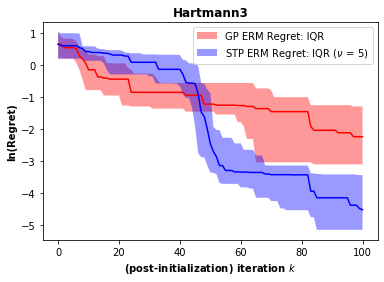

In [180]:
### 10. Visualise!

title = obj_func

plt.figure()

plt.plot(median_gp, color = 'Red')
plt.plot(median_stp, color = 'Blue')

xstar = np.arange(0, 101, step=1)
plt.fill_between(xstar, lower_gp, upper_gp, facecolor = 'Red', alpha=0.4, label='GP ERM Regret: IQR')
plt.fill_between(xstar, lower_stp, upper_stp, facecolor = 'Blue', alpha=0.4, label='STP ERM Regret: IQR ' r'($\nu$' ' = {})'.format(df1))

plt.title(title, weight = 'bold')
plt.xlabel('(post-initialization) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('ln(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

plt.show() #visualise
